In [1]:
import spikeinterface.full as si  
import spikeinterface.widgets as sw
import spikeinterface.extractors as se
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import warnings
warnings.simplefilter("ignore")
print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.101.2


Using Spikeinterface for loading information from the whole raw recording.

In [2]:
# Path for Linux
# base_folder = Path('/media/pfrhome/acasis_NVMe/Spikeinterface_practice/s4_rec') # path to dat file Linux
# base_folder = Path('/media/mouse3/acasis_NVMe/Spikeinterface_practice/s4_rec') # linux  work
# Path for Win11
base_folder = Path('F:\Spikeinterface_practice\s4_rec') # path to dat file Win11
oe_folder = base_folder / 'ephys.dat'
print(base_folder)
print(oe_folder)
#  comentario de practica

F:\Spikeinterface_practice\s4_rec
F:\Spikeinterface_practice\s4_rec\ephys.dat


In [3]:
sampling_frequency = 30_000.0  # Adjust according to your MATLAB dataset
num_channels = 43  # Adjust according to your MATLAB dataset
dtype_int = 'int16'  # Adjust according to your MATLAB dataset
gain_to_uV = 1  # No adjustment need it. Recordin is already scaled, a 1 will make no change
offset_to_uV = 0   # Adjust according to your MATLAB dataset

# full_raw_rec = si.read_openephys(oe_folder)
raw_rec = si.read_binary(file_paths=oe_folder, sampling_frequency=sampling_frequency, 
                         num_channels=num_channels, dtype=dtype_int, gain_to_uV=gain_to_uV, 
                         offset_to_uV=offset_to_uV)

In [4]:
# set channel grouping (assume we have 4 groups of 4 channels, e.g. tetrodes)
groups = [1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 
          8, 8, 8, 8, 9, 10, 10, 11, 11, 12, 12, 12, 12, 13, 14, 14, 14, 14, 15, 15, 15, 15]
raw_rec.set_channel_groups(groups)
print(raw_rec.get_channel_groups())
# split by property, in this case 'group'
recording = raw_rec.split_by("group")
print(recording)
#  Adding brain region inforation to the channels
brain_area_property_values = ['PFC']*10 + ['Unknown']*4 + ['RTC']*3 + ['CA1']*8 + ['Unknown']*1 + ['RTC']*2 + \
      ['Unknown']*6 + ['RTC']*1 + ['PFC']*8
print(brain_area_property_values)

[ 1  1  1  1  2  2  2  3  3  3  5  5  5  5  6  6  6  7  7  7  7  8  8  8
  8  9 10 10 11 11 12 12 12 12 13 14 14 14 14 15 15 15 15]
{1: ChannelSliceRecording: 4 channels - 30.0kHz - 1 segments - 89,806,848 samples 
                       2,993.56s (49.89 minutes) - int16 dtype - 685.17 MiB, 2: ChannelSliceRecording: 3 channels - 30.0kHz - 1 segments - 89,806,848 samples 
                       2,993.56s (49.89 minutes) - int16 dtype - 513.88 MiB, 3: ChannelSliceRecording: 3 channels - 30.0kHz - 1 segments - 89,806,848 samples 
                       2,993.56s (49.89 minutes) - int16 dtype - 513.88 MiB, 5: ChannelSliceRecording: 4 channels - 30.0kHz - 1 segments - 89,806,848 samples 
                       2,993.56s (49.89 minutes) - int16 dtype - 685.17 MiB, 6: ChannelSliceRecording: 3 channels - 30.0kHz - 1 segments - 89,806,848 samples 
                       2,993.56s (49.89 minutes) - int16 dtype - 513.88 MiB, 7: ChannelSliceRecording: 4 channels - 30.0kHz - 1 segments - 89,806,848

Loading Units from the recording 

In [5]:
import numpy as np
import pandas as pd
from pathlib import Path

#  This function is for savinf the units from phy to a npy file
def process_spike_data(npy_path, save_path, samp_freq=30000):
    """
    Process spike sorting data from Kilosort output files.
    
    Parameters:
    -----------
    npy_path : str
        Path to directory containing Kilosort output files
    save_path : str
        Path where processed data should be saved
    samp_freq : int, optional
        Sampling frequency in Hz (default: 30000 for Open Ephys)
    """
    # Calculate sampling rate
    samp_rate = 1 / samp_freq
    
    # Define paths to required files
    npy_dir = Path(npy_path)
    spike_times_path = npy_dir / 'spike_times.npy'
    spike_clusters_path = npy_dir / 'spike_clusters.npy'
    cluster_info_path = npy_dir / 'cluster_info.tsv'
    
    # Load data
    spike_times = np.load(spike_times_path)
    spike_clusters = np.load(spike_clusters_path)
    cluster_info = pd.read_csv(cluster_info_path, sep='\t')
    
    # Filter out noise clusters
    noise_clusters = cluster_info[cluster_info['group'] == 'noise']['cluster_id'].values
    good_spike_mask = ~np.isin(spike_clusters, noise_clusters)
    
    spike_times = spike_times[good_spike_mask]
    spike_clusters = spike_clusters[good_spike_mask]
    
    # Remove noise clusters from cluster info
    cluster_info = cluster_info[cluster_info['group'] != 'noise']
    
    # Create list to store processed clusters
    processed_clusters = []
    
    # Process each cluster
    for cluster_id in cluster_info['cluster_id'].values:
        cluster_mask = spike_clusters == cluster_id
        cluster_data = {
            'cluster_id': cluster_id,
            'spk_samples': spike_times[cluster_mask],
            'spk_time': spike_times[cluster_mask] * samp_rate,
            'channel': cluster_info[cluster_info['cluster_id'] == cluster_id]['depth'].values[0],
            'ch': cluster_info[cluster_info['cluster_id'] == cluster_id]['ch'].values[0],  # Added actual channel number
            'channel_group': cluster_info[cluster_info['cluster_id'] == cluster_id]['channel_group'].values[0]  # Added channel group
        }
        processed_clusters.append(cluster_data)
    
    # Save processed data
    save_path = Path(save_path)
    np.save(save_path / 'units.npy', processed_clusters)
    
    return processed_clusters

# Option 1: Using raw strings (recommended)
# process_spike_data(r'E:\Spikeinterface_practice\s4_rec\phyMS5', 
#                   r'D:\py_functions\ephys_py_funcs\jupyter_notebooks', 
#                   samp_freq=30000)

# Option 2: Using forward slashes
# process_spike_data('F:/Spikeinterface_practice/s4_rec/phyMS5', 
#                   'C:/Users/PedWKS/Documents/py_funcs/jupyter_notebooks', 
#                   samp_freq=30000)

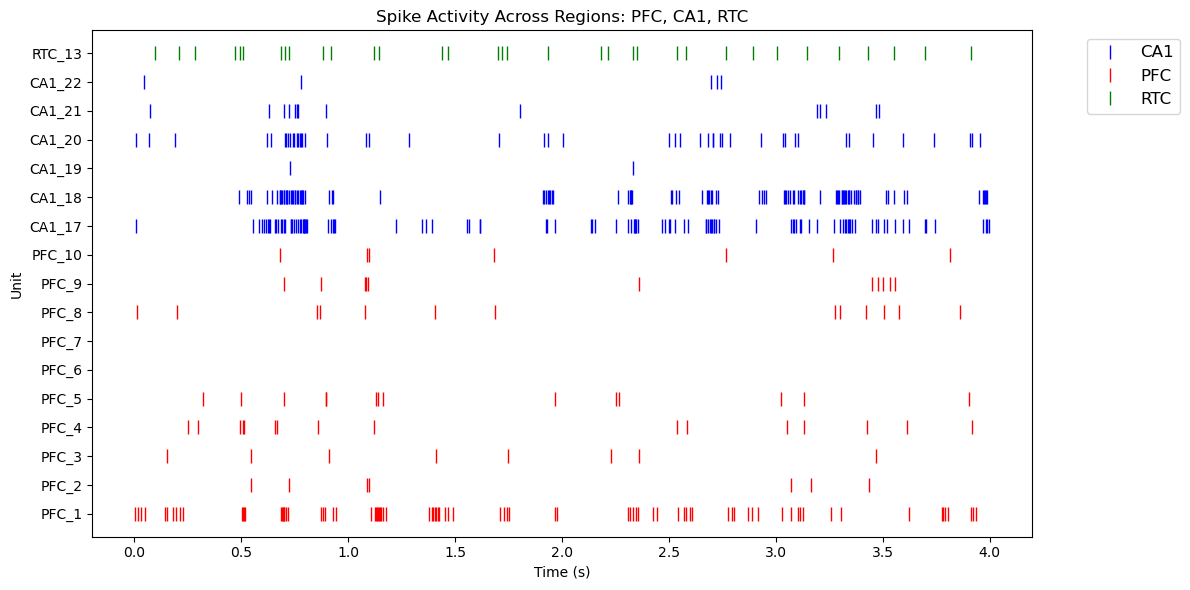

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class TetrodeAnalysis:
    def __init__(self, processed_data):
        """
        Initialize TetrodeAnalysis with processed spike data
        
        Parameters:
        -----------
        processed_data : list
            List of dictionaries containing processed cluster data
        """
        self.processed_data = processed_data
        self.tetrode_mapping = self._create_tetrode_mapping()
        
    def _create_tetrode_mapping(self):
        """Create a mapping of tetrodes to their units"""
        mapping = defaultdict(list)
        for unit in self.processed_data:
            mapping[unit['channel_group']].append(unit)
        return mapping
    
    def assign_brain_regions(self, region_mapping):
        """
        Assign brain regions to tetrodes
        
        Parameters:
        -----------
        region_mapping : dict
            Dictionary mapping tetrode numbers to brain regions
            e.g., {1: 'CA1', 2: 'CA1', 3: 'DG', 4: 'DG'}
        """
        self.region_mapping = region_mapping
        
        # Create reverse mapping (region to tetrodes)
        self.region_to_tetrodes = defaultdict(list)
        for tetrode, region in region_mapping.items():
            self.region_to_tetrodes[region].append(tetrode)
    
    def get_region_statistics(self, region):
        """
        Calculate basic statistics for all units in a brain region
        
        Parameters:
        -----------
        region : str
            Brain region to analyze
        
        Returns:
        --------
        dict
            Dictionary containing region statistics
        """
        if not hasattr(self, 'region_mapping'):
            raise ValueError("Brain regions haven't been assigned. Use assign_brain_regions first.")
            
        tetrodes = self.region_to_tetrodes[region]
        if not tetrodes:
            return f"No tetrodes found in region {region}"
            
        units = []
        for tetrode in tetrodes:
            units.extend(self.tetrode_mapping[tetrode])
            
        if not units:
            return f"No units found in region {region}"
            
        # Calculate statistics
        n_units = len(units)
        total_spikes = sum(len(unit['spk_time']) for unit in units)
        avg_firing_rates = [len(unit['spk_time']) / (unit['spk_time'][-1] - unit['spk_time'][0]) 
                          for unit in units]
        
        stats = {
            'region': region,
            'n_tetrodes': len(tetrodes),
            'n_units': n_units,
            'total_spikes': total_spikes,
            'mean_firing_rate': np.mean(avg_firing_rates),
            'std_firing_rate': np.std(avg_firing_rates),
            'tetrodes': tetrodes
        }
        
        return stats
    
    def plot_multiple_brain_regions(
        self, 
        regions, 
        time_window=None, 
        figsize=(12, 6), 
        region_colors=None, 
        markersize=4, 
        linewidth=1, 
        show_grid=True,
        legend_fontsize=10,
        legend_loc='upper left',
        y_label_format="Unit Index"
    ):
        """
        Plot all tetrodes from multiple brain regions in a single unified plot with enhanced flexibility
        
        Parameters:
        -----------
        regions : list
            List of brain regions to plot (e.g., ['CA1', 'PFC'])
        time_window : tuple, optional
            (start_time, end_time) in seconds
        figsize : tuple, optional
            Figure size for the unified plot
        region_colors : dict, optional
            Dictionary mapping regions to colors (e.g., {'CA1': 'blue', 'PFC': 'red'})
        markersize : int, optional
            Size of the spike markers
        linewidth : int, optional
            Width of the spike markers
        show_grid : bool, optional
            Whether to show the grid
        legend_fontsize : int, optional
            Font size for the legend
        legend_loc : str, optional
            Location of the legend (e.g., 'upper left', 'best')
        y_label_format : str, optional
            Format for y-axis labels. Options: "Unit Index", "Region_Unit"
        """
        if not hasattr(self, 'region_mapping'):
            raise ValueError("Brain regions haven't been assigned. Use assign_brain_regions first.")
        
        # Default region colors if not provided
        if region_colors is None:
            region_colors = {
                'CA1': 'blue',
                'PFC': 'red',
                'DG': 'green',
                'Thalamus': 'purple'
            }
        
        # Collect all units from the specified regions
        all_units = []
        unit_regions = []  # To keep track of the region for each unit
        for region in regions:
            tetrodes = self.region_to_tetrodes.get(region, [])
            for tetrode in tetrodes:
                units = self.tetrode_mapping[tetrode]
                all_units.extend(units)
                unit_regions.extend([region] * len(units))  # Assign region to each unit
        
        if not all_units:
            print(f"No units found in regions {regions}")
            return
        
        # Prepare the plot
        fig, ax = plt.subplots(figsize=figsize)
        y_offset = 0
        y_labels = []  # For custom y-axis labels
        
        for i, (unit, region) in enumerate(zip(all_units, unit_regions)):
            spike_times = unit['spk_time']
            
            # Apply time window filter if provided
            if time_window is not None:
                mask = (spike_times >= time_window[0]) & (spike_times <= time_window[1])
                spike_times = spike_times[mask]
            
            # Plot spikes for this unit with the region's color
            ax.plot(spike_times, np.ones_like(spike_times) * y_offset, '|', markersize=markersize, 
                    linewidth=linewidth, color=region_colors.get(region, 'gray'), 
                    label=f"{region} Unit {unit['cluster_id']}")
            
            # Store y-axis label information
            if y_label_format == "Region_Unit":
                y_labels.append(f"{region}_{unit['cluster_id']}")
            else:
                y_labels.append(str(y_offset))
            
            # Increment y_offset for the next unit
            y_offset += 1
        
        # Add labels and title
        ax.set_title(f"Spike Activity Across Regions: {', '.join(regions)}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Unit")
        
        # Fix grid visibility issue
        if show_grid:
            ax.grid(visible=True, alpha=0.3)
        else:
            ax.grid(visible=False)
        
        # Customize y-axis ticks and labels
        ax.set_yticks(np.arange(0, y_offset, 1))  # One tick per unit
        ax.set_yticklabels(y_labels)
        
        # Add legend outside the plot
        handles = [
            plt.Line2D([0], [0], color=color, marker='|', linestyle='None', markersize=10, label=region)
            for region, color in region_colors.items()
        ]
        ax.legend(handles=handles, fontsize=legend_fontsize, bbox_to_anchor=(1.05, 1), loc=legend_loc)
        
        plt.tight_layout()
        plt.show()

# Example usage:
if __name__ == "__main__":
    # Load your processed data
    processed_data = np.load('units.npy', allow_pickle=True)
    
    # Create analyzer object
    analyzer = TetrodeAnalysis(processed_data)
    
    
    # Assign brain regions
    region_mapping = {
        2: 'PFC',
        3: 'PFC',
        7: 'CA1',
        8: 'CA1',
        6: 'RTC'
    }
    analyzer.assign_brain_regions(region_mapping)
    
    # Define custom region colors
    custom_colors = {
        'CA1': 'blue',
        'PFC': 'red',
        'RTC': 'green'
    }
    
    # Plot multiple brain regions with enhanced customization
    analyzer.plot_multiple_brain_regions(
        ['PFC', 'CA1', 'RTC'], 
        time_window=(0, 4),
        region_colors=custom_colors,
        markersize=10,
        linewidth=1,
        show_grid=False,
        legend_fontsize=12,
        legend_loc='upper left',
        y_label_format="Region_Unit"  # Show region and unit ID on y-axis
    )
    
    # Get statistics for CA1
    # ca1_stats = analyzer.get_region_statistics('CA1')
    # print("\nCA1 Statistics:")
    # for key, value in ca1_stats.items():
    #     print(f"{key}: {value}")

#### Added parallel processing with an alternative method for estimating the firing rate "faster".

In [7]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import concurrent.futures
from functools import partial

class OptimizedSpikeAnalysis:
    def __init__(self, processed_data, sampling_rate=30000, total_samples=89806848, duration=2993.56):
        """
        Initialize with recording parameters
        
        Parameters:
        -----------
        processed_data : list
            List of dictionaries containing spike data
        sampling_rate : int
            Original recording sampling rate in Hz (default: 30kHz)
        total_samples : int
            Total number of samples in the recording
        duration : float
            Total duration of the recording in seconds
        """
        self.processed_data = processed_data
        self.recording_sampling_rate = sampling_rate
        self.total_samples = total_samples
        self.duration = duration
        self.unit_mapping = self._create_unit_mapping()
        self.tetrode_mapping = self._create_tetrode_mapping()
        
    def _create_unit_mapping(self):
        return {unit['cluster_id']: unit for unit in self.processed_data}
    
    def _create_tetrode_mapping(self):
        mapping = {}
        for unit in self.processed_data:
            tetrode = unit['channel_group']
            if tetrode not in mapping:
                mapping[tetrode] = []
            mapping[tetrode].append(unit)
        return mapping

    def _get_time_bins(self, analysis_sampling_rate=1000, time_range=None):
        """
        Calculate time bins based on recording parameters
        
        Parameters:
        -----------
        analysis_sampling_rate : int
            Desired sampling rate for the analysis in Hz
        time_range : tuple or None
            Optional (start_time, end_time) in seconds for analysis window
        """
        if time_range is None:
            start_time = 0
            end_time = self.duration
        else:
            start_time, end_time = time_range
            # Ensure we stay within recording bounds
            start_time = max(0, start_time)
            end_time = min(self.duration, end_time)

        dt = 1/analysis_sampling_rate
        num_bins = int(np.ceil((end_time - start_time) * analysis_sampling_rate))
        bins = np.linspace(start_time, end_time, num_bins + 1)
        times = (bins[:-1] + bins[1:]) / 2
        
        return times, bins

    def get_firing_rate(self, spike_times, bins, kernel_width=0.05, sampling_rate=1000):
        """Calculate firing rate using histogram and Gaussian smoothing with predefined bins"""
        # Compute histogram using numpy's optimized function
        hist, _ = np.histogram(spike_times, bins=bins)
        
        # Convert kernel width from seconds to bins
        kernel_bins = int(kernel_width * sampling_rate)
        if kernel_bins % 2 == 0:
            kernel_bins += 1
            
        # Apply Gaussian smoothing
        sigma = kernel_bins / (2 * np.sqrt(2 * np.log(2)))
        rates = gaussian_filter1d(hist.astype(float), sigma)
        
        # Convert to firing rate in Hz
        rates = rates * sampling_rate
        
        return rates

    def analyze_data(self, identifiers, id_type='unit', kernel_width=0.05, sampling_rate=1000, 
                    time_range=None, full_recording=False):
        """Analyze firing rates with parallel processing"""
        if not isinstance(identifiers, (list, tuple, np.ndarray)):
            identifiers = [identifiers]
            
        results = {
            'window': {'individual': {}, 'average': None, 'std': None, 'times': None},
            'full': {'individual': {}, 'average': None, 'std': None, 'times': None}
        }
        
        # Get relevant units
        units_to_analyze = []
        if id_type == 'unit':
            units_to_analyze = [self.unit_mapping[id] for id in identifiers if id in self.unit_mapping]
        elif id_type in ['tetrode', 'multi_tetrode']:
            for tet in identifiers:
                if tet in self.tetrode_mapping:
                    units_to_analyze.extend(self.tetrode_mapping[tet])
        
        if not units_to_analyze:
            return results
                    
        # Process time ranges
        time_ranges = [time_range]
        if full_recording:
            time_ranges.append((0, self.duration))
                
        # Process each time range
        for t_range in time_ranges:
            key = 'window' if t_range == time_range else 'full'
            
            # Get consistent time bins for the analysis
            times, bins = self._get_time_bins(sampling_rate, t_range)
            
            # Calculate rates for each unit
            rates_list = []
            for unit in units_to_analyze:
                rates = self.get_firing_rate(unit['spk_time'], bins, kernel_width, sampling_rate)
                rates_list.append(rates)
                
            if rates_list:
                rates = np.array(rates_list)
                avg_rate = np.mean(rates, axis=0)
                std_rate = np.std(rates, axis=0)
                
                # Store results
                for i, unit in enumerate(units_to_analyze):
                    results[key]['individual'][unit['cluster_id']] = {
                        'times': times,
                        'rates': rates[i],
                        'spikes': unit['spk_time'],
                        'channel_group': unit['channel_group']
                    }
                
                results[key]['average'] = avg_rate
                results[key]['std'] = std_rate
                results[key]['times'] = times
                
        return results

    def plot_analysis(self, results, plot_type='both', figsize=(15, 5)):
        """Plot analysis results"""
        import matplotlib.pyplot as plt
    
        if plot_type not in ['window', 'full', 'both']:
            raise ValueError("plot_type must be 'window', 'full', or 'both'")
        
        n_plots = 2 if plot_type == 'both' else 1
        fig = plt.figure(figsize=figsize)
        gs = plt.GridSpec(2, n_plots, height_ratios=[1, 1], hspace=0.3, wspace=0.3)
    
        def plot_results(data, col, title_suffix):
            if not data['individual']:
                return
            
            # Extract times for alignment
            times = data['times']
            start_time, end_time = times[0], times[-1]
        
            # Raster plot
            ax_raster = fig.add_subplot(gs[0, col])
        
            # Plot individual spikes
            unit_count = 0
            tetrode_boundaries = []
            tetrode_labels = []
            current_tetrode = None
        
            for cluster_id, unit_data in data['individual'].items():
                spikes = unit_data['spikes']
            
                # Filter spikes to match the analysis time window
                spikes_in_window = spikes[(spikes >= start_time) & (spikes <= end_time)]
            
                tetrode = unit_data['channel_group']
            
                if current_tetrode != tetrode:
                    if current_tetrode is not None:
                        tetrode_boundaries.append((tetrode_start + unit_count - 1) / 2)
                        tetrode_labels.append(f'T{current_tetrode}')
                    current_tetrode = tetrode
                    tetrode_start = unit_count
                
                ax_raster.plot(spikes_in_window, np.ones_like(spikes_in_window) * unit_count, '|', 
                            markersize=4, label=f'Unit {cluster_id}')
                unit_count += 1
            
            if current_tetrode is not None:
                tetrode_boundaries.append((tetrode_start + unit_count - 1) / 2)
                tetrode_labels.append(f'T{current_tetrode}')
            
            ax_raster.set_yticks(tetrode_boundaries)
            ax_raster.set_yticklabels(tetrode_labels)
            ax_raster.set_title(f'Spike Raster Plot {title_suffix}')
            ax_raster.set_xlabel('Time (s)')
            ax_raster.set_xlim(start_time, end_time)  # Align x-axis with firing rate plot
        
            # Rate plot
            ax_rates = fig.add_subplot(gs[1, col])
        
            # Plot individual rates
            for unit_data in data['individual'].values():
                ax_rates.plot(unit_data['times'], unit_data['rates'], alpha=0.2)
            
            # Plot average rate
            if data['average'] is not None:
                ax_rates.plot(times, data['average'], 
                            color='black', linewidth=2, label='Average')
                ax_rates.fill_between(times,
                                    data['average'] - data['std'],
                                    data['average'] + data['std'],
                                    color='gray', alpha=0.2)
            
            ax_rates.set_xlabel('Time (s)')
            ax_rates.set_ylabel('Firing Rate (Hz)')
            ax_rates.set_title(f'Firing Rates {title_suffix}')
            ax_rates.legend()
            ax_rates.grid(True, alpha=0.3)
            ax_rates.set_xlim(start_time, end_time)  # Align x-axis with raster plot
        
        if plot_type in ['window', 'both']:
            plot_results(results['window'], 0, '(Window)')
        
        if plot_type in ['full', 'both']:
            plot_results(results['full'], 1 if plot_type == 'both' else 0, '(Full Recording)')
        
        plt.show()

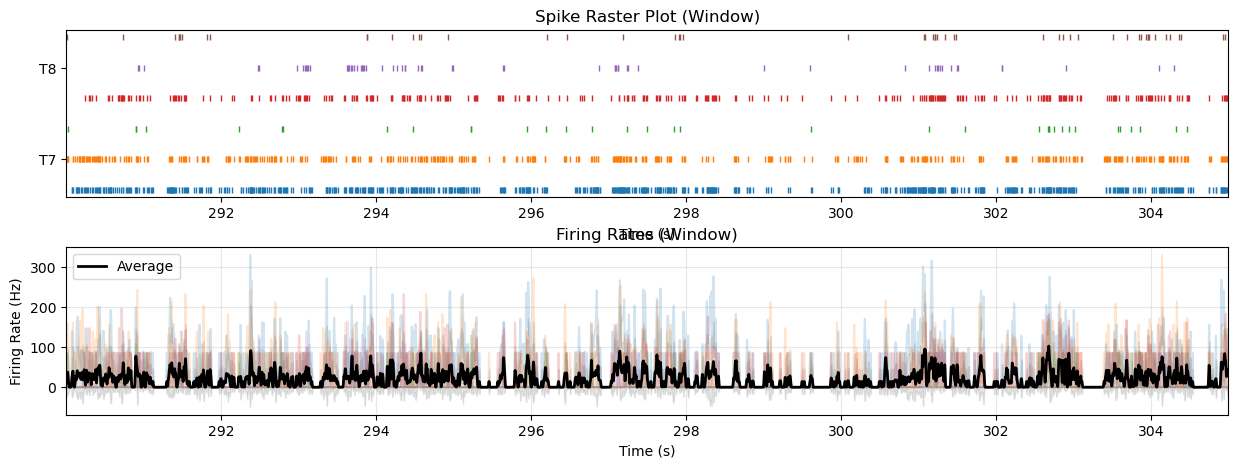

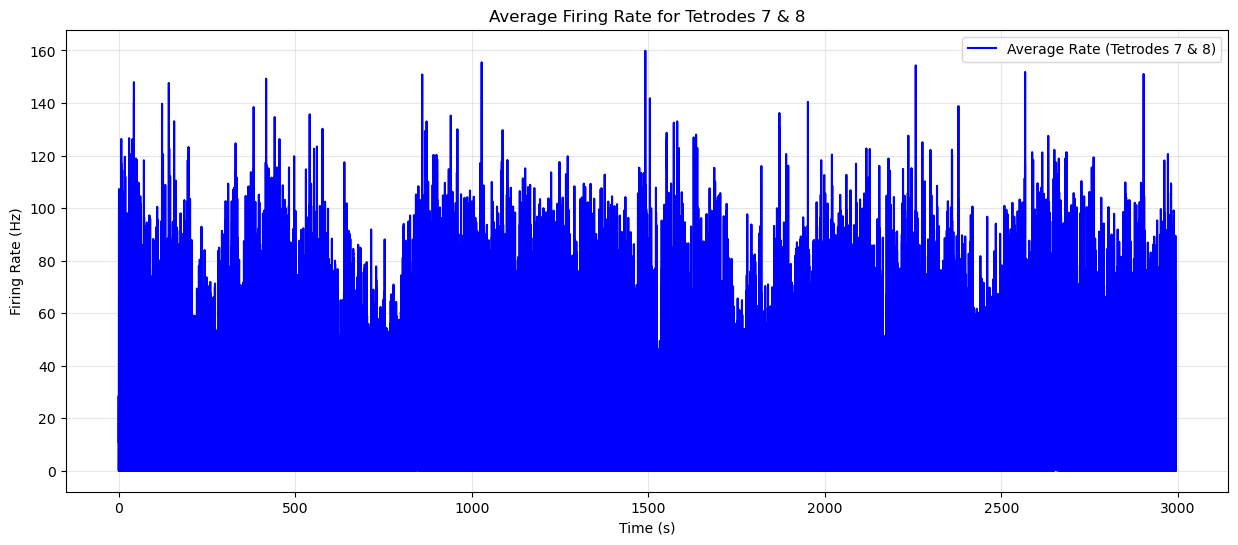

In [8]:
# Initialize with recording parameters
analyzer = OptimizedSpikeAnalysis(
    processed_data,
    sampling_rate=30000,  # 30 kHz
    total_samples=89806848,
    duration=2993.56
)

# Analyze the data
results = analyzer.analyze_data(
    identifiers=[7,8],
    id_type='tetrode',
    kernel_width=0.01,
    sampling_rate=1000,  # Analysis sampling rate (100 Hz)
    time_range=(290, 305),  # First 10 seconds
    full_recording=True  # Also compute for full recording
)

# Plot the results
# analyzer.plot_analysis(results, plot_type='both')
analyzer.plot_analysis(results, plot_type='window')

# Create plot
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
times = results['full']['times']
avg_rate = results['full']['average']
# std_rate = results['full']['std']

# Ensure lower bound never goes below 0
# lower_bound = np.maximum(0, avg_rate - std_rate)
# upper_bound = avg_rate + std_rate

plt.plot(times, avg_rate, 'b-', label='Average Rate (Tetrodes 7 & 8)')
# plt.fill_between(times, 
#                  lower_bound,  # Use the corrected lower bound
#                  upper_bound,
#                  color='b', alpha=0.2,
#                  label='±1 STD')

plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Average Firing Rate for Tetrodes 7 & 8')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [9]:
# Examples of how to access the data:

# # 1. Get windowed data:
# window_times = results['window']['times']
# window_average = results['window']['average']
# window_std = results['window']['std']

# # 2. Get full recording data:
# full_times = results['full']['times']
# full_average = results['full']['average']
# full_std = results['full']['std']

# # 3. Access individual unit data (windowed):
# for cluster_id, unit_data in results['window']['individual'].items():
#     unit_times = unit_data['times']
#     unit_rates = unit_data['rates']
#     unit_spikes = unit_data['spikes']
#     tetrode_num = unit_data['channel_group']
#     print(f"Unit {cluster_id} from tetrode {tetrode_num}")

# # 4. Calculate mean firing rate for specific window:
# window_mean_rate = np.mean(results['window']['average'])
# print(f"Mean firing rate in window: {window_mean_rate:.2f} Hz")

# # 5. Get number of units:
# n_units = len(results['window']['individual'])
# print(f"Number of units: {n_units}")

# # 6. Get unique tetrodes:
# tetrodes = set(unit['channel_group'] for unit in results['window']['individual'].values())
# print(f"Tetrodes: {tetrodes}")

In [10]:
# def get_results_summary(results):
#     """Print a summary of the analysis results"""
#     summary = {}
    
#     for period in ['window', 'full']:
#         if results[period]['average'] is not None:
#             n_units = len(results[period]['individual'])
#             mean_rate = np.mean(results[period]['average'])
#             peak_rate = np.max(results[period]['average'])
#             tetrodes = set(unit['channel_group'] 
#                          for unit in results[period]['individual'].values())
            
#             summary[period] = {
#                 'n_units': n_units,
#                 'tetrodes': sorted(tetrodes),
#                 'mean_rate': mean_rate,
#                 'peak_rate': peak_rate,
#                 'time_range': (results[period]['times'][0], 
#                              results[period]['times'][-1])
#             }
    
#     return summary

# # Use it like this:
# summary = get_results_summary(multi_results)
# print("\nWindow analysis:")
# print(f"Number of units: {summary['window']['n_units']}")
# print(f"Tetrodes: {summary['window']['tetrodes']}")
# print(f"Mean firing rate: {summary['window']['mean_rate']:.2f} Hz")
# print(f"Peak firing rate: {summary['window']['peak_rate']:.2f} Hz")
# print(f"Time range: {summary['window']['time_range']} seconds")

Performing common reference to reduce noise.

In [9]:
rec_cmr = si.common_reference(raw_rec, reference='global', operator='average')
# rec_cmr_hpass_w = whiten(rec_cmr_hpass, dtype='int', int_scale=1)
recording_layers = dict(
    raw=raw_rec,
    # bandpass=rec_filt,
    cmr= rec_cmr
)
# w = sw.plot_timeseries(recording_f, color_groups=True)
%matplotlib widget
w = sw.plot_traces(recording_layers, backend="ipywidgets",color_groups=True)

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [12]:
# %% Import required libraries
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import signal
# from scipy.io import loadmat

In [13]:
import numpy as np
import warnings

def validate_channel_time_format(data, n_channels=None):
    # Ensure data is a numpy array
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    
    # Check if 2D
    if len(data.shape) != 2:
        raise ValueError(f"Data must be 2D, got shape {data.shape}")
    
    time_dim, channel_dim = data.shape
    
    # Determine the correct format
    if n_channels is not None and channel_dim != n_channels:
        if time_dim == n_channels:
            warnings.warn("Assuming first dimension as channels. Transposing to channels x time.")
            data = data.T  # This creates a copy, but we aim for clarity here.
        else:
            raise ValueError(f"Data does not have {n_channels} channels in either dimension")
    elif n_channels is None and time_dim > channel_dim:
        warnings.warn("First dimension is larger. Assuming data is in time x channels format. Transposing to channels x time.")
        data = data.T
    
    return data

In [14]:
import numpy as np
from scipy import signal

def resample_trace(data, original_fs, target_fs, axis=-1):
    """
    Resample time series data from original sampling rate to target sampling rate,
    handling non-integer conversion ratios.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input data array. Can be 1D or 2D (multiple traces)
    original_fs : float
        Original sampling frequency in Hz
    target_fs : float
        Target sampling frequency in Hz
    axis : int, optional
        Axis along which to resample (default=-1, last axis)
        
    Returns:
    --------
    numpy.ndarray
        Resampled data
    float
        Actual achieved sampling rate
    """
    # Calculate number of samples for the target signal
    original_samples = data.shape[axis]
    target_samples = int(np.round(original_samples * target_fs / original_fs))
    
    # Apply anti-aliasing filter
    nyquist = min(target_fs, original_fs) / 2
    b, a = signal.butter(4, nyquist, fs=original_fs, btype='low')
    filtered_data = signal.filtfilt(b, a, data, axis=axis)
    
    # Resample the filtered data
    resampled_data = signal.resample(filtered_data, target_samples, axis=axis)
    
    # Calculate actual achieved sampling rate
    actual_fs = original_fs * (target_samples / original_samples)
    
    return resampled_data, actual_fs

# Example usage:
"""
# For a single trace
sample_data = np.random.randn(30000)  # 1 second of 30kHz data
resampled, actual_fs = resample_trace(sample_data, 30000, 1234.56)
print(f"Achieved sampling rate: {actual_fs:.2f} Hz")

# For multiple traces
multiple_traces = np.random.randn(5, 30000)  # 5 traces of 1 second at 30kHz
resampled_traces, actual_fs = resample_trace(multiple_traces, 30000, 1234.56, axis=1)
"""

'\n# For a single trace\nsample_data = np.random.randn(30000)  # 1 second of 30kHz data\nresampled, actual_fs = resample_trace(sample_data, 30000, 1234.56)\nprint(f"Achieved sampling rate: {actual_fs:.2f} Hz")\n\n# For multiple traces\nmultiple_traces = np.random.randn(5, 30000)  # 5 traces of 1 second at 30kHz\nresampled_traces, actual_fs = resample_trace(multiple_traces, 30000, 1234.56, axis=1)\n'

Down-sampling the data from 30KHz to 2.5KHz

In [15]:
# %% Load data and parameters
hipp_data, actual_fs = resample_trace(validate_channel_time_format(rec_cmr.get_traces(channel_ids=[19,21])), raw_rec.sampling_frequency, 2500, axis=1) # This are all the hippocmapus channels, this time from tetrode 7 and 8
print(hipp_data.shape)

(2, 7483904)


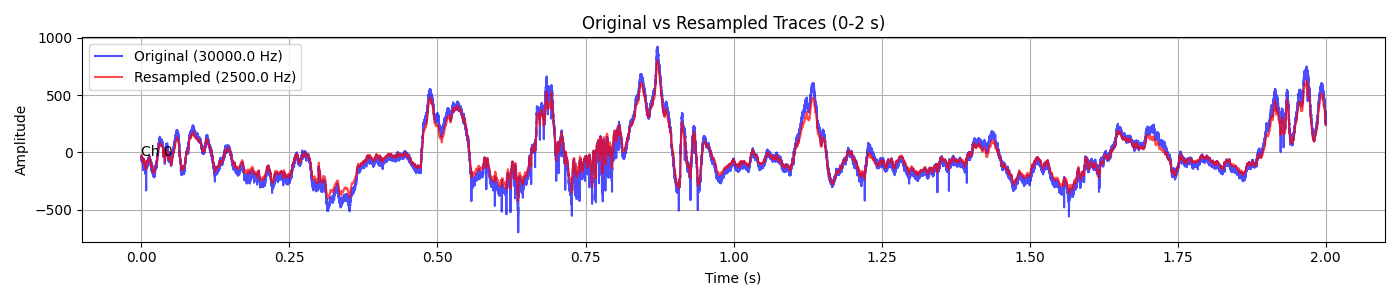

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_traces(original_data, resampled_data, original_fs, resampled_fs, 
                time_window, channels=None, offset_factor=1.5):
    """
    Plot original and resampled traces for a specific time window.
    
    Parameters:
    -----------
    original_data : numpy.ndarray
        Original data array. Can be 1D (time) or 2D (channels x time)
    resampled_data : numpy.ndarray
        Resampled data array. Same number of channels as original_data
    original_fs : float
        Original sampling frequency in Hz
    resampled_fs : float
        Resampled sampling frequency in Hz
    time_window : tuple
        Time window to plot in seconds (start_time, end_time)
    channels : list or None
        List of channel indices to plot. If None, plots all channels
    offset_factor : float
        Vertical offset between channels for visualization
    
    Returns:
    --------
    fig : matplotlib figure
        The generated figure
    """
    # Ensure data is 2D
    if original_data.ndim == 1:
        original_data = original_data[np.newaxis, :]
        resampled_data = resampled_data[np.newaxis, :]
    
    # Create time arrays
    original_time = np.arange(original_data.shape[1]) / original_fs
    resampled_time = np.arange(resampled_data.shape[1]) / resampled_fs
    
    # Select channels to plot
    if channels is None:
        channels = np.arange(original_data.shape[0])
    
    # Create time window masks
    orig_mask = (original_time >= time_window[0]) & (original_time <= time_window[1])
    resampled_mask = (resampled_time >= time_window[0]) & (resampled_time <= time_window[1])
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 3))
    
    # Plot each channel
    for i, ch in enumerate(channels):
        # Calculate offset for this channel
        offset = i * offset_factor * np.abs(original_data[ch]).max()
        
        # Plot original data
        ax.plot(original_time[orig_mask], 
                original_data[ch][orig_mask] + offset, 
                'b-', label=f'Original ({original_fs} Hz)' if i==0 else "", 
                alpha=0.7)
        
        # Plot resampled data
        ax.plot(resampled_time[resampled_mask], 
                resampled_data[ch][resampled_mask] + offset, 
                'r-', label=f'Resampled ({resampled_fs} Hz)' if i==0 else "", 
                alpha=0.7)
        
        # Add channel label
        ax.text(time_window[0], offset, f'Ch {ch}', 
                verticalalignment='center')
    
    # Customize plot
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'Original vs Resampled Traces ({time_window[0]}-{time_window[1]} s)')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    return fig

# Example usage:
"""
# Generate example data
t = np.linspace(0, 10, 300000)  # 10 seconds at 30kHz
original_fs = 30000
resampled_fs = 1000

# Single channel example
original = np.sin(2*np.pi*5*t) + 0.5*np.sin(2*np.pi*10*t)  # 5 Hz and 10 Hz components
resampled = signal.resample(original, len(t) // 30)  # Downsample to 1kHz

fig = plot_traces(original, resampled,
                 original_fs=original_fs,
                 resampled_fs=resampled_fs,
                 time_window=(1.0, 1.2))  # Plot 200ms window

# Multiple channel example
original_multi = np.vstack([original, 
                          original * 1.5 + 0.5,
                          original * 0.75 - 0.3])
resampled_multi = signal.resample(original_multi, len(t) // 30)

fig = plot_traces(original_multi, resampled_multi,
                 original_fs=original_fs,
                 resampled_fs=resampled_fs,
                 time_window=(1.0, 1.2),
                 channels=[0, 2])  # Plot only channels 0 and 2
plt.show()
"""
org_data = validate_channel_time_format(raw_rec.get_traces(channel_ids=[19,21]))
fig = plot_traces(org_data, hipp_data,
                 original_fs= raw_rec.sampling_frequency,
                 resampled_fs=actual_fs,
                 time_window=(0, 2),
                 channels=[0])  # Plot only channels 0 and 2
plt.show()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, widgets
from IPython.display import display
import ipywidgets as widgets

def create_interactive_plot(original_data, resampled_data, original_fs, resampled_fs):
    """
    Create interactive plot with widgets to control channels and time window.
    
    Parameters:
    -----------
    original_data : numpy.ndarray
        Original data array (channels x time) or (time,)
    resampled_data : numpy.ndarray
        Resampled data array (channels x time) or (time,)
    original_fs : float
        Original sampling frequency in Hz
    resampled_fs : float
        Resampled sampling frequency in Hz
    """
    # Ensure data is 2D
    if original_data.ndim == 1:
        original_data = original_data[np.newaxis, :]
        resampled_data = resampled_data[np.newaxis, :]
    
    # Calculate total duration
    total_duration = original_data.shape[1] / original_fs
    
    # Create channel selection widget
    channel_options = [(f'Channel {i}', i) for i in range(original_data.shape[0])]
    channel_select = widgets.SelectMultiple(
        options=channel_options,
        value=(0,),
        description='Channels:',
        disabled=False
    )
    
    # Create time window widgets
    window_size = widgets.FloatSlider(
        value=1.0,
        min=0.1,
        max=5.0,
        step=0.1,
        description='Window (s):',
        continuous_update=False
    )
    
    time_slider = widgets.FloatSlider(
        value=0.0,
        min=0.0,
        max=total_duration - window_size.value,
        step=0.1,
        description='Start time:',
        continuous_update=False
    )
    
    # Create navigation buttons
    step_size = widgets.FloatText(
        value=1.0,
        description='Step (s):',
        style={'description_width': 'initial'}
    )
    
    prev_button = widgets.Button(description='← Previous')
    next_button = widgets.Button(description='Next →')
    
    # Create offset factor slider
    offset_slider = widgets.FloatSlider(
        value=1.5,
        min=0.5,
        max=5.0,
        step=0.1,
        description='Channel spacing:',
        continuous_update=False
    )
    
    # Create the output widget for the plot
    out = widgets.Output()
    
    def update_plot(channels, start_time, window_duration, offset_factor):
        """Update the plot with current widget values"""
        with out:
            out.clear_output(wait=True)
            
            # Create time arrays
            original_time = np.arange(original_data.shape[1]) / original_fs
            resampled_time = np.arange(resampled_data.shape[1]) / resampled_fs
            
            # Create time window masks
            time_window = (start_time, start_time + window_duration)
            orig_mask = (original_time >= time_window[0]) & (original_time <= time_window[1])
            resampled_mask = (resampled_time >= time_window[0]) & (resampled_time <= time_window[1])
            
            # Create figure
            fig, ax = plt.subplots(figsize=(14, 3))
            
            # Plot each selected channel
            for i, ch in enumerate(channels):
                offset = i * offset_factor * np.abs(original_data[ch]).max()
                
                # Plot original data
                ax.plot(original_time[orig_mask], 
                        original_data[ch][orig_mask] + offset, 
                        'b-', label=f'Original ({original_fs} Hz)' if i==0 else "", 
                        alpha=0.7)
                
                # Plot resampled data
                ax.plot(resampled_time[resampled_mask], 
                        resampled_data[ch][resampled_mask] + offset, 
                        'r-', label=f'Resampled ({resampled_fs} Hz)' if i==0 else "", 
                        alpha=0.7)
                
                # Add channel label
                ax.text(time_window[0], offset, f'Ch {ch}', 
                        verticalalignment='center')
            
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Amplitude')
            ax.set_title(f'Time Window: {time_window[0]:.1f}-{time_window[1]:.1f} s')
            ax.legend()
            ax.grid(True)
            
            plt.tight_layout()
            plt.show()
    
    def update_time_slider(*args):
        """Update time slider max value based on window size"""
        time_slider.max = total_duration - window_size.value
        if time_slider.value > time_slider.max:
            time_slider.value = time_slider.max
    
    def on_prev_button_clicked(b):
        """Handle previous button click"""
        new_time = max(0, time_slider.value - step_size.value)
        time_slider.value = new_time
    
    def on_next_button_clicked(b):
        """Handle next button click"""
        new_time = min(time_slider.max, time_slider.value + step_size.value)
        time_slider.value = new_time
    
    # Connect callbacks
    window_size.observe(update_time_slider, 'value')
    prev_button.on_click(on_prev_button_clicked)
    next_button.on_click(on_next_button_clicked)
    
    # Create interactive plot
    interactive_plot = interactive(update_plot, 
                                 channels=channel_select,
                                 start_time=time_slider,
                                 window_duration=window_size,
                                 offset_factor=offset_slider)
    
    # Create navigation controls container
    nav_controls = widgets.HBox([step_size, prev_button, next_button])
    
    # Display all widgets and plot
    display(widgets.VBox([
        widgets.HBox([channel_select, 
                     widgets.VBox([window_size, time_slider, offset_slider])]),
        nav_controls,
        out
    ]))

# Example usage:
"""
# Generate example data
t = np.linspace(0, 10, 300000)  # 10 seconds at 30kHz
original_fs = 30000
resampled_fs = 1000

# Create multiple channels with different frequencies
original_data = np.vstack([
    np.sin(2*np.pi*5*t),  # 5 Hz
    np.sin(2*np.pi*10*t),  # 10 Hz
    np.sin(2*np.pi*15*t),  # 15 Hz
    np.sin(2*np.pi*20*t)   # 20 Hz
])

# Resample the data
resampled_data = signal.resample(original_data, len(t) // 30)

# Create interactive plot
create_interactive_plot(original_data, resampled_data, 
                      original_fs=original_fs, 
                      resampled_fs=resampled_fs)
"""

create_interactive_plot(org_data, hipp_data, 
                      original_fs=raw_rec.sampling_frequency, 
                      resampled_fs=actual_fs)
del org_data

**Position Data loading and Interpolation**

In [18]:
import numpy as np
from scipy.io import loadmat
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import interpolate
from pathlib import Path
import scipy.io
from typing import Tuple, Union, Optional, List
from typing import Union, Optional, List, Dict, Any
from scipy.interpolate import interp1d
import os
from typing import List, Dict, Union, Optional

def load_all_position_data(
    file_path: str,
    struct_name: Optional[str] = None,
    fields: Optional[List[str]] = None,
    maintain_2d: Optional[List[str]] = None
) -> Dict[str, np.ndarray]:
    """
    Flexible loader for position and other data from MATLAB .mat files.
    
    Parameters:
    -----------
    file_path : str
        Path to the MATLAB .mat file
    struct_name : str, optional
        Name of the struct containing the data. If None, will attempt to detect.
    fields : List[str], optional
        List of field names to extract. If None, will extract all available fields.
    maintain_2d : List[str], optional
        List of field names that should maintain 2D structure (e.g., ['pos'] for x,y coordinates)
        
    Returns:
    --------
    Dict[str, np.ndarray]
        Dictionary containing the requested fields as numpy arrays
    """
    # Load the MATLAB file
    mat_data = scipy.io.loadmat(file_path, squeeze_me=True)
    
    # Find the main struct if not specified
    if struct_name is None:
        possible_structs = [k for k in mat_data.keys() if not k.startswith('__')]
        if len(possible_structs) == 0:
            raise ValueError("No valid structs found in .mat file")
        struct_name = possible_structs[0]
    
    # Get the data struct
    if struct_name not in mat_data:
        raise KeyError(f"Struct '{struct_name}' not found in .mat file")
    data_struct = mat_data[struct_name]
    
    # Get available fields
    available_fields = data_struct.dtype.names
    if not available_fields:
        raise ValueError("No fields found in the data struct")
    
    # If no fields specified, use all available fields
    if fields is None:
        fields = list(available_fields)
    
    # Initialize output dictionary
    output_data = {}
    
    # Initialize maintain_2d list if None
    if maintain_2d is None:
        maintain_2d = ['pos', 'position']  # Default fields to maintain as 2D
    
    # Extract requested fields
    for field in fields:
        if field not in available_fields:
            raise KeyError(f"Field '{field}' not found. Available fields: {available_fields}")
        
        # Extract and convert to numpy array
        data = np.asarray(data_struct[field].item())
        
        # Handle dimensionality
        if field in maintain_2d:
            if data.ndim == 1:
                data = data.reshape(-1, 1)
            elif data.ndim == 2:
                pass  # Keep as is
            else:
                raise ValueError(f"Field '{field}' has unexpected dimensions: {data.ndim}")
        else:
            if data.ndim > 1:
                data = data.flatten()
        
        output_data[field] = data
    
    # Validate data lengths
    lengths = [arr.shape[0] for arr in output_data.values()]
    if not all(length == lengths[0] for length in lengths):
        raise ValueError("Mismatch in data lengths across fields")
    
    return output_data

def load_position_data(
    file_path: str,
    struct_name: Optional[str] = None,
    time_key: Optional[str] = None,
    position_key: Optional[str] = None,
    return_time: bool = True
) -> Union[np.ndarray, List[np.ndarray], Tuple[np.ndarray, Union[np.ndarray, List[np.ndarray]]]]:
    """
    Flexible loader for position data from MATLAB .mat files.
    
    Parameters:
    -----------
    file_path : str
        Path to the MATLAB .mat file
    struct_name : str, optional
        Name of the struct containing the data. If None, will attempt to detect.
    time_key : str, optional
        Name of the time data field. If None, will look for common time field names.
    position_key : str, optional
        Name of the position data field. If None, will look for common position field names.
    return_time : bool, optional
        Whether to return time data (default True)
        
    Returns:
    --------
    Union[np.ndarray, List[np.ndarray], Tuple[np.ndarray, Union[np.ndarray, List[np.ndarray]]]]
        If return_time=True:
            Returns (time_data, position_data) tuple where:
            - time_data : np.ndarray, 1D array of time points
            - position_data : np.ndarray (shape: (n,) for 1D or (n,2) for 2D) or list of np.ndarray
        If return_time=False:
            Returns just position_data
    """
    # Load the MATLAB file
    mat_data = scipy.io.loadmat(file_path, squeeze_me=True)
    
    # Find the main struct if not specified
    if struct_name is None:
        possible_structs = [k for k in mat_data.keys() if not k.startswith('__')]
        if len(possible_structs) == 0:
            raise ValueError("No valid structs found in .mat file")
        struct_name = possible_structs[0]
    
    # Get the data struct
    if struct_name not in mat_data:
        raise KeyError(f"Struct '{struct_name}' not found in .mat file")
    data_struct = mat_data[struct_name]
    
    # Get available fields
    available_fields = data_struct.dtype.names
    if not available_fields:
        raise ValueError("No fields found in the data struct")
    
    # Find position data
    position_candidates = ['pos', 'position', 'linearpos', 'linear_pos'] if position_key is None else [position_key]
    position_fields = [field for field in position_candidates if field in available_fields]
    
    if not position_fields:
        raise ValueError(f"No position fields found. Available fields: {available_fields}")
    
    # Extract position data
    position_data = []
    for field in position_fields:
        pos = np.asarray(data_struct[field].item())
        
        # Handle different dimensionalities
        if field in ['pos', 'position']:  # These are expected to be 2D (x,y) coordinates
            if pos.ndim == 1:  # If somehow 1D, reshape to 2D
                pos = pos.reshape(-1, 1)
            elif pos.ndim == 2 and pos.shape[1] >= 2:
                pos = pos[:, :2]  # Keep only x,y coordinates if there are more
        else:  # For other fields (like linearpos), keep as 1D
            if pos.ndim > 1:
                pos = pos.flatten()
        
        position_data.append(pos)
    
    # Return single array if only one position field, list of arrays if multiple
    if len(position_data) == 1:
        position_data = position_data[0]
    
    # If time data is not needed, return just the position data
    if not return_time:
        return position_data
        
    # Find time data
    time_candidates = ['time', 't', 'timestamp'] if time_key is None else [time_key]
    time_field = None
    for candidate in time_candidates:
        if candidate in available_fields:
            time_field = candidate
            break
    
    if time_field is None:
        raise ValueError(f"No time field found. Available fields: {available_fields}")
    
    # Extract time data
    time_data = np.asarray(data_struct[time_field].item())
    
    # Validate data lengths
    if isinstance(position_data, list):
        for pos in position_data:
            expected_len = len(time_data)
            actual_len = pos.shape[0]
            if actual_len != expected_len:
                raise ValueError(f"Mismatch between time ({expected_len}) and position ({actual_len}) data lengths")
    else:
        expected_len = len(time_data)
        actual_len = position_data.shape[0]
        if actual_len != expected_len:
            raise ValueError(f"Mismatch between time ({expected_len}) and position ({actual_len}) data lengths")
    
    return time_data, position_data

def plot_position_data(time, position, title='Position vs Time', xlabel='Time (s)', ylabel='Position (cm)'):
    """
    Plot linear position data over time
    
    Parameters:
    -----------
    time : np.ndarray
        Time array in seconds
    position : np.ndarray
        Position array in cm
    title : str
        Plot title
    xlabel : str
        X-axis label
    ylabel : str
        Y-axis label
    """
    plt.figure(figsize=(10, 4))
    plt.plot(time, position, label='Position')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def interpolate_position(time, position, target_fs=None, target_vector=None, interp_func=None):
    """
    Interpolate position data to match target sampling frequency or a specific vector.
    When target_vector is 2D, the output length matches the larger dimension (max of rows or columns).
    
    Parameters:
    -----------
    time : np.ndarray
        Original time array (1D)
    position : np.ndarray
        Original position array (1D)
    target_fs : float, optional
        Target sampling frequency in Hz (default is None)
    target_vector : np.ndarray, optional
        Specific target vector for new time points (can be 1D or 2D) (default is None)
    interp_func : scipy.interpolate.interp1d, optional
        Pre-existing interpolation function to use instead of creating a new one (default is None)
        
    Returns:
    --------
    tuple
        (output_times, new_position) where both are 1D arrays with length matching:
        - If target_vector is 1D: length of target_vector
        - If target_vector is 2D: max(n_rows, n_cols) of target_vector
    """
    # Input validation
    if not isinstance(time, np.ndarray) or not isinstance(position, np.ndarray):
        raise TypeError("time and position must be numpy arrays")
    if time.ndim != 1 or position.ndim != 1:
        raise ValueError("time and position must be 1D arrays")
    if len(time) != len(position):
        raise ValueError("time and position must have the same length")

    # Handle target vector creation
    if target_fs is not None and target_vector is None:
        duration = time[-1] - time[0]
        num_samples = int(duration * target_fs)
        target_vector = np.linspace(time[0], time[-1], num_samples)
    elif target_vector is not None and target_fs is None:
        if not isinstance(target_vector, np.ndarray):
            raise TypeError("target_vector must be a numpy array")
        if target_vector.ndim > 2:
            raise ValueError("target_vector must be either 1D or 2D")
    else:
        raise ValueError("Either provide a target sampling frequency or a specific target vector for new time points.")
    
    # Create interpolation function if not provided
    if interp_func is None:
        interp_func = interp1d(time, position, kind='linear', fill_value="extrapolate")
    
    # Determine output length based on target_vector dimensions
    if target_vector.ndim == 1:
        output_length = len(target_vector)
        output_times = target_vector
    else:
        # For 2D array, use the larger dimension
        output_length = max(target_vector.shape)
        output_times = np.linspace(time[0], time[-1], output_length)
    
    # Interpolate position
    new_position = interp_func(output_times)
    
    return output_times, new_position

def plot_interpolated_comparison(original_time, original_pos, 
                               interp_time, interp_pos, 
                               title='Original vs Interpolated Position'):
    """
    Plot comparison between original and interpolated position data
    
    Parameters:
    -----------
    original_time : np.ndarray
        Original time array
    original_pos : np.ndarray
        Original position array
    interp_time : np.ndarray
        Interpolated time array
    interp_pos : np.ndarray
        Interpolated position array
    title : str
        Plot title
    """
    plt.figure(figsize=(12, 5))
    
    # Plot original data with thicker line
    plt.plot(original_time, original_pos, 'b-', lw=3, 
             label=f'Original ({len(original_time)} points)')
    
    # Plot interpolated data with thinner line
    plt.plot(interp_time, interp_pos, 'r-', lw=1,
             label=f'Interpolated ({len(interp_time)} points)')
    
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Position (cm)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def estimate_velocity(time, position):
    """
    Estimate velocity from position data using numerical differentiation
    
    Parameters:
    -----------
    time : np.ndarray
        Time array in seconds
    position : np.ndarray
        Position array in cm
        
    Returns:
    --------
    np.ndarray
        Velocity array in cm/s
    """
    if len(time) != len(position):
        raise ValueError("Time and position arrays must have the same length")
    
    # Numerical differentiation to estimate velocity
    velocity = np.gradient(position, time)
    
    return velocity

def plot_velocity_comparison(original_time, original_pos, 
                              estimated_vel, title='Original vs Estimated Velocity'):
    """
    Plot comparison between original and estimated velocity data
    
    Parameters:
    -----------
    original_time : np.ndarray
        Original time array
    original_pos : np.ndarray
        Original position array
    estimated_vel : np.ndarray
        Estimated velocity array in cm/s
    title : str
        Plot title
    """
    plt.figure(figsize=(12, 5))
    
    # Plot original position data
    plt.plot(original_time, original_pos, 'b-', 
             label=f'Original Position ({len(original_time)} points)')
    
    # Plot estimated velocity data
    plt.plot(original_time[:-1], estimated_vel, 'r.', 
             label=f'Estimated Velocity ({len(estimated_vel)} points)')
    
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (cm/s)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def get_file_nested_keys(file_path: str) -> Tuple[str, List[str]]:
    """
    Find the struct name and extract all its nested keys from a MATLAB .mat file.
    
    Args:
        file_path (str): Path to the .mat file
    
    Returns:
        Tuple[str, List[str]]: A tuple containing (struct_name, list_of_nested_keys)
    """
    # Load the MATLAB file
    mat_data = scipy.io.loadmat(file_path, struct_as_record=False, squeeze_me=True)
    
    def _extract_nested_keys(mat_struct, parent_key="") -> List[str]:
        """
        Helper function to recursively extract nested keys
        """
        keys = []
        
        if isinstance(mat_struct, scipy.io.matlab.mio5_params.mat_struct):
            for field in mat_struct._fieldnames:
                full_key = f"{parent_key}.{field}" if parent_key else field
                keys.append(full_key)
                sub_struct = getattr(mat_struct, field)
                keys.extend(_extract_nested_keys(sub_struct, full_key))
                
        elif isinstance(mat_struct, dict):
            for field, sub_struct in mat_struct.items():
                if not field.startswith('__'):
                    full_key = f"{parent_key}.{field}" if parent_key else field
                    keys.append(full_key)
                    keys.extend(_extract_nested_keys(sub_struct, full_key))
                    
        elif isinstance(mat_struct, np.ndarray):
            if mat_struct.dtype.names:
                for field in mat_struct.dtype.names:
                    full_key = f"{parent_key}.{field}" if parent_key else field
                    keys.append(full_key)
                    sub_struct = mat_struct[field]
                    keys.extend(_extract_nested_keys(sub_struct, full_key))
            elif mat_struct.size > 0 and hasattr(mat_struct.item(0), '_fieldnames'):
                first_item = mat_struct.item(0)
                keys.extend(_extract_nested_keys(first_item, parent_key))
                
        return keys

    # Find the main struct (excluding Python special attributes)
    struct_names = [k for k in mat_data.keys() if not k.startswith('__')]
    
    if not struct_names:
        raise ValueError("No valid structs found in the .mat file")
    
    # Get the main struct name (assuming it's 'positiondata' or similar)
    struct_name = struct_names[0]
    
    # Get nested keys for the struct
    nested_keys = _extract_nested_keys(mat_data[struct_name])
    
    return struct_name, nested_keys


In [19]:
# Example usage
if __name__ == "__main__":
    file_path = r'F:\DataAnalysis\hpRetPFC1\S4\position\PositionData.mat'
    
    # Get struct name and nested keys
    struct_name, nested_keys = get_file_nested_keys(file_path)
    print(f"Found struct: {struct_name}")
    print(f"\nNested keys for {struct_name}:")
    for key in nested_keys:
        print(f"  {key}")

Found struct: positiondata

Nested keys for positiondata:
  linearpos
  time
  pos
  linVel


In [20]:
# Example usage for the All data
# if __name__ == "__main__":
    # Get all available fields
    # all_data = load_all_position_data('F:/DataAnalysis/hpRetPFC1/S4/position/PositionData.mat')
    # print("Available fields:", list(all_data.keys()))
    
    # # Get specific fields
    # data = load_position_data('PositionData.mat', 
    #                         fields=['time', 'pos', 'linearpos'])
    # print("\nLoaded data shapes:")
    # for field, arr in data.items():
    #     print(f"{field}: {arr.shape}")
    
    # # Use the data
    # if 'pos' in data:
    #     pos = data['pos']  # 2D array (x,y coordinates)
    #     x_coords = pos[:, 0]
    #     y_coords = pos[:, 1]
    
    # if 'time' in data:
    #     timestamps = data['time']  # 1D array
    
    # if 'linearpos' in data:
    #     linear_position = data['linearpos']  # 1D array

In [21]:
# Get 2D position data (x,y coordinates)
# time, pos = load_position_data('F:/DataAnalysis/hpRetPFC1/S4/position/PositionData.mat', position_key='pos')
# print(f"X coordinates: {pos[:,0]}")
# print(f"Y coordinates: {pos[:,1]}")

# Get 1D linear position
time,linear_vel = load_position_data(r'F:\DataAnalysis\hpRetPFC1\S4\position\PositionData.mat', 
                              position_key='linVel',
                              return_time=True)
# Get 1D linear position
# linear_pos = load_position_data('F:/DataAnalysis/hpRetPFC1/S4/position/PositionData.mat', 
#                               position_key='linearpos',
#                               return_time=False)

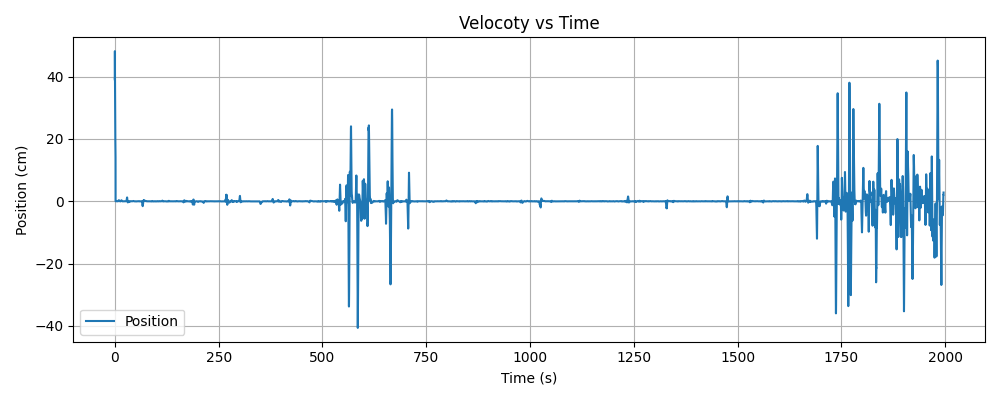

In [22]:
plot_position_data(time, linear_vel, title='Velocoty vs Time', xlabel='Time (s)', ylabel='Position (cm)')
# plot_position_data(time, linear_pos, title='Position vs Time', xlabel='Time (s)', ylabel='Position (cm)')

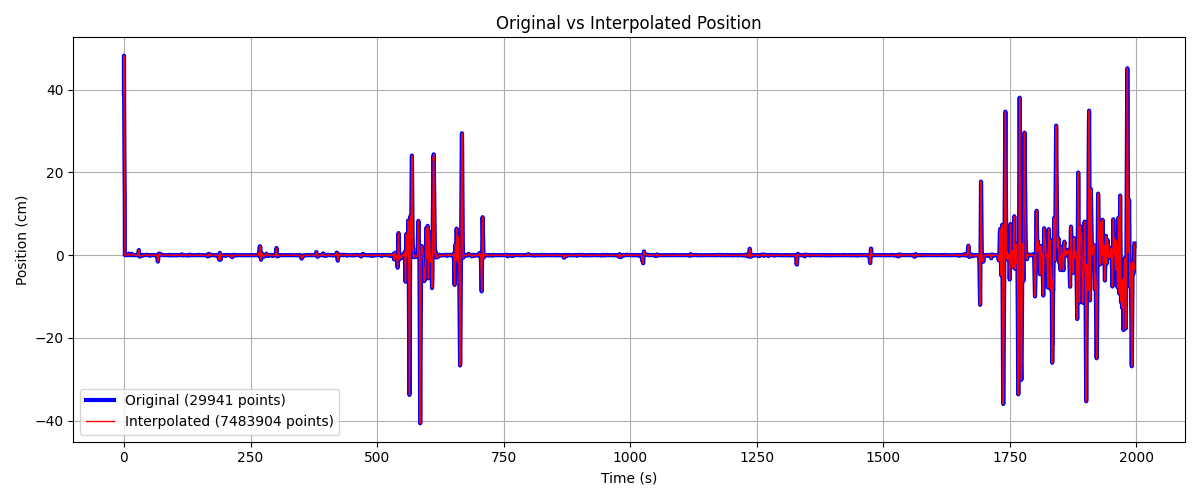

In [23]:
time_n, linvel_n = interpolate_position(time, linear_vel, target_vector=hipp_data)
plot_interpolated_comparison(time, linear_vel, 
                               time_n, linvel_n, 
                               title='Original vs Interpolated Position')

In [24]:
time_n, hipp_avg_fr = interpolate_position(times, avg_rate , target_vector=hipp_data)
# plot_interpolated_comparison(time, linear_vel, 
#                                new_time, new_linvel, 
#                                title='Original vs Interpolated Position')

In [25]:
del linear_vel
del time
del times

**SWR detection Functions(Old Code)**

In [24]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

class SWRParams:
    def __init__(self,
                 # Required parameters
                 ripple_band=(150, 250),
                 threshold_multiplier=3,
                 min_duration=0.03,
                 max_duration=0.4,
                 # Optional parameters
                 notch_freq=60,
                 sharpwave_band=None,  # Set to None to disable sharp wave detection
                 velocity_threshold=None,  # Set to None to disable velocity filtering
                 trace_window=0.2,
                 # Event detection parameters
                 duration_std_threshold=0.1,
                 min_event_separation=0.05,
                 merge_threshold=0.8,
                 # Classification parameters
                 single_separation=0.2,      # 200ms minimum separation for singles
                 burst_min_interval=0.07,    # 70ms minimum between burst events
                 burst_max_interval=0.2,     # 200ms maximum between burst events
                 merge_interval=0.07,        # Merge events closer than 70ms
                 # MUA parameters
                 mua_threshold_multiplier=2.5,  # Threshold for MUA detection in SD
                 mua_min_duration=0.02,         # Minimum duration for MUA events
                 enable_mua=True):             # Whether to detect MUA events
        """
        Parameters for SWR and MUA detection and classification
        """
        # Required parameters
        self.ripple_band = ripple_band
        self.threshold_multiplier = threshold_multiplier
        self.min_duration = min_duration
        self.max_duration = max_duration

        # Optional parameters
        self.notch_freq = notch_freq
        self.sharpwave_band = sharpwave_band
        self.velocity_threshold = velocity_threshold
        self.trace_window = trace_window

        # Event detection parameters
        self.duration_std_threshold = duration_std_threshold
        self.min_event_separation = min_event_separation
        self.merge_threshold = merge_threshold

        # Classification parameters
        self.single_separation = single_separation
        self.burst_min_interval = burst_min_interval
        self.burst_max_interval = burst_max_interval
        self.merge_interval = merge_interval

        # MUA parameters
        self.mua_threshold_multiplier = mua_threshold_multiplier
        self.mua_min_duration = mua_min_duration
        self.enable_mua = enable_mua

    def update(self, **kwargs):
        """Update parameters with new values"""
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Invalid parameter: {key}")
        return self

class SWRDetector:
    def __init__(self, lfp_data, fs, mua_data=None, velocity_data=None, params=None):
        """
        Initialize SWR detector.
        Parameters:
        lfp_data : np.ndarray
            LFP data array of shape (n_channels, n_timepoints)
        fs : float
            Sampling frequency in Hz
        mua_data : np.ndarray, optional
            Multi-unit activity data array of shape (n_timepoints,)
        velocity_data : np.ndarray, optional
            Velocity data array of shape (n_timepoints,)
        params : SWRParams, optional
            Detection parameters. If None, uses default parameters
        """
        # Validate input data format
        if not isinstance(lfp_data, np.ndarray):
            raise TypeError("lfp_data must be a numpy array")
        if len(lfp_data.shape) != 2:
            raise ValueError("lfp_data must be 2D array (channels x time)")

        self.n_channels, self.n_timepoints = lfp_data.shape

        # Validate MUA data if provided
        if mua_data is not None:
            if not isinstance(mua_data, np.ndarray):
                raise TypeError("mua_data must be a numpy array")
            if len(mua_data) != self.n_timepoints:
                raise ValueError(f"mua_data length ({len(mua_data)}) must match "
                                 f"lfp_data timepoints ({self.n_timepoints})")

        # Validate velocity data if provided
        if velocity_data is not None:
            if not isinstance(velocity_data, np.ndarray):
                raise TypeError("velocity_data must be a numpy array")
            if len(velocity_data) != self.n_timepoints:
                raise ValueError(f"velocity_data length ({len(velocity_data)}) must match "
                                 f"lfp_data timepoints ({self.n_timepoints})")

        self.lfp_data = lfp_data
        self.fs = fs
        self.mua_data = mua_data
        self.velocity_data = velocity_data
        self.params = params if params is not None else SWRParams()
        self.swr_events = []
        self.event_counter = 0

        print(f"Initialized SWR detector with {self.n_channels} channels and "
              f"{self.n_timepoints / self.fs:.2f} seconds of data")

        # Print current parameters
        self._print_params()

    def _print_params(self):
        """Print all current detection parameters in a formatted way"""
        print("\nCurrent Detection Parameters:")
        print("=" * 30)

        # Core parameters
        print("\nCore Parameters:")
        print(f"Ripple band: {self.params.ripple_band} Hz")
        print(f"Threshold multiplier: {self.params.threshold_multiplier} SD")
        print(f"Duration limits: {self.params.min_duration}-{self.params.max_duration} s")

        # Signal processing parameters
        print("\nSignal Processing:")
        print(f"Notch frequency: {self.params.notch_freq if self.params.notch_freq else 'Disabled'} Hz")
        print(f"Sharp wave band: {self.params.sharpwave_band if self.params.sharpwave_band else 'Disabled'} Hz")
        print(f"Trace window: {self.params.trace_window} s")

        # Event detection parameters
        print("\nEvent Detection:")
        print(f"Duration std threshold: {self.params.duration_std_threshold} SD")
        print(f"Minimum event separation: {self.params.min_event_separation} s")
        print(f"Merge threshold: {self.params.merge_threshold}")

        # Classification parameters
        print("\nClassification Parameters:")
        print(f"Single separation: {self.params.single_separation * 1000:.0f} ms")
        print(f"Burst intervals: {self.params.burst_min_interval * 1000:.0f}-"
              f"{self.params.burst_max_interval * 1000:.0f} ms")
        print(f"Merge interval: {self.params.merge_interval * 1000:.0f} ms")

        # MUA parameters
        print("\nMUA Parameters:")
        print(f"MUA detection: {'Enabled' if self.params.enable_mua else 'Disabled'}")
        if self.params.enable_mua:
            print(f"MUA threshold: {self.params.mua_threshold_multiplier} SD")
            print(f"MUA min duration: {self.params.mua_min_duration * 1000:.0f} ms")

        # Movement filtering
        print("\nMovement Filtering:")
        print(f"Velocity threshold: {self.params.velocity_threshold if self.params.velocity_threshold else 'Disabled'} cm/s")

        # Data information
        print("\nData Information:")
        print(f"Number of channels: {self.n_channels}")
        print(f"Recording duration: {self.n_timepoints / self.fs:.2f} s")
        print(f"Sampling rate: {self.fs} Hz")
        print(f"MUA data: {'Provided' if self.mua_data is not None else 'Not provided'}")
        print(f"Velocity data: {'Provided' if self.velocity_data is not None else 'Not provided'}")

        print("\n" + "=" * 30)

    def update_params(self, **kwargs):
        """Update detection parameters"""
        self.params.update(**kwargs)
        print("Parameters updated:")
        self._print_params()

    def detect_events(self, channels='all', average_mode=False):
        """
        Detect SWR events either on individual channels or averaged signal.
        Parameters:
        channels : list or 'all'
            Channels to process. If 'all', uses all channels
        average_mode : bool
            If True, average signals across channels before detection
        """
        if channels == 'all':
            channels = np.arange(self.n_channels)
        else:
            # Validate channel indices
            channels = np.array(channels)
            if np.any(channels >= self.n_channels) or np.any(channels < 0):
                raise ValueError(f"Channel indices must be between 0 and {self.n_channels - 1}")

        if average_mode:
            print(f"Detecting events on averaged signal from {len(channels)} channels")
            avg_lfp = np.mean(self.lfp_data[channels], axis=0)
            self._process_signal(avg_lfp, 'avg')
        else:
            print(f"Detecting events on {len(channels)} individual channels")
            for ch in channels:
                self._process_signal(self.lfp_data[ch], ch)

        print(f"Detected {len(self.swr_events)} events")

    def _process_signal(self, signal_data, channel_id):
        """Process single channel or averaged signal for event detection."""
        # Initial signal processing
        if self.params.notch_freq:
            notched = self._notch_filter(signal_data, self.params.notch_freq)
        else:
            notched = signal_data

        # Ripple processing
        ripple_filtered = self._bandpass_filter(notched, *self.params.ripple_band)
        ripple_power = np.abs(signal.hilbert(ripple_filtered))
        smooth_ripple_power = np.convolve(ripple_power, np.ones(50) / 50, mode='same') ** 2
        ripple_threshold = (np.mean(smooth_ripple_power) +
                            self.params.threshold_multiplier * np.std(smooth_ripple_power))
        above_ripple = smooth_ripple_power > ripple_threshold

        # MUA processing using provided spike rate data
        if self.params.enable_mua and self.mua_data is not None:
            # Use a sliding window to smooth MUA data
            window_size = int(0.02 * self.fs)  # 20ms window
            smooth_mua = np.convolve(self.mua_data, np.ones(window_size) / window_size, mode='same')
            mua_threshold = (np.mean(smooth_mua) +
                             self.params.mua_threshold_multiplier * np.std(smooth_mua))
            above_mua = smooth_mua > mua_threshold
        else:
            smooth_mua = None
            above_mua = None

        # Sharp wave processing
        if self.params.sharpwave_band:
            sharpwave_filtered = self._bandpass_filter(notched, *self.params.sharpwave_band)
            sharpwave_power = np.abs(signal.hilbert(sharpwave_filtered))
            smooth_sw_power = np.convolve(sharpwave_power, np.ones(50) / 50, mode='same') ** 2
            sw_threshold = np.mean(smooth_sw_power) - 2 * np.std(smooth_sw_power)
        else:
            sharpwave_filtered = None
            smooth_sw_power = None
            sw_threshold = None

        # Find events that pass either threshold
        if self.params.enable_mua and self.mua_data is not None:
            # Combine threshold crossings
            event_markers = above_ripple | above_mua
        else:
            event_markers = above_ripple

        # Find threshold crossings
        crossings = np.diff(event_markers.astype(int))
        starts = np.where(crossings == 1)[0]
        ends = np.where(crossings == -1)[0]

        # Handle edge cases
        if len(ends) == 0 or len(starts) == 0:
            return
        if ends[0] < starts[0]:
            ends = ends[1:]
        if starts[-1] > ends[-1]:
            starts = starts[:-1]

        # Process each potential event
        for start, end in zip(starts, ends):
            duration = (end - start) / self.fs

            # Check if duration meets criteria for either type of event
            valid_duration = False
            if duration >= self.params.mua_min_duration and duration <= self.params.max_duration:
                valid_duration = True

            if valid_duration:
                # Determine event type based on which thresholds it passes
                ripple_event = False
                mua_event = False

                if above_ripple[start:end].any():
                    ripple_idx = start + np.argmax(smooth_ripple_power[start:end])
                    ripple_peak = smooth_ripple_power[ripple_idx]
                    if ripple_peak > ripple_threshold:
                        ripple_event = True

                if self.params.enable_mua and self.mua_data is not None and above_mua[start:end].any():
                    mua_idx = start + np.argmax(smooth_mua[start:end])
                    mua_peak = smooth_mua[mua_idx]
                    if mua_peak > mua_threshold:
                        mua_event = True

                # Classify event based on which thresholds it passes
                if ripple_event and mua_event:
                    event_type = 'ripple_mua'
                    peak_idx = ripple_idx  # Use ripple peak for timing
                    peak_power = smooth_ripple_power[ripple_idx]
                elif ripple_event:
                    event_type = 'ripple_only'
                    peak_idx = ripple_idx
                    peak_power = smooth_ripple_power[ripple_idx]
                elif mua_event:
                    event_type = 'mua_only'
                    peak_idx = mua_idx
                    peak_power = smooth_mua[mua_idx]
                else:
                    continue  # Skip if it doesn't meet any threshold

                peak_time = peak_idx / self.fs

                # Additional validation checks
                valid_event = True

                # Velocity check
                if self.params.velocity_threshold is not None and self.velocity_data is not None:
                    vel_window = self.velocity_data[start:end]
                    if np.mean(vel_window) > self.params.velocity_threshold:
                        valid_event = False

                # Sharp wave validation (only for ripple events)
                if (valid_event and self.params.sharpwave_band and
                        event_type in ['ripple_only', 'ripple_mua']):
                    sw_window = smooth_sw_power[start:end]
                    if not np.any(sw_window < sw_threshold):
                        valid_event = False

                if not valid_event:
                    continue

                # Extract traces
                win_samples = int(self.params.trace_window * self.fs)
                half_win = win_samples // 2
                trace_start = max(0, peak_idx - half_win)
                trace_end = min(len(notched), peak_idx + half_win)

                # Find peaks for classification
                if event_type in ['ripple_only', 'ripple_mua']:
                    peak_times = signal.find_peaks(
                        smooth_ripple_power[start:end],
                        height=ripple_threshold,
                        distance=int(0.02 * self.fs)  # Minimum 20ms between peaks
                    )[0]
                else:  # mua_only
                    peak_times = signal.find_peaks(
                        smooth_mua[start:end],
                        height=mua_threshold,
                        distance=int(0.02 * self.fs)
                    )[0]

                peak_times = [start + pk_idx for pk_idx in peak_times]

                self.event_counter += 1
                new_event = {
                    'event_id': self.event_counter,
                    'channel': channel_id,
                    'start_idx': start,
                    'end_idx': end,
                    'start_time': start / self.fs,
                    'end_time': end / self.fs,
                    'duration': duration,
                    'peak_time': peak_time,
                    'peak_power': peak_power,
                    'peak_times': peak_times,
                    'event_type': event_type,
                    'raw_trace': notched[trace_start:trace_end],
                    'ripple_trace': ripple_filtered[trace_start:trace_end],
                    'mua_trace': smooth_mua[trace_start:trace_end] if smooth_mua is not None else None,
                    'ripple_power': ripple_power[trace_start:trace_end],
                    'sharpwave_trace': sharpwave_filtered[trace_start:trace_end] if sharpwave_filtered is not None else None,
                    'trace_timestamps': np.linspace(
                        peak_time - (peak_idx - trace_start) / self.fs,
                        peak_time + (trace_end - peak_idx) / self.fs,
                        trace_end - trace_start
                    )
                }
                self.swr_events.append(new_event)

    def _notch_filter(self, data, notch_freq=60):
        """Apply notch filter to remove line noise."""
        nyquist = self.fs / 2
        b, a = signal.iirnotch(notch_freq / nyquist, 30)
        return signal.filtfilt(b, a, data)

    def _bandpass_filter(self, data, low_freq, high_freq):
        """Apply bandpass filter."""
        nyquist = self.fs / 2
        b, a = signal.butter(3, [low_freq / nyquist, high_freq / nyquist], btype='band')
        return signal.filtfilt(b, a, data)

    def classify_events(self):
        """
        Classify events into singles, doubles, triples, etc., while maintaining
        their event type (ripple_only/mua_only/ripple_mua).
        """
        if not self.swr_events:
            print("No events detected")
            return

        # Sort events by start time and channel
        sorted_events = sorted(self.swr_events, key=lambda x: (x['channel'], x['start_time']))
    
        # Process events channel by channel
        current_channel = None
        channel_events = []
        all_groups = []
    
        for event in sorted_events:
            if current_channel != event['channel']:
                # Process previous channel's events
                if channel_events:
                    groups = self._classify_channel_events(channel_events)
                    all_groups.extend(groups)
                # Start new channel
                current_channel = event['channel']
                channel_events = [event]
            else:
                channel_events.append(event)
    
        # Process last channel
        if channel_events:
            groups = self._classify_channel_events(channel_events)
            all_groups.extend(groups)
        
        # Print classification summary
        singles = sum(1 for g in all_groups if len(g) == 1)
        doubles = sum(1 for g in all_groups if len(g) == 2)
        triples = sum(1 for g in all_groups if len(g) == 3)
        multiples = sum(1 for g in all_groups if len(g) > 3)
    
        print(f"\nClassification Summary:")
        print(f"Singles: {singles}")
        print(f"Doubles: {doubles}")
        print(f"Triples: {triples}")
        print(f"Multiples: {multiples}")

    def _classify_channel_events(self, events):
        """Helper method to classify events within a single channel."""
        if not events:
            return []
        
        groups = []
        current_group = [events[0]]
    
        for i in range(1, len(events)):
            current_event = events[i]
            prev_event = current_group[-1]
        
            # Calculate interval to previous event
            interval = current_event['start_time'] - prev_event['end_time']
        
            # Check if event belongs to current group
            if (interval >= self.params.burst_min_interval and 
                interval <= self.params.burst_max_interval and
                current_event['event_type'] == prev_event['event_type']):
                current_group.append(current_event)
            else:
                # Classify previous group
                self._assign_group_classification(current_group, len(groups))
                groups.append(current_group)
                current_group = [current_event]
    
        # Classify last group
        if current_group:
            self._assign_group_classification(current_group, len(groups))
            groups.append(current_group)
    
        return groups

    def _assign_group_classification(self, group, group_id):
        """Assign classification details to a group of events."""
        group_size = len(group)
    
        # Determine group type
        if group_size == 1:
            # Check if it's truly isolated
            is_single = True
            if len(self.swr_events) > 1:
                event = group[0]
                event_idx = self.swr_events.index(event)
            
                # Check previous event if exists
                if event_idx > 0:
                    prev_event = self.swr_events[event_idx - 1]
                    if (prev_event['channel'] == event['channel'] and
                        event['start_time'] - prev_event['end_time'] < self.params.single_separation):
                        is_single = False
            
                # Check next event if exists
                if event_idx < len(self.swr_events) - 1:
                    next_event = self.swr_events[event_idx + 1]
                    if (next_event['channel'] == event['channel'] and
                        next_event['start_time'] - event['end_time'] < self.params.single_separation):
                        is_single = False
        
            group_type = 'single' if is_single else 'unclassified'
        elif group_size == 2:
            group_type = 'double'
        elif group_size == 3:
            group_type = 'triple'
        else:
            group_type = 'multiple'
    
        # Calculate inter-event intervals
        intervals = []
        for i in range(1, len(group)):
            interval = group[i]['start_time'] - group[i-1]['end_time']
            intervals.append(interval)
    
        # Update classification for each event in group
        for i, event in enumerate(group):
            event['classification'] = {
                'group_size': group_size,
                'group_id': group_id,
                'position_in_group': i + 1,
                'group_type': group_type,
                'inter_event_intervals': intervals,
                'event_type': event['event_type'],
                'peak_count': len(event.get('peak_times', [1]))
            }

    def _merge_close_events(self):
        """
        Merge events that are closer than merge_interval (70ms).
        Returns new list of merged events.
        """
        if not self.swr_events:
            return []

        sorted_events = sorted(self.swr_events, key=lambda x: x['start_time'])
        merged = []
        current_merge = None

        for event in sorted_events:
            if current_merge is None:
                current_merge = event.copy()
                continue

            interval = event['start_time'] - current_merge['end_time']

            if interval < self.params.merge_interval:
                # Only merge events of the same type
                if event['event_type'] == current_merge['event_type']:
                    # Merge events
                    current_merge['end_time'] = max(current_merge['end_time'], event['end_time'])
                    current_merge['end_idx'] = max(current_merge['end_idx'], event['end_idx'])
                    current_merge['duration'] = current_merge['end_time'] - current_merge['start_time']
                    current_merge['peak_times'] = sorted(
                        current_merge.get('peak_times', [current_merge['peak_time']]) +
                        event.get('peak_times', [event['peak_time']])
                    )

                    # Keep the highest power peak
                    if event['peak_power'] > current_merge['peak_power']:
                        current_merge['peak_time'] = event['peak_time']
                        current_merge['peak_power'] = event['peak_power']
                    continue

            merged.append(current_merge)
            current_merge = event.copy()

        if current_merge is not None:
            merged.append(current_merge)

        return merged

    def get_events_summary(self):
        """Return a pandas DataFrame with key event parameters."""
        if not self.swr_events:
            print("No events detected")
            return None

        summary = []
        for event in self.swr_events:
            event_summary = {
                'event_id': event['event_id'],
                'channel': event['channel'],
                'start_time': event['start_time'],
                'end_time': event['end_time'],
                'duration': event['duration'],
                'peak_time': event['peak_time'],
                'peak_power': event['peak_power'],
                'event_type': event['event_type']
            }

            # Add classification information if available
            if 'classification' in event:
                event_summary.update({
                    'group_type': event['classification']['group_type'],
                    'group_size': event['classification']['group_size'],
                    'position_in_group': event['classification']['position_in_group'],
                    'peak_count': event['classification']['peak_count']
                })

            summary.append(event_summary)

        return pd.DataFrame(summary)

    def save_events(self, filename):
        """Save detected events to a file."""
        events_df = self.get_events_summary()
        if events_df is not None:
            events_df.to_csv(filename, index=False)
            print(f"Saved {len(events_df)} events to {filename}")

    def get_event(self, event_id):
        """Get a specific event by its ID."""
        for event in self.swr_events:
            if event['event_id'] == event_id:
                return event
        print(f"Event ID {event_id} not found")
        return None

    def get_channel_events(self, channel):
        """Get all events from a specific channel."""
        channel_events = [event for event in self.swr_events if event['channel'] == channel]
        if not channel_events:
            print(f"No events found for channel {channel}")
        return channel_events

    def get_classification_summary(self):
        """
        Return a summary of event classifications including both temporal patterns
        and event types (ripple/MUA).
        """
        if not self.swr_events:
            return None

        # Initialize counters for each event type
        classification_stats = {
            event_type: {
                'singles': 0,
                'doubles': 0,
                'triples': 0,
                'more': 0,
                'unclassified': 0,
                'intervals': {
                    'doubles': [],
                    'triples': [],
                    'more': []
                }
            }
            for event_type in ['ripple_mua', 'ripple_only', 'mua_only']
        }

        # Add parameters section
        classification_stats['parameters'] = {
            'single_separation': self.params.single_separation,
            'burst_min_interval': self.params.burst_min_interval,
            'burst_max_interval': self.params.burst_max_interval,
            'merge_interval': self.params.merge_interval
        }

        # Count events by classification and type
        processed_groups = set()
        for event in self.swr_events:
            if 'classification' not in event:
                continue

            group_id = event['classification']['group_id']
            if group_id is None or group_id in processed_groups:
                continue

            processed_groups.add(group_id)
            event_type = event['event_type']
            group_type = event['classification']['group_type']
            intervals = event['classification']['inter_event_intervals']

            if group_type == 'single':
                classification_stats[event_type]['singles'] += 1
            elif group_type == 'double':
                classification_stats[event_type]['doubles'] += 1
                classification_stats[event_type]['intervals']['doubles'].extend(intervals)
            elif group_type == 'triple':
                classification_stats[event_type]['triples'] += 1
                classification_stats[event_type]['intervals']['triples'].extend(intervals)
            elif group_type == 'multiple':
                classification_stats[event_type]['more'] += 1
                classification_stats[event_type]['intervals']['more'].extend(intervals)
            else:
                classification_stats[event_type]['unclassified'] += 1

        return classification_stats

    def visualize_duration_estimation(self, event_id):
        """
        Visualize how duration is estimated for a specific event.
        Parameters:
        event_id : int
            ID of the event to visualize
        """
        event = self.get_event(event_id)
        if event is None:
            return

        # Get the channel data
        if isinstance(event['channel'], int):
            signal_data = self.lfp_data[event['channel']]
        else:  # averaged signal
            signal_data = np.mean(self.lfp_data, axis=0)

        # Process signal
        if self.params.notch_freq:
            notched = self._notch_filter(signal_data, self.params.notch_freq)
        else:
            notched = signal_data

        # Get ripple power
        ripple_filtered = self._bandpass_filter(notched, *self.params.ripple_band)
        ripple_power = np.abs(signal.hilbert(ripple_filtered))
        smooth_ripple_power = np.convolve(ripple_power, np.ones(50) / 50, mode='same') ** 2

        # Get MUA if available
        if self.mua_data is not None and event['event_type'] in ['mua_only', 'ripple_mua']:
            window_size = int(0.02 * self.fs)  # 20ms window
            smooth_mua = np.convolve(self.mua_data, np.ones(window_size) / window_size, mode='same')
        else:
            smooth_mua = None

        # Get window around event
        window_samples = int(0.5 * self.fs)  # 500ms window
        start_idx = max(0, event['start_idx'] - window_samples)
        end_idx = min(len(smooth_ripple_power), event['end_idx'] + window_samples)

        # Calculate thresholds
        ripple_threshold = (np.mean(smooth_ripple_power) +
                            self.params.threshold_multiplier * np.std(smooth_ripple_power))
        if smooth_mua is not None:
            mua_threshold = (np.mean(smooth_mua) +
                             self.params.mua_threshold_multiplier * np.std(smooth_mua))

        # Create time array
        time = np.arange(start_idx, end_idx) / self.fs

        # Plot
        fig = plt.figure(figsize=(12, 8))

        # Plot 1: Power traces and thresholds
        ax1 = plt.subplot(311)
        ax1.plot(time, smooth_ripple_power[start_idx:end_idx], 'b', label='Ripple Power')
        ax1.axhline(y=ripple_threshold, color='b', linestyle='--', label='Ripple Threshold')

        if smooth_mua is not None:
            ax1.plot(time, smooth_mua[start_idx:end_idx], 'r', label='MUA')
            ax1.axhline(y=mua_threshold, color='r', linestyle='--', label='MUA Threshold')

        ax1.axvspan(event['start_time'], event['end_time'], color='yellow', alpha=0.3, label='Event')
        ax1.axvline(x=event['peak_time'], color='k', linestyle='--', label='Peak')
        ax1.set_title(f'Event {event_id} Duration Estimation ({event["event_type"]})')
        ax1.legend()

        # Plot 2: Filtered signals
        ax2 = plt.subplot(312)
        ax2.plot(time, ripple_filtered[start_idx:end_idx], 'b', label='Ripple')

        if event['sharpwave_trace'] is not None:
            ax2.plot(time, event['sharpwave_trace'], 'g', label='Sharp Wave')

        ax2.axvspan(event['start_time'], event['end_time'], color='yellow', alpha=0.3)
        ax2.axvline(x=event['peak_time'], color='k', linestyle='--')
        ax2.set_ylabel('Amplitude')
        ax2.legend()

        # Plot 3: Raw signal
        ax3 = plt.subplot(313)
        ax3.plot(time, notched[start_idx:end_idx], 'k', label='Raw Signal')
        ax3.axvspan(event['start_time'], event['end_time'], color='yellow', alpha=0.3)
        ax3.axvline(x=event['peak_time'], color='k', linestyle='--')
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Amplitude')
        ax3.legend()

        plt.tight_layout()
        plt.show()

        # Print duration details
        print(f"\nEvent {event_id} Details:")
        print(f"Type: {event['event_type']}")
        print(f"Duration: {event['duration'] * 1000:.1f} ms")
        print(f"Start time: {event['start_time']:.3f} s")
        print(f"Peak time: {event['peak_time']:.3f} s")
        print(f"End time: {event['end_time']:.3f} s")
        print(f"Number of peaks: {len(event['peak_times'])}")

        if 'classification' in event:
            print(f"\nClassification:")
            print(f"Group type: {event['classification']['group_type']}")
            print(f"Position in group: {event['classification']['position_in_group']} of {event['classification']['group_size']}")
            if event['classification']['inter_event_intervals']:
                print("Inter-event intervals: " +
                      ", ".join([f"{x * 1000:.1f}ms" for x in event['classification']['inter_event_intervals']]))

    def visualize_events(self):
        """Create interactive visualization of detected events including MUA data in a separate subplot."""
        if not self.swr_events:
            print("No events detected")
            return

        # Create widgets
        prev_button = widgets.Button(
            description='Previous',
            tooltip='Previous event',
            icon='arrow-left'
        )

        next_button = widgets.Button(
            description='Next',
            tooltip='Next event',
            icon='arrow-right'
        )

        event_input = widgets.BoundedIntText(
            value=0,
            min=0,
            max=len(self.swr_events) - 1,
            description='Event #:',
            style={'description_width': 'initial'}
        )

        # Create output widget for plots and text
        out = widgets.Output()

        def plot_event(event_idx):
            event = self.swr_events[event_idx]
            with out:
                # Clear previous output
                plt.close('all')
                out.clear_output(wait=True)

                # Determine number of subplots based on available data
                n_plots = 4  # Raw, Ripple, MUA, Context
                if self.velocity_data is not None:
                    n_plots += 1

                # Create figure
                fig = plt.figure(figsize=(12, 3 * n_plots))

                # Plot 1: Raw trace and ripple/MUA
                ax1 = plt.subplot(n_plots, 1, 1)
                ax1.plot(event['trace_timestamps'], event['raw_trace'], 'k', label='Raw')

                if event['sharpwave_trace'] is not None:
                    ax1.plot(event['trace_timestamps'], event['sharpwave_trace'], 'g',
                            label='Sharp Wave')

                # Add highlight for event duration
                ax1.axvspan(event['start_time'], event['end_time'],
                            color='yellow', alpha=0.3, label='Event')
                ax1.axvline(x=event['peak_time'], color='r',
                            linestyle='--', label='Peak')
                ax1.set_title(f"Event {event['event_id']} - Channel {event['channel']} "
                            f"(Type: {event['event_type']})")
                ax1.legend()
                ax1.set_ylabel('Amplitude')

                # Plot 2: Ripple trace and power
                ax2 = plt.subplot(n_plots, 1, 2)
                if event['ripple_trace'] is not None:
                    ax2.plot(event['trace_timestamps'], event['ripple_trace'], 'b',
                            label='Ripple')

                if event['ripple_power'] is not None:
                    ax2.plot(event['trace_timestamps'], event['ripple_power'], 'r',
                            label='Ripple Power')

                ax2.axvspan(event['start_time'], event['end_time'],
                            color='yellow', alpha=0.3, label='Event')
                ax2.axvline(x=event['peak_time'], color='r',
                            linestyle='--', label='Peak')
                ax2.legend()
                ax2.set_ylabel('Amplitude')

                # Plot 3: MUA trace
                ax3 = plt.subplot(n_plots, 1, 3)
                if event['mua_trace'] is not None:
                    ax3.plot(event['trace_timestamps'], event['mua_trace'], 'g',
                            label='MUA')
                    ax3.axvspan(event['start_time'], event['end_time'],
                                color='yellow', alpha=0.3, label='Event')
                    ax3.axvline(x=event['peak_time'], color='r',
                                linestyle='--', label='Peak')
                    ax3.legend()
                    ax3.set_ylabel('Spike Rate')
                    ax3.set_title('Multi-Unit Activity')

                # Plot 4: Context
                ax4 = plt.subplot(n_plots, 1, 4)
                context_window = 0.5  # 500ms window
                peak_idx = int(event['peak_time'] * self.fs)
                context_start = max(0, int(peak_idx - self.fs * context_window / 2))
                context_end = min(self.n_timepoints, int(peak_idx + self.fs * context_window / 2))
                time_context = np.arange(context_start, context_end) / self.fs

                if isinstance(event['channel'], int):
                    signal_context = self.lfp_data[event['channel'], context_start:context_end]
                else:
                    signal_context = np.mean(self.lfp_data[:, context_start:context_end], axis=0)

                ax4.plot(time_context, signal_context, 'k', label='Signal')
                ax4.axvspan(event['start_time'], event['end_time'],
                            color='yellow', alpha=0.3, label='Event')
                ax4.axvline(x=event['peak_time'], color='r',
                            linestyle='--', label='Peak')
                ax4.set_title('Event Context (±250ms)')
                ax4.set_ylabel('Amplitude')
                ax4.legend()

                # Plot 5: Velocity data if available
                if self.velocity_data is not None:
                    ax5 = plt.subplot(n_plots, 1, 5)
                    velocity_trace = self.velocity_data[context_start:context_end]
                    ax5.plot(time_context, velocity_trace, 'b', label='Velocity')

                    if self.params.velocity_threshold is not None:
                        ax5.axhline(y=self.params.velocity_threshold, color='r',
                                    linestyle='--',
                                    label=f'Threshold ({self.params.velocity_threshold} cm/s)')

                    ax5.axvspan(event['start_time'], event['end_time'],
                                color='yellow', alpha=0.3)
                    ax5.axvline(x=event['peak_time'], color='r',
                                linestyle='--', label='Peak')
                    ax5.set_title('Velocity')
                    ax5.set_xlabel('Time (s)')
                    ax5.set_ylabel('Velocity (cm/s)')
                    ax5.legend()

                    # Calculate mean velocity during event
                    event_start_idx = int(event['start_time'] * self.fs)
                    event_end_idx = int(event['end_time'] * self.fs)
                    mean_velocity = np.mean(self.velocity_data[event_start_idx:event_end_idx])

                plt.tight_layout()

                # Print event details
                print(f"\nEvent {event['event_id']} Details:")
                print(f"Channel: {event['channel']}")
                print(f"Event type: {event['event_type']}")
                print(f"Start time: {event['start_time']:.3f} s")
                print(f"Peak time: {event['peak_time']:.3f} s")
                print(f"End time: {event['end_time']:.3f} s")
                print(f"Duration: {(event['end_time'] - event['start_time']) * 1000:.1f} ms")
                print(f"Peak power: {event['peak_power']:.2f}")
                print(f"Number of peaks: {len(event['peak_times'])}")

                if self.velocity_data is not None:
                    print(f"Mean velocity during event: {mean_velocity:.2f} cm/s")

                if self.params.velocity_threshold is not None:
                    print(f"Velocity threshold: {self.params.velocity_threshold} cm/s")

                # Add classification information if available
                if 'classification' in event:
                    print("\nClassification Details:")
                    print(f"Group type: {event['classification']['group_type']}")
                    print(f"Group size: {event['classification']['group_size']}")
                    print(f"Position in group: {event['classification']['position_in_group']}")
                    if event['classification']['inter_event_intervals']:
                        print("Inter-event intervals: " +
                            ", ".join([f"{x * 1000:.1f}ms" for x in event['classification']['inter_event_intervals']]))

                plt.show()

        # Button click handlers
        def on_prev_clicked(b):
            event_input.value = max(0, event_input.value - 1)

        def on_next_clicked(b):
            event_input.value = min(len(self.swr_events) - 1, event_input.value + 1)

        def on_value_change(change):
            plot_event(change['new'])

        # Connect handlers
        prev_button.on_click(on_prev_clicked)
        next_button.on_click(on_next_clicked)
        event_input.observe(on_value_change, names='value')

        # Create layout
        buttons = widgets.HBox([prev_button, event_input, next_button])

        # Display everything
        display(widgets.VBox([buttons, out]))

        # Show initial plot
        plot_event(0)

        # Print instructions
        print("\nNavigation Controls:")
        print("- Click 'Previous' and 'Next' buttons")
        print("- Type event number directly in the input box")
        
    def analyze_basic_stats(self):
        """
        Perform basic statistical analysis on detected events, focusing on:
        - Event type distributions (singles, doubles, triples)
        - Duration and amplitude statistics for each type
        - MUA patterns for different event types
    
        Returns:
        dict: Dictionary containing analysis results
        """
        if not self.swr_events:
            print("No events detected")
            return None
        
        # Initialize result dictionary
        stats = {
            'event_counts': {
                'total': len(self.swr_events),
                'by_type': {'single': 0, 'double': 0, 'triple': 0, 'multiple': 0},
                'by_detection': {'ripple_only': 0, 'mua_only': 0, 'ripple_mua': 0}
            },
            'durations': {
                'single': [], 'double': [], 'triple': [], 'multiple': []
            },
            'peak_powers': {
                'single': [], 'double': [], 'triple': [], 'multiple': []
            },
            'mua_amplitudes': {
                'single': [], 'double': [], 'triple': [], 'multiple': []
            },
            'inter_event_intervals': {
                'double': [], 'triple': [], 'multiple': []
            }
        }
    
        # Collect data for each event
        processed_groups = set()
        for event in self.swr_events:
            if 'classification' not in event:
                continue
            
            group_id = event['classification'].get('group_id')
            if group_id is None:
                continue
            
            group_type = event['classification']['group_type']
            if group_type not in ['single', 'double', 'triple', 'multiple']:
                continue
            
            # Count event types
            if group_id not in processed_groups:
                stats['event_counts']['by_type'][group_type] += 1
                processed_groups.add(group_id)
        
            # Count detection types
            stats['event_counts']['by_detection'][event['event_type']] += 1
        
            # Collect duration and power data
            stats['durations'][group_type].append(event['duration'])
            stats['peak_powers'][group_type].append(event['peak_power'])
        
            # Collect MUA data if available
            if event['mua_trace'] is not None:
                mua_amplitude = np.max(event['mua_trace'])
                stats['mua_amplitudes'][group_type].append(mua_amplitude)
            
            # Collect inter-event intervals
            if event['classification']['inter_event_intervals']:
                stats['inter_event_intervals'][group_type].extend(
                    event['classification']['inter_event_intervals']
                )
    
        # Calculate summary statistics
        stats['summary'] = {
            'durations': {},
            'peak_powers': {},
            'mua_amplitudes': {},
            'inter_event_intervals': {}
        }
    
        for event_type in ['single', 'double', 'triple', 'multiple']:
            for measure in ['durations', 'peak_powers', 'mua_amplitudes']:
                data = stats[measure][event_type]
                if data:
                    stats['summary'][measure][event_type] = {
                        'mean': np.mean(data),
                        'std': np.std(data),
                        'median': np.median(data),
                        'q25': np.percentile(data, 25),
                        'q75': np.percentile(data, 75),
                        'n': len(data)
                    }
                
            # Calculate IEI statistics for non-singles
            if event_type != 'single' and stats['inter_event_intervals'][event_type]:
                iei_data = stats['inter_event_intervals'][event_type]
                stats['summary']['inter_event_intervals'][event_type] = {
                    'mean': np.mean(iei_data),
                    'std': np.std(iei_data),
                    'median': np.median(iei_data),
                    'q25': np.percentile(iei_data, 25),
                    'q75': np.percentile(iei_data, 75),
                    'n': len(iei_data)
                }
    
        # Print summary report
        print("\nEvent Type Distribution:")
        print("-" * 50)
        for event_type, count in stats['event_counts']['by_type'].items():
            print(f"{event_type.capitalize()}: {count} ({count/stats['event_counts']['total']*100:.1f}%)")
        
        print("\nDetection Type Distribution:")
        print("-" * 50)
        for det_type, count in stats['event_counts']['by_detection'].items():
            print(f"{det_type}: {count} ({count/stats['event_counts']['total']*100:.1f}%)")
        
        print("\nDuration Statistics (seconds):")
        print("-" * 50)
        for event_type in ['single', 'double', 'triple', 'multiple']:
            if event_type in stats['summary']['durations']:
                d = stats['summary']['durations'][event_type]
                print(f"{event_type.capitalize()}: {d['mean']:.3f} ± {d['std']:.3f} (n={d['n']})")
            
        if stats['summary']['mua_amplitudes']:
            print("\nMUA Amplitude Statistics:")
            print("-" * 50)
            for event_type in ['single', 'double', 'triple', 'multiple']:
                if event_type in stats['summary']['mua_amplitudes']:
                    m = stats['summary']['mua_amplitudes'][event_type]
                    print(f"{event_type.capitalize()}: {m['mean']:.2f} ± {m['std']:.2f} (n={m['n']})")
    
        print("\nInter-Event Interval Statistics (seconds):")
        print("-" * 50)
        for event_type in ['double', 'triple', 'multiple']:
            if event_type in stats['summary']['inter_event_intervals']:
                i = stats['summary']['inter_event_intervals'][event_type]
                print(f"{event_type.capitalize()}: {i['mean']:.3f} ± {i['std']:.3f} (n={i['n']})")
    
        return stats

    def plot_basic_stats(self, stats):
        """
        Create visualizations for the basic statistical analysis.
    
        Parameters:
        stats : dict
            Output from analyze_basic_stats method
        """
        if not stats:
            return
        
        # Create figure with subplots
        fig = plt.figure(figsize=(15, 10))
    
        # 1. Event type distribution pie chart
        ax1 = plt.subplot(231)
        labels = []
        sizes = []
        for event_type, count in stats['event_counts']['by_type'].items():
            if count > 0:
                labels.append(event_type)
                sizes.append(count)
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
        ax1.set_title('Event Type Distribution')
    
        # 2. Detection type distribution pie chart
        ax2 = plt.subplot(232)
        det_labels = []
        det_sizes = []
        for det_type, count in stats['event_counts']['by_detection'].items():
            if count > 0:
                det_labels.append(det_type)
                det_sizes.append(count)
        ax2.pie(det_sizes, labels=det_labels, autopct='%1.1f%%')
        ax2.set_title('Detection Type Distribution')
    
        # 3. Duration boxplot
        ax3 = plt.subplot(233)
        duration_data = []
        duration_labels = []
        for event_type in ['single', 'double', 'triple', 'multiple']:
            if stats['durations'][event_type]:
                duration_data.append(stats['durations'][event_type])
                duration_labels.append(event_type)
        if duration_data:
            ax3.boxplot(duration_data, labels=duration_labels)
            ax3.set_ylabel('Duration (s)')
            ax3.set_title('Event Durations')
    
        # 4. MUA amplitude boxplot
        ax4 = plt.subplot(234)
        mua_data = []
        mua_labels = []
        for event_type in ['single', 'double', 'triple', 'multiple']:
            if stats['mua_amplitudes'][event_type]:
                mua_data.append(stats['mua_amplitudes'][event_type])
                mua_labels.append(event_type)
        if mua_data:
            ax4.boxplot(mua_data, labels=mua_labels)
            ax4.set_ylabel('MUA Amplitude')
            ax4.set_title('MUA Amplitudes')
    
        # 5. Inter-event interval boxplot
        ax5 = plt.subplot(235)
        iei_data = []
        iei_labels = []
        for event_type in ['double', 'triple', 'multiple']:
            if stats['inter_event_intervals'][event_type]:
                iei_data.append(stats['inter_event_intervals'][event_type])
                iei_labels.append(event_type)
        if iei_data:
            ax5.boxplot(iei_data, labels=iei_labels)
            ax5.set_ylabel('Interval (s)')
            ax5.set_title('Inter-Event Intervals')
    
        # 6. Peak power boxplot
        ax6 = plt.subplot(236)
        power_data = []
        power_labels = []
        for event_type in ['single', 'double', 'triple', 'multiple']:
            if stats['peak_powers'][event_type]:
                power_data.append(stats['peak_powers'][event_type])
                power_labels.append(event_type)
        if power_data:
            ax6.boxplot(power_data, labels=power_labels)
            ax6.set_ylabel('Peak Power')
            ax6.set_title('Peak Powers')
    
        plt.tight_layout()
        plt.show()

    def debug_events(self):
        """
        Debug method to inspect event properties and classification
        """
        print(f"\nTotal events detected: {len(self.swr_events)}")
    
        # Check first few events
        print("\nInspecting first few events:")
        for i, event in enumerate(self.swr_events[:3]):
            print(f"\nEvent {i+1}:")
            print("Keys in event dict:", list(event.keys()))
            print(f"Event type: {event.get('event_type', 'Not set')}")
            print(f"Has classification: {'classification' in event}")
            if 'classification' in event:
                print("Classification keys:", list(event['classification'].keys()))
    
        # Check classification distribution
        classified = sum(1 for e in self.swr_events if 'classification' in e)
        print(f"\nEvents with classification: {classified}/{len(self.swr_events)}")
    
        # Check event types
        event_types = {}
        for event in self.swr_events:
            evt_type = event.get('event_type', 'unknown')
            event_types[evt_type] = event_types.get(evt_type, 0) + 1
    
        print("\nEvent type distribution:")
        for evt_type, count in event_types.items():
            print(f"{evt_type}: {count}")
        
        # Check group IDs if available
        group_ids = set()
        for event in self.swr_events:
            if 'classification' in event:
                group_id = event['classification'].get('group_id')
                if group_id is not None:
                    group_ids.add(group_id)
    
        print(f"\nNumber of unique group IDs: {len(group_ids)}")
    
        return {
            'total_events': len(self.swr_events),
            'classified_events': classified,
            'event_types': event_types,
            'unique_groups': len(group_ids)
        }
    
    def inspect_event_groups(self, group_type='single', n_examples=3, window_size=1.0):
        """
        Visualize examples of events from a specific group type to verify classification.
    
        Parameters:
        -----------
        group_type : str
            Type of group to inspect ('single', 'double', 'triple', 'multiple')
        n_examples : int
            Number of examples to show
        window_size : float
            Size of the window around events in seconds
        """
        # Find events of the requested type
        examples = []
        group_ids_seen = set()
    
        for event in self.swr_events:
            if 'classification' not in event:
                continue
            
            if (event['classification']['group_type'] == group_type and 
                event['classification']['group_id'] not in group_ids_seen):
            
                # Get all events in this group
                group_id = event['classification']['group_id']
                group_events = [e for e in self.swr_events 
                            if 'classification' in e and 
                            e['classification']['group_id'] == group_id]
            
                examples.append(group_events)
                group_ids_seen.add(group_id)
            
                if len(examples) >= n_examples:
                    break
    
        if not examples:
            print(f"No {group_type} events found")
            return
    
        # Create figure
        n_rows = len(examples)
        fig = plt.figure(figsize=(15, 4*n_rows))
    
        for i, group in enumerate(examples):
            # Sort events by time
            group = sorted(group, key=lambda x: x['start_time'])
        
            # Find time window
            start_time = group[0]['start_time'] - window_size/4
            end_time = group[-1]['end_time'] + window_size/4
        
            # Get data indices
            start_idx = max(0, int(start_time * self.fs))
            end_idx = min(self.n_timepoints, int(end_time * self.fs))
            t = np.arange(start_idx, end_idx) / self.fs
        
            # Plot raw signal
            ax1 = plt.subplot(n_rows, 3, i*3 + 1)
            if isinstance(group[0]['channel'], int):
                signal = self.lfp_data[group[0]['channel'], start_idx:end_idx]
            else:
                signal = np.mean(self.lfp_data[:, start_idx:end_idx], axis=0)
            
            ax1.plot(t, signal, 'k')
        
            # Highlight events
            for event in group:
                ax1.axvspan(event['start_time'], event['end_time'], 
                        color='yellow', alpha=0.3)
                ax1.axvline(x=event['peak_time'], color='r', linestyle='--')
        
            ax1.set_title(f"Example {i+1}: Raw Signal (Ch {group[0]['channel']})")
            ax1.set_ylabel('Amplitude')
        
            # Plot ripple power
            ax2 = plt.subplot(n_rows, 3, i*3 + 2)
            for event in group:
                # Get ripple power for full window
                if event['ripple_power'] is not None:
                    # Plot event ripple power
                    ax2.plot(event['trace_timestamps'], event['ripple_power'], 'r')
                ax2.axvspan(event['start_time'], event['end_time'],
                        color='yellow', alpha=0.3)
                ax2.axvline(x=event['peak_time'], color='r', linestyle='--')
        
            ax2.set_title("Ripple Power")
            ax2.set_ylabel('Power')
        
            # Plot MUA if available
            ax3 = plt.subplot(n_rows, 3, i*3 + 3)
            for event in group:
                if event['mua_trace'] is not None:
                    ax3.plot(event['trace_timestamps'], event['mua_trace'], 'g')
                ax3.axvspan(event['start_time'], event['end_time'],
                        color='yellow', alpha=0.3)
                ax3.axvline(x=event['peak_time'], color='r', linestyle='--')
        
            ax3.set_title("MUA")
            ax3.set_ylabel('Rate')
        
            # Add event information
            durations = [f"{event['duration']*1000:.1f}ms" for event in group]
            info_text = [
                f"Events: {len(group)}",
                f"Type: {group[0]['event_type']}",
                f"Duration: {', '.join(durations)}"
            ]
        
            if len(group) > 1:
                intervals = group[0]['classification']['inter_event_intervals']
                interval_text = [f"{interval*1000:.1f}ms" for interval in intervals]
                info_text.append(f"Intervals: {', '.join(interval_text)}")
        
            ax1.text(0.02, 0.98, '\n'.join(info_text),
                    transform=ax1.transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
        plt.tight_layout()
        plt.show()
    
    def inspect_all_group_types(self, n_examples=2):
        """
        Show examples of all group types (singles, doubles, triples, multiples).
    
        Parameters:
        -----------
        n_examples : int
            Number of examples to show for each type
        """
        for group_type in ['single', 'double', 'triple', 'multiple']:
            print(f"\nInspecting {group_type} events:")
            plt.figure(figsize=(15, 1))
            plt.text(0.5, 0.5, f"{group_type.upper()} EVENTS", 
                    horizontalalignment='center', fontsize=14)
            plt.axis('off')
            plt.show()
            self.inspect_event_groups(group_type, n_examples=n_examples)





#### ChatGPT HMM Edge detection to better calculate the duration AND DBSCAN New dependency for clustering

In [26]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
from sklearn.cluster import DBSCAN  # For improved clustering (if used)
from hmmlearn.hmm import GaussianHMM  # NEW: For HMM-based edge detection

class SWRParams:
    def __init__(self,
                 # Required parameters
                 ripple_band=(150, 250),
                 threshold_multiplier=3,
                 min_duration=0.03,
                 max_duration=0.4,
                 # Optional parameters
                 notch_freq=60,
                 sharpwave_band=None,  # Set to None to disable sharp wave detection
                 velocity_threshold=None,  # Set to None to disable velocity filtering
                 trace_window=0.2,
                 # Event detection parameters
                 duration_std_threshold=0.1,
                 min_event_separation=0.05,
                 merge_threshold=0.8,
                 # Classification parameters
                 single_separation=0.2,      # 200ms minimum separation for singles
                 burst_min_interval=0.07,    # 70ms minimum between burst events
                 burst_max_interval=0.2,     # 200ms maximum between burst events
                 merge_interval=0.07,        # Merge events closer than 70ms
                 # MUA parameters
                 mua_threshold_multiplier=2.5,  # Threshold for MUA detection in SD
                 mua_min_duration=0.02,         # Minimum duration for MUA events
                 enable_mua=True,
                 # Adaptive classification parameters (from previous update)
                 adaptive_classification=False,  # If True, adjust clustering thresholds adaptively
                 dbscan_eps=0.2,                 # Default maximum time (in sec) between events for DBSCAN
                 dbscan_min_samples=1,           # Minimum samples for a cluster in DBSCAN
                 # NEW: HMM edge detection parameters
                 use_hmm_edge_detection=True,    # Enable HMM-based state transition detection
                 hmm_margin=0.1                  # Margin (in seconds) around candidate event for HMM analysis
                 ):
        """
        Parameters for SWR and MUA detection and classification.
        Also includes parameters for adaptive clustering and HMM edge detection.
        """
        # Required parameters
        self.ripple_band = ripple_band
        self.threshold_multiplier = threshold_multiplier
        self.min_duration = min_duration
        self.max_duration = max_duration

        # Optional parameters
        self.notch_freq = notch_freq
        self.sharpwave_band = sharpwave_band
        self.velocity_threshold = velocity_threshold
        self.trace_window = trace_window

        # Event detection parameters
        self.duration_std_threshold = duration_std_threshold
        self.min_event_separation = min_event_separation
        self.merge_threshold = merge_threshold

        # Classification parameters
        self.single_separation = single_separation
        self.burst_min_interval = burst_min_interval
        self.burst_max_interval = burst_max_interval
        self.merge_interval = merge_interval

        # MUA parameters
        self.mua_threshold_multiplier = mua_threshold_multiplier
        self.mua_min_duration = mua_min_duration
        self.enable_mua = enable_mua

        # Adaptive classification parameters
        self.adaptive_classification = adaptive_classification
        self.dbscan_eps = dbscan_eps
        self.dbscan_min_samples = dbscan_min_samples

        # HMM-based edge detection parameters
        self.use_hmm_edge_detection = use_hmm_edge_detection
        self.hmm_margin = hmm_margin

    def update(self, **kwargs):
        """Update parameters with new values"""
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Invalid parameter: {key}")
        return self

class SWRDetector:
    def __init__(self, lfp_data, fs, mua_data=None, velocity_data=None, params=None):
        """
        Initialize SWR detector.
        Parameters:
          lfp_data : np.ndarray
              LFP data array of shape (n_channels, n_timepoints)
          fs : float
              Sampling frequency in Hz
          mua_data : np.ndarray, optional
              Multi-unit activity data array of shape (n_timepoints,)
          velocity_data : np.ndarray, optional
              Velocity data array of shape (n_timepoints,)
          params : SWRParams, optional
              Detection parameters. If None, uses default parameters
        """
        # Validate input data format
        if not isinstance(lfp_data, np.ndarray):
            raise TypeError("lfp_data must be a numpy array")
        if len(lfp_data.shape) != 2:
            raise ValueError("lfp_data must be 2D array (channels x time)")

        self.n_channels, self.n_timepoints = lfp_data.shape

        # Validate MUA data if provided
        if mua_data is not None:
            if not isinstance(mua_data, np.ndarray):
                raise TypeError("mua_data must be a numpy array")
            if len(mua_data) != self.n_timepoints:
                raise ValueError(f"mua_data length ({len(mua_data)}) must match "
                                 f"lfp_data timepoints ({self.n_timepoints})")

        # Validate velocity data if provided
        if velocity_data is not None:
            if not isinstance(velocity_data, np.ndarray):
                raise TypeError("velocity_data must be a numpy array")
            if len(velocity_data) != self.n_timepoints:
                raise ValueError(f"velocity_data length ({len(velocity_data)}) must match "
                                 f"lfp_data timepoints ({self.n_timepoints})")

        self.lfp_data = lfp_data
        self.fs = fs
        self.mua_data = mua_data
        self.velocity_data = velocity_data
        self.params = params if params is not None else SWRParams()
        self.swr_events = []
        self.event_counter = 0

        print(f"Initialized SWR detector with {self.n_channels} channels and "
              f"{self.n_timepoints / self.fs:.2f} seconds of data")
        self._print_params()

    def _print_params(self):
        """Print current detection parameters in a formatted way"""
        print("\nCurrent Detection Parameters:")
        print("=" * 30)
        print("\nCore Parameters:")
        print(f"Ripple band: {self.params.ripple_band} Hz")
        print(f"Threshold multiplier: {self.params.threshold_multiplier} SD")
        print(f"Duration limits: {self.params.min_duration}-{self.params.max_duration} s")
        print("\nSignal Processing:")
        print(f"Notch frequency: {self.params.notch_freq if self.params.notch_freq else 'Disabled'} Hz")
        print(f"Sharp wave band: {self.params.sharpwave_band if self.params.sharpwave_band else 'Disabled'} Hz")
        print(f"Trace window: {self.params.trace_window} s")
        print("\nEvent Detection:")
        print(f"Duration std threshold: {self.params.duration_std_threshold} SD")
        print(f"Minimum event separation: {self.params.min_event_separation} s")
        print(f"Merge threshold: {self.params.merge_threshold}")
        print("\nClassification Parameters:")
        print(f"Single separation: {self.params.single_separation * 1000:.0f} ms")
        print(f"Burst intervals: {self.params.burst_min_interval * 1000:.0f}-"
              f"{self.params.burst_max_interval * 1000:.0f} ms")
        print(f"Merge interval: {self.params.merge_interval * 1000:.0f} ms")
        print("\nMUA Parameters:")
        print(f"MUA detection: {'Enabled' if self.params.enable_mua else 'Disabled'}")
        if self.params.enable_mua:
            print(f"MUA threshold: {self.params.mua_threshold_multiplier} SD")
            print(f"MUA min duration: {self.params.mua_min_duration * 1000:.0f} ms")
        print("\nHMM Edge Detection:")
        print(f"Use HMM edge detection: {self.params.use_hmm_edge_detection}")
        if self.params.use_hmm_edge_detection:
            print(f"HMM margin: {self.params.hmm_margin} s")
        print("\nMovement Filtering:")
        print(f"Velocity threshold: {self.params.velocity_threshold if self.params.velocity_threshold else 'Disabled'} cm/s")
        print("\nData Information:")
        print(f"Number of channels: {self.n_channels}")
        print(f"Recording duration: {self.n_timepoints / self.fs:.2f} s")
        print(f"Sampling rate: {self.fs} Hz")
        print(f"MUA data: {'Provided' if self.mua_data is not None else 'Not provided'}")
        print(f"Velocity data: {'Provided' if self.velocity_data is not None else 'Not provided'}")
        print("=" * 30)

    def update_params(self, **kwargs):
        """Update detection parameters"""
        self.params.update(**kwargs)
        print("Parameters updated:")
        self._print_params()

    def _notch_filter(self, data, notch_freq=60):
        """Apply notch filter to remove line noise."""
        nyquist = self.fs / 2
        b, a = signal.iirnotch(notch_freq / nyquist, 30)
        return signal.filtfilt(b, a, data)

    def _bandpass_filter(self, data, low_freq, high_freq):
        """Apply bandpass filter."""
        nyquist = self.fs / 2
        b, a = signal.butter(3, [low_freq / nyquist, high_freq / nyquist], btype='band')
        return signal.filtfilt(b, a, data)

    def _refine_event_edges_hmm(self, smooth_envelope, window_start, window_end):
        """
        Refine the event boundaries using HMM state transition detection.
        The HMM is fitted on the smoothed envelope (e.g., ripple power) from window_start to window_end.
        Returns refined (start_idx, end_idx) within the overall signal.
        """
        segment = smooth_envelope[window_start:window_end]
        if len(segment) < 10:
            # Not enough samples to perform reliable HMM estimation.
            return window_start, window_end

        # Reshape for the HMM (observations must be 2D)
        observations = segment.reshape(-1, 1)
        try:
            # Fit a 2-state Gaussian HMM.
            model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=100, random_state=42)
            model.fit(observations)
            states = model.predict(observations)
        except Exception as e:
            print("HMM fitting failed:", e)
            return window_start, window_end

        # Determine which state corresponds to the event (higher mean value)
        state_means = [np.mean(observations[states == i]) for i in range(2)]
        event_state = np.argmax(state_means)
        # Find indices where the state is event_state.
        event_indices = np.where(states == event_state)[0]
        if event_indices.size == 0:
            # If no event state is detected, return original boundaries.
            return window_start, window_end

        refined_start = window_start + int(event_indices[0])
        refined_end = window_start + int(event_indices[-1])
        return refined_start, refined_end

    def _merge_close_events(self):
        """
        Merge events that are closer than merge_interval (e.g., 70ms).
        Ensures that start and end times are properly updated.
        """
        if not self.swr_events:
            return []

        sorted_events = sorted(self.swr_events, key=lambda x: x['start_time'])
        merged = []
        current_merge = None

        for event in sorted_events:
            if current_merge is None:
                current_merge = event.copy()
                continue

            interval = event['start_time'] - current_merge['end_time']

            if interval < self.params.merge_interval:
                # Update the merged event to include the full duration of all combined events
                current_merge['start_time'] = min(current_merge['start_time'], event['start_time'])
                current_merge['end_time'] = max(current_merge['end_time'], event['end_time'])
                current_merge['start_idx'] = min(current_merge['start_idx'], event['start_idx'])
                current_merge['end_idx'] = max(current_merge['end_idx'], event['end_idx'])
                current_merge['duration'] = current_merge['end_time'] - current_merge['start_time']

                # Merge peak times and keep the strongest peak power
                current_merge['peak_times'] += event['peak_times']
                current_merge['peak_power'] = max(current_merge['peak_power'], event['peak_power'])
                continue

            # Append the last merged event before starting a new one
            merged.append(current_merge)
            current_merge = event.copy()

        if current_merge is not None:
            merged.append(current_merge)

        return merged

    def _process_signal(self, signal_data, channel_id):
        """Process a single channel or averaged signal for event detection."""
        # Initial signal processing
        if self.params.notch_freq:
            notched = self._notch_filter(signal_data, self.params.notch_freq)
        else:
            notched = signal_data

        # Ripple processing
        ripple_filtered = self._bandpass_filter(notched, *self.params.ripple_band)
        ripple_power = np.abs(signal.hilbert(ripple_filtered))
        # Smooth the ripple power; here we square the moving average for a robust envelope estimate.
        smooth_ripple_power = np.convolve(ripple_power, np.ones(50) / 50, mode='same') ** 2
        ripple_threshold = (np.mean(smooth_ripple_power) +
                            self.params.threshold_multiplier * np.std(smooth_ripple_power))
        above_ripple = smooth_ripple_power > ripple_threshold

        # MUA processing (if enabled and provided)
        if self.params.enable_mua and self.mua_data is not None:
            window_size = int(0.02 * self.fs)  # 20ms window
            smooth_mua = np.convolve(self.mua_data, np.ones(window_size) / window_size, mode='same')
            mua_threshold = (np.mean(smooth_mua) +
                             self.params.mua_threshold_multiplier * np.std(smooth_mua))
            above_mua = smooth_mua > mua_threshold
        else:
            smooth_mua = None
            above_mua = None

        # Sharp wave processing (if enabled)
        if self.params.sharpwave_band:
            sharpwave_filtered = self._bandpass_filter(notched, *self.params.sharpwave_band)
            sharpwave_power = np.abs(signal.hilbert(sharpwave_filtered))
            smooth_sw_power = np.convolve(sharpwave_power, np.ones(50) / 50, mode='same') ** 2
            sw_threshold = np.mean(smooth_sw_power) - 2 * np.std(smooth_sw_power)
        else:
            sharpwave_filtered = None
            smooth_sw_power = None
            sw_threshold = None

        # Combine thresholds
        if self.params.enable_mua and self.mua_data is not None:
            event_markers = above_ripple | above_mua
        else:
            event_markers = above_ripple

        crossings = np.diff(event_markers.astype(int))
        starts = np.where(crossings == 1)[0]
        ends = np.where(crossings == -1)[0]

        if len(ends) == 0 or len(starts) == 0:
            return
        if ends[0] < starts[0]:
            ends = ends[1:]
        if starts[-1] > ends[-1]:
            starts = starts[:-1]

        # Process each candidate event
        for start, end in zip(starts, ends):
            duration = (end - start) / self.fs
            valid_duration = (duration >= self.params.mua_min_duration and 
                              duration <= self.params.max_duration)
            if not valid_duration:
                continue

            # Determine event type (ripple and/or MUA)
            ripple_event = False
            mua_event = False

            if above_ripple[start:end].any():
                ripple_idx = start + np.argmax(smooth_ripple_power[start:end])
                ripple_peak = smooth_ripple_power[ripple_idx]
                if ripple_peak > ripple_threshold:
                    ripple_event = True

            if self.params.enable_mua and self.mua_data is not None and above_mua[start:end].any():
                mua_idx = start + np.argmax(smooth_mua[start:end])
                mua_peak = smooth_mua[mua_idx]
                if mua_peak > mua_threshold:
                    mua_event = True

            if ripple_event and mua_event:
                event_type = 'ripple_mua'
                peak_idx = ripple_idx
                peak_power = smooth_ripple_power[ripple_idx]
            elif ripple_event:
                event_type = 'ripple_only'
                peak_idx = ripple_idx
                peak_power = smooth_ripple_power[ripple_idx]
            elif mua_event:
                event_type = 'mua_only'
                peak_idx = mua_idx
                peak_power = smooth_mua[mua_idx]
            else:
                continue

            peak_time = peak_idx / self.fs

            # Additional validation checks
            valid_event = True
            if self.params.velocity_threshold is not None and self.velocity_data is not None:
                vel_window = self.velocity_data[start:end]
                if np.mean(vel_window) > self.params.velocity_threshold:
                    valid_event = False
            if valid_event and self.params.sharpwave_band and event_type in ['ripple_only', 'ripple_mua']:
                sw_window = smooth_sw_power[start:end]
                if not np.any(sw_window < sw_threshold):
                    valid_event = False
            if not valid_event:
                continue

            # === NEW: HMM-based Edge Refinement ===
            if self.params.use_hmm_edge_detection:
                margin_samples = int(self.params.hmm_margin * self.fs)
                win_start = max(0, start - margin_samples)
                win_end = min(len(smooth_ripple_power), end + margin_samples)
                refined_start, refined_end = self._refine_event_edges_hmm(smooth_ripple_power, win_start, win_end)
                # Update boundaries if valid
                if refined_end > refined_start:
                    start = refined_start
                    end = refined_end
                    duration = (end - start) / self.fs
            # =======================================
            
            # Extract traces based on a trace window
            win_samples = int(self.params.trace_window * self.fs)
            half_win = win_samples // 2
            trace_start = max(0, peak_idx - half_win)
            trace_end = min(len(notched), peak_idx + half_win)

            # Find peaks for additional classification
            if event_type in ['ripple_only', 'ripple_mua']:
                peak_times = signal.find_peaks(
                    smooth_ripple_power[start:end],
                    height=ripple_threshold,
                    distance=int(0.02 * self.fs)
                )[0]
            else:
                peak_times = signal.find_peaks(
                    smooth_mua[start:end],
                    height=mua_threshold,
                    distance=int(0.02 * self.fs)
                )[0]
            peak_times = [start + pk_idx for pk_idx in peak_times]

            self.event_counter += 1
            new_event = {
                'event_id': self.event_counter,
                'channel': channel_id,
                'start_idx': start,
                'end_idx': end,
                'start_time': start / self.fs,
                'end_time': end / self.fs,
                'duration': duration,
                'peak_time': peak_time,
                'peak_power': peak_power,
                'peak_times': peak_times,
                'event_type': event_type,
                'raw_trace': notched[trace_start:trace_end],
                'ripple_trace': ripple_filtered[trace_start:trace_end],
                'mua_trace': smooth_mua[trace_start:trace_end] if smooth_mua is not None else None,
                'ripple_power': ripple_power[trace_start:trace_end],
                'sharpwave_trace': sharpwave_filtered[trace_start:trace_end] if sharpwave_filtered is not None else None,
                'trace_timestamps': np.linspace(
                    peak_time - (peak_idx - trace_start) / self.fs,
                    peak_time + (trace_end - peak_idx) / self.fs,
                    trace_end - trace_start
                )
            }
            self.swr_events.append(new_event)

    def get_classification_summary(self):
        """
        Return a summary of event classifications including both temporal patterns
        and event types (ripple/MUA).
        """
        if not self.swr_events:
            return None

        # Initialize counters for each event type
        classification_stats = {
            event_type: {
                'singles': 0,
                'doubles': 0,
                'triples': 0,
                'more': 0,
                'unclassified': 0,
                'intervals': {
                    'doubles': [],
                    'triples': [],
                    'more': []
                }
            }
            for event_type in ['ripple_mua', 'ripple_only', 'mua_only']
        }

        # Add parameters section
        classification_stats['parameters'] = {
            'single_separation': self.params.single_separation,
            'burst_min_interval': self.params.burst_min_interval,
            'burst_max_interval': self.params.burst_max_interval,
            'merge_interval': self.params.merge_interval
        }

        # Count events by classification and type
        processed_groups = set()
        for event in self.swr_events:
            if 'classification' not in event:
                continue

            group_id = event['classification']['group_id']
            if group_id is None or group_id in processed_groups:
                continue

            processed_groups.add(group_id)
            event_type = event['event_type']
            group_type = event['classification']['group_type']
            intervals = event['classification']['inter_event_intervals']

            if group_type == 'single':
                classification_stats[event_type]['singles'] += 1
            elif group_type == 'double':
                classification_stats[event_type]['doubles'] += 1
                classification_stats[event_type]['intervals']['doubles'].extend(intervals)
            elif group_type == 'triple':
                classification_stats[event_type]['triples'] += 1
                classification_stats[event_type]['intervals']['triples'].extend(intervals)
            elif group_type == 'multiple':
                classification_stats[event_type]['more'] += 1
                classification_stats[event_type]['intervals']['more'].extend(intervals)
            else:
                classification_stats[event_type]['unclassified'] += 1

        return classification_stats

    def _assign_group_classification(self, group, group_id):
        """Assign classification details to a group of events."""
        group_size = len(group)
    
        # Determine group type
        if group_size == 1:
            # Check if it's truly isolated
            is_single = True
            if len(self.swr_events) > 1:
                event = group[0]
                event_idx = self.swr_events.index(event)
            
                # Check previous event if exists
                if event_idx > 0:
                    prev_event = self.swr_events[event_idx - 1]
                    if (prev_event['channel'] == event['channel'] and
                        event['start_time'] - prev_event['end_time'] < self.params.single_separation):
                        is_single = False
            
                # Check next event if exists
                if event_idx < len(self.swr_events) - 1:
                    next_event = self.swr_events[event_idx + 1]
                    if (next_event['channel'] == event['channel'] and
                        next_event['start_time'] - event['end_time'] < self.params.single_separation):
                        is_single = False
        
            group_type = 'single' if is_single else 'unclassified'
        elif group_size == 2:
            group_type = 'double'
        elif group_size == 3:
            group_type = 'triple'
        else:
            group_type = 'multiple'
    
        # Calculate inter-event intervals
        intervals = []
        for i in range(1, len(group)):
            interval = group[i]['start_time'] - group[i-1]['end_time']
            intervals.append(interval)
    
        # Update classification for each event in group
        for i, event in enumerate(group):
            event['classification'] = {
                'group_size': group_size,
                'group_id': group_id,
                'position_in_group': i + 1,
                'group_type': group_type,
                'inter_event_intervals': intervals,
                'event_type': event['event_type'],
                'peak_count': len(event.get('peak_times', [1]))
            }

    def _classify_channel_events(self, events):
        """Helper method to classify events within a single channel."""
        if not events:
            return []
        
        groups = []
        current_group = [events[0]]
    
        for i in range(1, len(events)):
            current_event = events[i]
            prev_event = current_group[-1]
        
            # Calculate interval to previous event
            interval = current_event['start_time'] - prev_event['end_time']
        
            # Check if event belongs to current group
            if (interval >= self.params.burst_min_interval and 
                interval <= self.params.burst_max_interval and
                current_event['event_type'] == prev_event['event_type']):
                current_group.append(current_event)
            else:
                # Classify previous group
                self._assign_group_classification(current_group, len(groups))
                groups.append(current_group)
                current_group = [current_event]
    
        # Classify last group
        if current_group:
            self._assign_group_classification(current_group, len(groups))
            groups.append(current_group)
    
        return groups

    def inspect_all_group_types(self, n_examples=2):
        """
        Show examples of all group types (singles, doubles, triples, multiples).
    
        Parameters:
        -----------
        n_examples : int
            Number of examples to show for each type
        """
        for group_type in ['single', 'double', 'triple', 'multiple']:
            print(f"\nInspecting {group_type} events:")
            plt.figure(figsize=(15, 1))
            plt.text(0.5, 0.5, f"{group_type.upper()} EVENTS", 
                    horizontalalignment='center', fontsize=14)
            plt.axis('off')
            plt.show()
            self.inspect_event_groups(group_type, n_examples=n_examples)

    def inspect_event_groups(self, group_type='single', n_examples=3, window_size=1.0):
        """
        Visualize examples of events from a specific group type to verify classification.
    
        Parameters:
        -----------
        group_type : str
            Type of group to inspect ('single', 'double', 'triple', 'multiple')
        n_examples : int
            Number of examples to show
        window_size : float
            Size of the window around events in seconds
        """
        # Find events of the requested type
        examples = []
        group_ids_seen = set()
    
        for event in self.swr_events:
            if 'classification' not in event:
                continue
            
            if (event['classification']['group_type'] == group_type and 
                event['classification']['group_id'] not in group_ids_seen):
            
                # Get all events in this group
                group_id = event['classification']['group_id']
                group_events = [e for e in self.swr_events 
                            if 'classification' in e and 
                            e['classification']['group_id'] == group_id]
            
                examples.append(group_events)
                group_ids_seen.add(group_id)
            
                if len(examples) >= n_examples:
                    break
    
        if not examples:
            print(f"No {group_type} events found")
            return
    
        # Create figure
        n_rows = len(examples)
        fig = plt.figure(figsize=(15, 4*n_rows))
    
        for i, group in enumerate(examples):
            # Sort events by time
            group = sorted(group, key=lambda x: x['start_time'])
        
            # Find time window
            start_time = group[0]['start_time'] - window_size/4
            end_time = group[-1]['end_time'] + window_size/4
        
            # Get data indices
            start_idx = max(0, int(start_time * self.fs))
            end_idx = min(self.n_timepoints, int(end_time * self.fs))
            t = np.arange(start_idx, end_idx) / self.fs
        
            # Plot raw signal
            ax1 = plt.subplot(n_rows, 3, i*3 + 1)
            if isinstance(group[0]['channel'], int):
                signal = self.lfp_data[group[0]['channel'], start_idx:end_idx]
            else:
                signal = np.mean(self.lfp_data[:, start_idx:end_idx], axis=0)
            
            ax1.plot(t, signal, 'k')
        
            # Highlight events
            for event in group:
                ax1.axvspan(event['start_time'], event['end_time'], 
                        color='yellow', alpha=0.3)
                ax1.axvline(x=event['peak_time'], color='r', linestyle='--')
        
            ax1.set_title(f"Example {i+1}: Raw Signal (Ch {group[0]['channel']})")
            ax1.set_ylabel('Amplitude')
        
            # Plot ripple power
            ax2 = plt.subplot(n_rows, 3, i*3 + 2)
            for event in group:
                # Get ripple power for full window
                if event['ripple_power'] is not None:
                    # Plot event ripple power
                    ax2.plot(event['trace_timestamps'], event['ripple_power'], 'r')
                ax2.axvspan(event['start_time'], event['end_time'],
                        color='yellow', alpha=0.3)
                ax2.axvline(x=event['peak_time'], color='r', linestyle='--')
        
            ax2.set_title("Ripple Power")
            ax2.set_ylabel('Power')
        
            # Plot MUA if available
            ax3 = plt.subplot(n_rows, 3, i*3 + 3)
            for event in group:
                if event['mua_trace'] is not None:
                    ax3.plot(event['trace_timestamps'], event['mua_trace'], 'g')
                ax3.axvspan(event['start_time'], event['end_time'],
                        color='yellow', alpha=0.3)
                ax3.axvline(x=event['peak_time'], color='r', linestyle='--')
        
            ax3.set_title("MUA")
            ax3.set_ylabel('Rate')
        
            # Add event information
            durations = [f"{event['duration']*1000:.1f}ms" for event in group]
            info_text = [
                f"Events: {len(group)}",
                f"Type: {group[0]['event_type']}",
                f"Duration: {', '.join(durations)}"
            ]
        
            if len(group) > 1:
                intervals = group[0]['classification']['inter_event_intervals']
                interval_text = [f"{interval*1000:.1f}ms" for interval in intervals]
                info_text.append(f"Intervals: {', '.join(interval_text)}")
        
            ax1.text(0.02, 0.98, '\n'.join(info_text),
                    transform=ax1.transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
        plt.tight_layout()
        plt.show()

    def plot_basic_stats(self, stats):
        """
        Create visualizations for the basic statistical analysis.
    
        Parameters:
        stats : dict
            Output from analyze_basic_stats method
        """
        if not stats:
            return
        
        # Create figure with subplots
        fig = plt.figure(figsize=(15, 10))
    
        # 1. Event type distribution pie chart
        ax1 = plt.subplot(231)
        labels = []
        sizes = []
        for event_type, count in stats['event_counts']['by_type'].items():
            if count > 0:
                labels.append(event_type)
                sizes.append(count)
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
        ax1.set_title('Event Type Distribution')
    
        # 2. Detection type distribution pie chart
        ax2 = plt.subplot(232)
        det_labels = []
        det_sizes = []
        for det_type, count in stats['event_counts']['by_detection'].items():
            if count > 0:
                det_labels.append(det_type)
                det_sizes.append(count)
        ax2.pie(det_sizes, labels=det_labels, autopct='%1.1f%%')
        ax2.set_title('Detection Type Distribution')
    
        # 3. Duration boxplot
        ax3 = plt.subplot(233)
        duration_data = []
        duration_labels = []
        for event_type in ['single', 'double', 'triple', 'multiple']:
            if stats['durations'][event_type]:
                duration_data.append(stats['durations'][event_type])
                duration_labels.append(event_type)
        if duration_data:
            ax3.boxplot(duration_data, labels=duration_labels)
            ax3.set_ylabel('Duration (s)')
            ax3.set_title('Event Durations')
    
        # 4. MUA amplitude boxplot
        ax4 = plt.subplot(234)
        mua_data = []
        mua_labels = []
        for event_type in ['single', 'double', 'triple', 'multiple']:
            if stats['mua_amplitudes'][event_type]:
                mua_data.append(stats['mua_amplitudes'][event_type])
                mua_labels.append(event_type)
        if mua_data:
            ax4.boxplot(mua_data, labels=mua_labels)
            ax4.set_ylabel('MUA Amplitude')
            ax4.set_title('MUA Amplitudes')
    
        # 5. Inter-event interval boxplot
        ax5 = plt.subplot(235)
        iei_data = []
        iei_labels = []
        for event_type in ['double', 'triple', 'multiple']:
            if stats['inter_event_intervals'][event_type]:
                iei_data.append(stats['inter_event_intervals'][event_type])
                iei_labels.append(event_type)
        if iei_data:
            ax5.boxplot(iei_data, labels=iei_labels)
            ax5.set_ylabel('Interval (s)')
            ax5.set_title('Inter-Event Intervals')
    
        # 6. Peak power boxplot
        ax6 = plt.subplot(236)
        power_data = []
        power_labels = []
        for event_type in ['single', 'double', 'triple', 'multiple']:
            if stats['peak_powers'][event_type]:
                power_data.append(stats['peak_powers'][event_type])
                power_labels.append(event_type)
        if power_data:
            ax6.boxplot(power_data, labels=power_labels)
            ax6.set_ylabel('Peak Power')
            ax6.set_title('Peak Powers')
    
        plt.tight_layout()
        plt.show()

    def analyze_basic_stats(self):
        """
        Perform basic statistical analysis on detected events, focusing on:
        - Event type distributions (singles, doubles, triples)
        - Duration and amplitude statistics for each type
        - MUA patterns for different event types
    
        Returns:
        dict: Dictionary containing analysis results
        """
        if not self.swr_events:
            print("No events detected")
            return None
        
        # Initialize result dictionary
        stats = {
            'event_counts': {
                'total': len(self.swr_events),
                'by_type': {'single': 0, 'double': 0, 'triple': 0, 'multiple': 0},
                'by_detection': {'ripple_only': 0, 'mua_only': 0, 'ripple_mua': 0}
            },
            'durations': {
                'single': [], 'double': [], 'triple': [], 'multiple': []
            },
            'peak_powers': {
                'single': [], 'double': [], 'triple': [], 'multiple': []
            },
            'mua_amplitudes': {
                'single': [], 'double': [], 'triple': [], 'multiple': []
            },
            'inter_event_intervals': {
                'double': [], 'triple': [], 'multiple': []
            }
        }
    
        # Collect data for each event
        processed_groups = set()
        for event in self.swr_events:
            if 'classification' not in event:
                continue
            
            group_id = event['classification'].get('group_id')
            if group_id is None:
                continue
            
            group_type = event['classification']['group_type']
            if group_type not in ['single', 'double', 'triple', 'multiple']:
                continue
            
            # Count event types
            if group_id not in processed_groups:
                stats['event_counts']['by_type'][group_type] += 1
                processed_groups.add(group_id)
        
            # Count detection types
            stats['event_counts']['by_detection'][event['event_type']] += 1
        
            # Collect duration and power data
            stats['durations'][group_type].append(event['duration'])
            stats['peak_powers'][group_type].append(event['peak_power'])
        
            # Collect MUA data if available
            if event['mua_trace'] is not None:
                mua_amplitude = np.max(event['mua_trace'])
                stats['mua_amplitudes'][group_type].append(mua_amplitude)
            
            # Collect inter-event intervals
            if event['classification']['inter_event_intervals']:
                stats['inter_event_intervals'][group_type].extend(
                    event['classification']['inter_event_intervals']
                )
    
        # Calculate summary statistics
        stats['summary'] = {
            'durations': {},
            'peak_powers': {},
            'mua_amplitudes': {},
            'inter_event_intervals': {}
        }
    
        for event_type in ['single', 'double', 'triple', 'multiple']:
            for measure in ['durations', 'peak_powers', 'mua_amplitudes']:
                data = stats[measure][event_type]
                if data:
                    stats['summary'][measure][event_type] = {
                        'mean': np.mean(data),
                        'std': np.std(data),
                        'median': np.median(data),
                        'q25': np.percentile(data, 25),
                        'q75': np.percentile(data, 75),
                        'n': len(data)
                    }
                
            # Calculate IEI statistics for non-singles
            if event_type != 'single' and stats['inter_event_intervals'][event_type]:
                iei_data = stats['inter_event_intervals'][event_type]
                stats['summary']['inter_event_intervals'][event_type] = {
                    'mean': np.mean(iei_data),
                    'std': np.std(iei_data),
                    'median': np.median(iei_data),
                    'q25': np.percentile(iei_data, 25),
                    'q75': np.percentile(iei_data, 75),
                    'n': len(iei_data)
                }
    
        # Print summary report
        print("\nEvent Type Distribution:")
        print("-" * 50)
        for event_type, count in stats['event_counts']['by_type'].items():
            print(f"{event_type.capitalize()}: {count} ({count/stats['event_counts']['total']*100:.1f}%)")
        
        print("\nDetection Type Distribution:")
        print("-" * 50)
        for det_type, count in stats['event_counts']['by_detection'].items():
            print(f"{det_type}: {count} ({count/stats['event_counts']['total']*100:.1f}%)")
        
        print("\nDuration Statistics (seconds):")
        print("-" * 50)
        for event_type in ['single', 'double', 'triple', 'multiple']:
            if event_type in stats['summary']['durations']:
                d = stats['summary']['durations'][event_type]
                print(f"{event_type.capitalize()}: {d['mean']:.3f} ± {d['std']:.3f} (n={d['n']})")
            
        if stats['summary']['mua_amplitudes']:
            print("\nMUA Amplitude Statistics:")
            print("-" * 50)
            for event_type in ['single', 'double', 'triple', 'multiple']:
                if event_type in stats['summary']['mua_amplitudes']:
                    m = stats['summary']['mua_amplitudes'][event_type]
                    print(f"{event_type.capitalize()}: {m['mean']:.2f} ± {m['std']:.2f} (n={m['n']})")
    
        print("\nInter-Event Interval Statistics (seconds):")
        print("-" * 50)
        for event_type in ['double', 'triple', 'multiple']:
            if event_type in stats['summary']['inter_event_intervals']:
                i = stats['summary']['inter_event_intervals'][event_type]
                print(f"{event_type.capitalize()}: {i['mean']:.3f} ± {i['std']:.3f} (n={i['n']})")
    
        return stats

    def visualize_events(self):
        """Create interactive visualization of detected events including MUA data in a separate subplot."""
        if not self.swr_events:
            print("No events detected")
            return

        # Create widgets
        prev_button = widgets.Button(
            description='Previous',
            tooltip='Previous event',
            icon='arrow-left'
        )

        next_button = widgets.Button(
            description='Next',
            tooltip='Next event',
            icon='arrow-right'
        )

        event_input = widgets.BoundedIntText(
            value=0,
            min=0,
            max=len(self.swr_events) - 1,
            description='Event #:',
            style={'description_width': 'initial'}
        )

        # Create output widget for plots and text
        out = widgets.Output()

        def plot_event(event_idx):
            event = self.swr_events[event_idx]
            with out:
                # Clear previous output
                plt.close('all')
                out.clear_output(wait=True)

                # Determine number of subplots based on available data
                n_plots = 4  # Raw, Ripple, MUA, Context
                if self.velocity_data is not None:
                    n_plots += 1

                # Create figure
                fig = plt.figure(figsize=(12, 3 * n_plots))

                # Plot 1: Raw trace and ripple/MUA
                ax1 = plt.subplot(n_plots, 1, 1)
                ax1.plot(event['trace_timestamps'], event['raw_trace'], 'k', label='Raw')

                if event['sharpwave_trace'] is not None:
                    ax1.plot(event['trace_timestamps'], event['sharpwave_trace'], 'g',
                             label='Sharp Wave')

                # Add highlight for event duration
                ax1.axvspan(event['start_time'], event['end_time'],
                            color='yellow', alpha=0.3, label='Event')
                ax1.axvline(x=event['peak_time'], color='r',
                            linestyle='--', label='Peak')
                ax1.set_title(f"Event {event['event_id']} - Channel {event['channel']} "
                              f"(Type: {event['event_type']})")
                ax1.legend()
                ax1.set_ylabel('Amplitude')

                # Plot 2: Ripple trace and power
                ax2 = plt.subplot(n_plots, 1, 2)
                if event['ripple_trace'] is not None:
                    ax2.plot(event['trace_timestamps'], event['ripple_trace'], 'b',
                             label='Ripple')

                if event['ripple_power'] is not None:
                    ax2.plot(event['trace_timestamps'], event['ripple_power'], 'r',
                             label='Ripple Power')

                ax2.axvspan(event['start_time'], event['end_time'],
                            color='yellow', alpha=0.3, label='Event')
                ax2.axvline(x=event['peak_time'], color='r',
                            linestyle='--', label='Peak')
                ax2.legend()
                ax2.set_ylabel('Amplitude')

                # Plot 3: MUA trace
                ax3 = plt.subplot(n_plots, 1, 3)
                if event['mua_trace'] is not None:
                    ax3.plot(event['trace_timestamps'], event['mua_trace'], 'g',
                             label='MUA')
                    ax3.axvspan(event['start_time'], event['end_time'],
                                color='yellow', alpha=0.3, label='Event')
                    ax3.axvline(x=event['peak_time'], color='r',
                                linestyle='--', label='Peak')
                    ax3.legend()
                    ax3.set_ylabel('Spike Rate')
                    ax3.set_title('Multi-Unit Activity')

                # Plot 4: Context
                ax4 = plt.subplot(n_plots, 1, 4)
                context_window = 0.5  # 500ms window
                peak_idx = int(event['peak_time'] * self.fs)
                context_start = max(0, int(peak_idx - self.fs * context_window / 2))
                context_end = min(self.n_timepoints, int(peak_idx + self.fs * context_window / 2))
                time_context = np.arange(context_start, context_end) / self.fs

                if isinstance(event['channel'], int):
                    signal_context = self.lfp_data[event['channel'], context_start:context_end]
                else:
                    signal_context = np.mean(self.lfp_data[:, context_start:context_end], axis=0)

                ax4.plot(time_context, signal_context, 'k', label='Signal')
                ax4.axvspan(event['start_time'], event['end_time'],
                            color='yellow', alpha=0.3, label='Event')
                ax4.axvline(x=event['peak_time'], color='r',
                            linestyle='--', label='Peak')
                ax4.set_title('Event Context (±250ms)')
                ax4.set_ylabel('Amplitude')
                ax4.legend()

                # Plot 5: Velocity data if available
                if self.velocity_data is not None:
                    ax5 = plt.subplot(n_plots, 1, 5)
                    velocity_trace = self.velocity_data[context_start:context_end]
                    ax5.plot(time_context, velocity_trace, 'b', label='Velocity')

                    if self.params.velocity_threshold is not None:
                        ax5.axhline(y=self.params.velocity_threshold, color='r',
                                    linestyle='--',
                                    label=f'Threshold ({self.params.velocity_threshold} cm/s)')

                    ax5.axvspan(event['start_time'], event['end_time'],
                                color='yellow', alpha=0.3)
                    ax5.axvline(x=event['peak_time'], color='r',
                                linestyle='--', label='Peak')
                    ax5.set_title('Velocity')
                    ax5.set_xlabel('Time (s)')
                    ax5.set_ylabel('Velocity (cm/s)')
                    ax5.legend()

                    # Calculate mean velocity during event
                    event_start_idx = int(event['start_time'] * self.fs)
                    event_end_idx = int(event['end_time'] * self.fs)
                    mean_velocity = np.mean(self.velocity_data[event_start_idx:event_end_idx])

                plt.tight_layout()

                # Print event details
                print(f"\nEvent {event['event_id']} Details:")
                print(f"Channel: {event['channel']}")
                print(f"Event type: {event['event_type']}")
                print(f"Start time: {event['start_time']:.3f} s")
                print(f"Peak time: {event['peak_time']:.3f} s")
                print(f"End time: {event['end_time']:.3f} s")
                print(f"Duration: {(event['end_time'] - event['start_time']) * 1000:.1f} ms")
                print(f"Peak power: {event['peak_power']:.2f}")
                print(f"Number of peaks: {len(event['peak_times'])}")

                if self.velocity_data is not None:
                    print(f"Mean velocity during event: {mean_velocity:.2f} cm/s")

                if self.params.velocity_threshold is not None:
                    print(f"Velocity threshold: {self.params.velocity_threshold} cm/s")

                # Add classification information if available
                if 'classification' in event:
                    print("\nClassification Details:")
                    print(f"Group type: {event['classification']['group_type']}")
                    print(f"Group size: {event['classification']['group_size']}")
                    print(f"Position in group: {event['classification']['position_in_group']}")
                    if event['classification']['inter_event_intervals']:
                        print("Inter-event intervals: " +
                              ", ".join([f"{x * 1000:.1f}ms" for x in event['classification']['inter_event_intervals']]))

                plt.show()

        # Button click handlers
        def on_prev_clicked(b):
            event_input.value = max(0, event_input.value - 1)

        def on_next_clicked(b):
            event_input.value = min(len(self.swr_events) - 1, event_input.value + 1)

        def on_value_change(change):
            plot_event(change['new'])

        # Connect handlers
        prev_button.on_click(on_prev_clicked)
        next_button.on_click(on_next_clicked)
        event_input.observe(on_value_change, names='value')

        # Create layout
        buttons = widgets.HBox([prev_button, event_input, next_button])

        # Display everything
        display(widgets.VBox([buttons, out]))

        # Show initial plot
        plot_event(0)

        # Print instructions
        print("\nNavigation Controls:")
        print("- Click 'Previous' and 'Next' buttons")
        print("- Type event number directly in the input box")

    def visualize_duration_estimation(self, event_id=None, group_type=None, group_event_index=0, show_classification_info=True):
        """
        Visualize how duration is estimated for a specific event.
    
        Parameters:
        event_id : int, optional
            ID of the event to visualize (if group_type is not provided).
        group_type : str, optional
          If provided, only events with classification['group_type'] equal to this value
          are considered (e.g., 'single', 'double', 'triple', 'multiple').
        group_event_index : int, optional
          The index of the event within the filtered list (default is 0).
        show_classification_info : bool, default True
          If True, include classification details in the visualization and printed output.
        """
        # Select event based on group_type if provided
        if group_type is not None:
            filtered_events = [e for e in self.swr_events if 'classification' in e and e['classification'].get('group_type') == group_type]
            if not filtered_events:
                print(f"No events found for group type '{group_type}'.")
                return
            if group_event_index < 0 or group_event_index >= len(filtered_events):
                print(f"Invalid group_event_index: {group_event_index}. Must be between 0 and {len(filtered_events)-1}.")
                return
            event = filtered_events[group_event_index]
        elif event_id is not None:
            event = self.get_event(event_id)
            if event is None:
                return
        else:
            print("Please provide either an event_id or a group_type with group_event_index.")
            return

        # Get the channel data
        if isinstance(event['channel'], int):
            signal_data = self.lfp_data[event['channel']]
        else:  # averaged signal
            signal_data = np.mean(self.lfp_data, axis=0)

        # Process signal
        if self.params.notch_freq:
            notched = self._notch_filter(signal_data, self.params.notch_freq)
        else:
            notched = signal_data

        # Get ripple power and its smoothed envelope
        ripple_filtered = self._bandpass_filter(notched, *self.params.ripple_band)
        ripple_power = np.abs(signal.hilbert(ripple_filtered))
        smooth_ripple_power = np.convolve(ripple_power, np.ones(50) / 50, mode='same') ** 2

        # Get MUA if available and applicable
        if self.mua_data is not None and event['event_type'] in ['mua_only', 'ripple_mua']:
            window_size = int(0.02 * self.fs)  # 20ms window
            smooth_mua = np.convolve(self.mua_data, np.ones(window_size) / window_size, mode='same')
        else:
            smooth_mua = None

        # Define a window around the event for plotting
        window_samples = int(0.5 * self.fs)  # 500ms window
        start_idx = max(0, event['start_idx'] - window_samples)
        end_idx = min(len(smooth_ripple_power), event['end_idx'] + window_samples)

        # Calculate thresholds
        ripple_threshold = (np.mean(smooth_ripple_power) +
                            self.params.threshold_multiplier * np.std(smooth_ripple_power))
        if smooth_mua is not None:
            mua_threshold = (np.mean(smooth_mua) +
                            self.params.mua_threshold_multiplier * np.std(smooth_mua))

        # Create time axis for plotting
        time = np.arange(start_idx, end_idx) / self.fs

        # Plotting the results
        fig = plt.figure(figsize=(12, 8))

        # Plot 1: Ripple power and thresholds
        ax1 = plt.subplot(311)
        ax1.plot(time, smooth_ripple_power[start_idx:end_idx], 'b', label='Ripple Power')
        ax1.axhline(y=ripple_threshold, color='b', linestyle='--', label='Ripple Threshold')
        if smooth_mua is not None:
            ax1.plot(time, smooth_mua[start_idx:end_idx], 'r', label='MUA')
            ax1.axhline(y=mua_threshold, color='r', linestyle='--', label='MUA Threshold')
        ax1.axvspan(event['start_time'], event['end_time'], color='yellow', alpha=0.3, label='Event')
        ax1.axvline(x=event['peak_time'], color='k', linestyle='--', label='Peak')

        title_str = f'Event {event["event_id"]} Duration Estimation ({event["event_type"]})'
        if show_classification_info and 'classification' in event:
            title_str += f'\nClassification: {event["classification"]["group_type"]} ' \
                        f'({event["classification"]["position_in_group"]} of {event["classification"]["group_size"]})'
        ax1.set_title(title_str)
        ax1.legend()

        # Plot 2: Filtered ripple trace and (if available) sharp wave
        ax2 = plt.subplot(312)
        ax2.plot(time, ripple_filtered[start_idx:end_idx], 'b', label='Ripple')
        if event.get('sharpwave_trace') is not None:
            ax2.plot(time, event['sharpwave_trace'], 'g', label='Sharp Wave')
        ax2.axvspan(event['start_time'], event['end_time'], color='yellow', alpha=0.3)
        ax2.axvline(x=event['peak_time'], color='k', linestyle='--')
        ax2.set_ylabel('Amplitude')
        ax2.legend()

     # Plot 3: Raw signal
        ax3 = plt.subplot(313)
        ax3.plot(time, notched[start_idx:end_idx], 'k', label='Raw Signal')
        ax3.axvspan(event['start_time'], event['end_time'], color='yellow', alpha=0.3)
        ax3.axvline(x=event['peak_time'], color='k', linestyle='--', label='Peak')
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Amplitude')
        ax3.legend()

        plt.tight_layout()
        plt.show()

        # Print event details
        print(f"\nEvent {event['event_id']} Details:")
        print(f"Type: {event['event_type']}")
        print(f"Duration: {event['duration'] * 1000:.1f} ms")
        print(f"Start time: {event['start_time']:.3f} s")
        print(f"Peak time: {event['peak_time']:.3f} s")
        print(f"End time: {event['end_time']:.3f} s")
        print(f"Number of peaks: {len(event['peak_times'])}")

        if show_classification_info and 'classification' in event:
            print(f"\nClassification:")
            print(f"Group type: {event['classification']['group_type']}")
            print(f"Position in group: {event['classification']['position_in_group']} of {event['classification']['group_size']}")
            if event['classification']['inter_event_intervals']:
                intervals_str = ", ".join([f"{x * 1000:.1f}ms" for x in event['classification']['inter_event_intervals']])
                print(f"Inter-event intervals: {intervals_str}")
    
    def get_channel_events(self, channel):
        """Get all events from a specific channel."""
        channel_events = [event for event in self.swr_events if event['channel'] == channel]
        if not channel_events:
            print(f"No events found for channel {channel}")
        return channel_events

    def get_event(self, event_id):
        """Get a specific event by its ID."""
        for event in self.swr_events:
            if event['event_id'] == event_id:
                return event
        print(f"Event ID {event_id} not found")
        return None

    def save_events(self, filename):
        """Save detected events to a file."""
        events_df = self.get_events_summary()
        if events_df is not None:
            events_df.to_csv(filename, index=False)
            print(f"Saved {len(events_df)} events to {filename}")

    def get_events_summary(self):
        """Return a pandas DataFrame with key event parameters."""
        if not self.swr_events:
            print("No events detected")
            return None

        summary = []
        for event in self.swr_events:
            event_summary = {
                'event_id': event['event_id'],
                'channel': event['channel'],
                'start_time': event['start_time'],
                'end_time': event['end_time'],
                'duration': event['duration'],
                'peak_time': event['peak_time'],
                'peak_power': event['peak_power'],
                'event_type': event['event_type']
            }

            # Add classification information if available
            if 'classification' in event:
                event_summary.update({
                    'group_type': event['classification']['group_type'],
                    'group_size': event['classification']['group_size'],
                    'position_in_group': event['classification']['position_in_group'],
                    'peak_count': event['classification']['peak_count']
                })

            summary.append(event_summary)

        return pd.DataFrame(summary)

    def classify_events_improved(self):
        """
        Improved classification method that first merges very close events
        and then uses DBSCAN clustering (optionally with adaptive thresholds)
        to group events by their occurrence time within each channel.
        """
        # Merge events that occur within the merge_interval
        self.swr_events = self._merge_close_events()
        if not self.swr_events:
            print("No events detected for classification.")
            return

        # Group events by channel
        channels = np.unique([event['channel'] for event in self.swr_events])
        all_groups = []
    
        for ch in channels:
            channel_events = [e for e in self.swr_events if e['channel'] == ch]
            channel_events.sort(key=lambda x: x['start_time'])
            # Extract event start times as the feature for clustering
            times = np.array([e['start_time'] for e in channel_events]).reshape(-1, 1)
    
            # Determine eps: if adaptive, adjust eps based on median inter-event interval
            eps = self.params.dbscan_eps
            if self.params.adaptive_classification and len(times) > 1:
                intervals = np.diff(times.flatten())
                adaptive_eps = np.median(intervals)
                eps = (eps + adaptive_eps) / 2.0
                print(f"Channel {ch}: adaptive eps set to {eps:.3f} s based on median IEI {adaptive_eps:.3f} s")
    
            # Perform DBSCAN clustering on event start times
            db = DBSCAN(eps=eps, min_samples=self.params.dbscan_min_samples)
            labels = db.fit_predict(times)
            unique_labels = set(labels)
    
            for label in unique_labels:
                if label == -1:
                    # Noise events (not assigned to a cluster); treat each as isolated singles.
                    noise_events = [channel_events[i] for i, lab in enumerate(labels) if lab == -1]
                    for event in noise_events:
                        event['classification'] = {
                            'group_size': 1,
                            'group_id': f"{ch}_noise",
                            'position_in_group': 1,
                            'group_type': 'single',
                            'inter_event_intervals': [],
                            'event_type': event['event_type'],
                            'peak_count': len(event.get('peak_times', [1]))
                        }
                        all_groups.append([event])
                else:
                    # Group events assigned to the same cluster
                    cluster_indices = [i for i, lab in enumerate(labels) if lab == label]
                    group_events = [channel_events[i] for i in cluster_indices]
                    group_events.sort(key=lambda x: x['start_time'])
                    group_size = len(group_events)
    
                    if group_size == 1:
                        group_type = 'single'
                    elif group_size == 2:
                        group_type = 'double'
                    elif group_size == 3:
                        group_type = 'triple'
                    else:
                        group_type = 'multiple'
    
                    # Compute inter-event intervals within the group
                    intervals = []
                    for i in range(1, len(group_events)):
                        intervals.append(group_events[i]['start_time'] - group_events[i-1]['end_time'])
    
                    # Optionally, one might check for similarity in amplitudes here
    
                    # Assign classification to each event in the group
                    for i, event in enumerate(group_events):
                        event['classification'] = {
                            'group_size': group_size,
                            'group_id': f"{ch}_{label}",
                            'position_in_group': i + 1,
                            'group_type': group_type,
                            'inter_event_intervals': intervals,
                            'event_type': event['event_type'],
                            'peak_count': len(event.get('peak_times', [1]))
                        }
                    all_groups.append(group_events)
    
        # Print a summary of the classification
        singles = sum(1 for g in all_groups if len(g) == 1)
        doubles = sum(1 for g in all_groups if len(g) == 2)
        triples = sum(1 for g in all_groups if len(g) == 3)
        multiples = sum(1 for g in all_groups if len(g) > 3)
    
        print(f"\nImproved Classification Summary:")
        print(f"Singles: {singles}")
        print(f"Doubles: {doubles}")
        print(f"Triples: {triples}")
        print(f"Multiples: {multiples}")

    def detect_events(self, channels='all', average_mode=False):
        """
        Detect SWR events either on individual channels or averaged signal.
        """
        if channels == 'all':
            channels = np.arange(self.n_channels)
        else:
            channels = np.array(channels)
            if np.any(channels >= self.n_channels) or np.any(channels < 0):
                raise ValueError(f"Channel indices must be between 0 and {self.n_channels - 1}")

        if average_mode:
            print(f"Detecting events on averaged signal from {len(channels)} channels")
            avg_lfp = np.mean(self.lfp_data[channels], axis=0)
            self._process_signal(avg_lfp, 'avg')
        else:
            print(f"Detecting events on {len(channels)} individual channels")
            for ch in channels:
                self._process_signal(self.lfp_data[ch], ch)

        print(f"Detected {len(self.swr_events)} events")
    
    

In [27]:

# Ripple-only detection
params = SWRParams(
    ripple_band=(125, 250),
    threshold_multiplier=2,
    min_duration=0.03,
    max_duration=0.4,
    duration_std_threshold=0.1,  # More sensitive duration detection
    min_event_separation=0.07,
    velocity_threshold=0.25,
    mua_threshold_multiplier=3,  # Threshold for MUA detection in SD
    mua_min_duration=0.02,         # Minimum duration for MUA events
    enable_mua=True,
    use_hmm_edge_detection=True, 
    hmm_margin=0.05,
    merge_interval=0.07
    # merge_threshold=0.1          # Merge events with >80% relative power
)

# Initialize detector
detector = SWRDetector(
    lfp_data = hipp_data,
    fs=actual_fs, mua_data=hipp_avg_fr, velocity_data=linvel_n, params=params  # sampling frequency
    )

Initialized SWR detector with 2 channels and 2993.56 seconds of data

Current Detection Parameters:

Core Parameters:
Ripple band: (125, 250) Hz
Threshold multiplier: 2 SD
Duration limits: 0.03-0.4 s

Signal Processing:
Notch frequency: 60 Hz
Sharp wave band: Disabled Hz
Trace window: 0.2 s

Event Detection:
Duration std threshold: 0.1 SD
Minimum event separation: 0.07 s
Merge threshold: 0.8

Classification Parameters:
Single separation: 200 ms
Burst intervals: 70-200 ms
Merge interval: 70 ms

MUA Parameters:
MUA detection: Enabled
MUA threshold: 3 SD
MUA min duration: 20 ms

HMM Edge Detection:
Use HMM edge detection: True
HMM margin: 0.05 s

Movement Filtering:
Velocity threshold: 0.25 cm/s

Data Information:
Number of channels: 2
Recording duration: 2993.56 s
Sampling rate: 2500.0 Hz
MUA data: Provided
Velocity data: Provided


The function `detect_events` can perform detection based on all channels (channels='all') individually, using the average of all (average_mode=True), or individually by selecting the channel of interest.

In [ ]:
# Detect events
# detector.detect_events(channels='all', average_mode=True)  # Average all channels
# OR
# detector.detect_events(average_mode=True)   # averaged signal mode
# or
# detector.detect_events(channels='all')  # Process all channels individually
# or
# detector.detect_events(channels=[0])  # Individual channel

Detecting events on 1 individual channels
Detected 2189 events

Improved Classification Summary:
Singles: 1508
Doubles: 153
Triples: 25
Multiples: 3

Event Type Distribution:
--------------------------------------------------
Single: 1508 (79.3%)
Double: 153 (8.0%)
Triple: 25 (1.3%)
Multiple: 3 (0.2%)

Detection Type Distribution:
--------------------------------------------------
ripple_only: 1008 (53.0%)
mua_only: 67 (3.5%)
ripple_mua: 826 (43.5%)

Duration Statistics (seconds):
--------------------------------------------------
Single: 0.068 ± 0.042 (n=1508)
Double: 0.058 ± 0.033 (n=306)
Triple: 0.057 ± 0.031 (n=75)
Multiple: 0.048 ± 0.025 (n=12)

MUA Amplitude Statistics:
--------------------------------------------------
Single: 68.14 ± 18.20 (n=1508)
Double: 68.49 ± 15.88 (n=306)
Triple: 69.70 ± 17.11 (n=75)
Multiple: 75.66 ± 14.95 (n=12)

Inter-Event Interval Statistics (seconds):
--------------------------------------------------
Double: 0.109 ± 0.026 (n=306)
Triple: 0.109 ± 0.

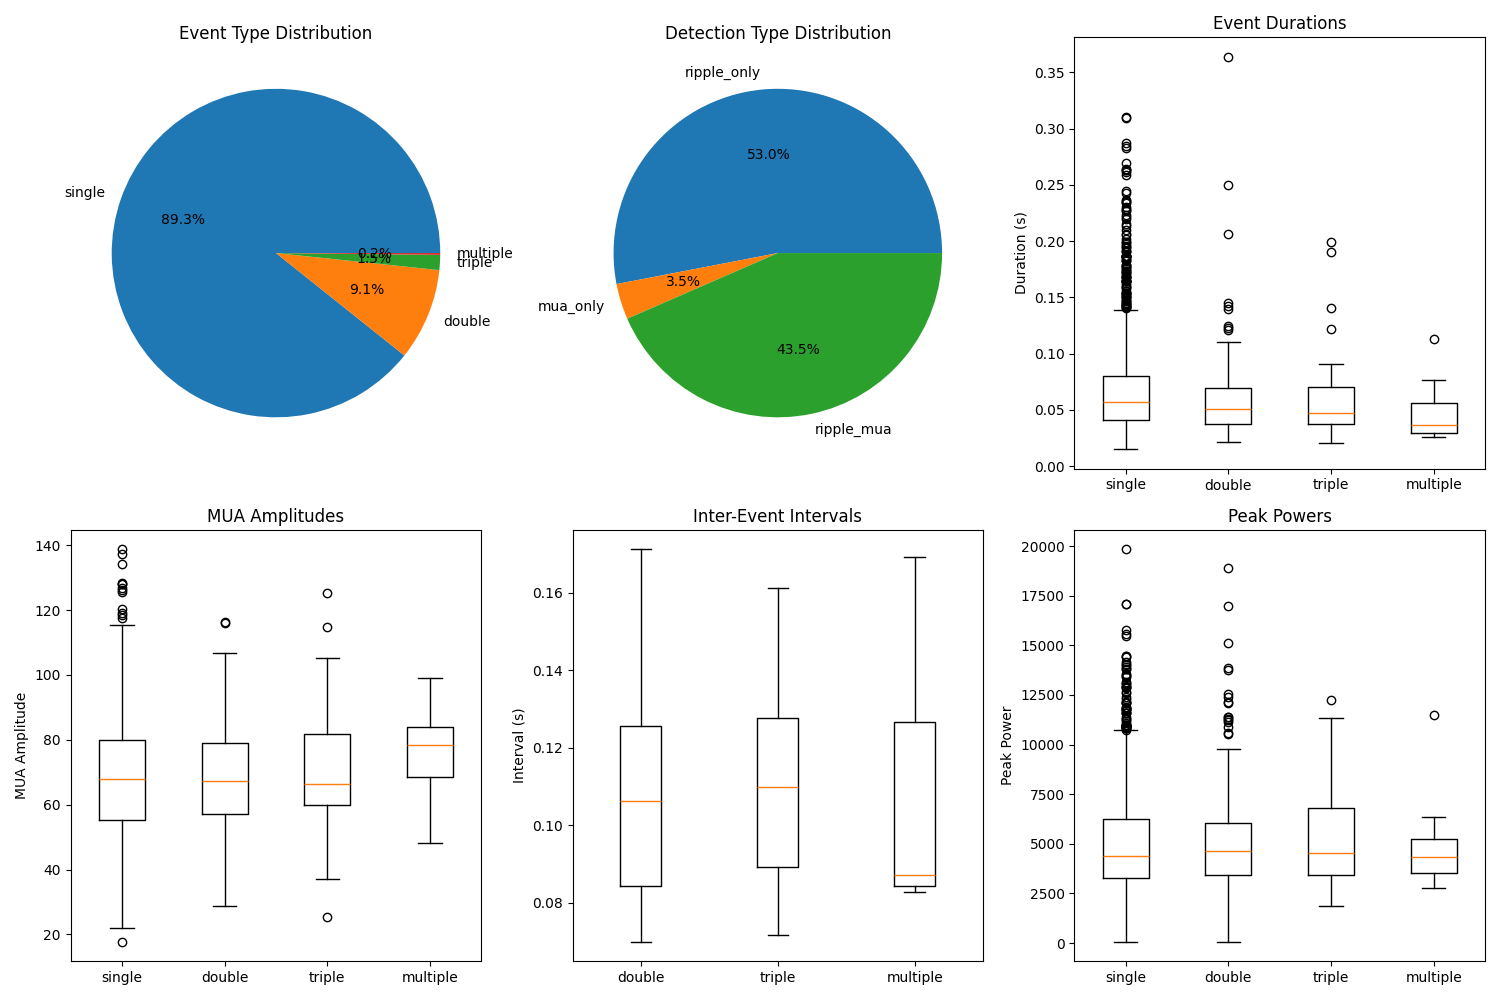

In [28]:
# First detect events
detector.detect_events(channels=[0])  # first channel from the hipp matrix

# Run classification with fixed method
detector.classify_events_improved()

# Now the statistics should work
stats = detector.analyze_basic_stats()
detector.plot_basic_stats(stats)

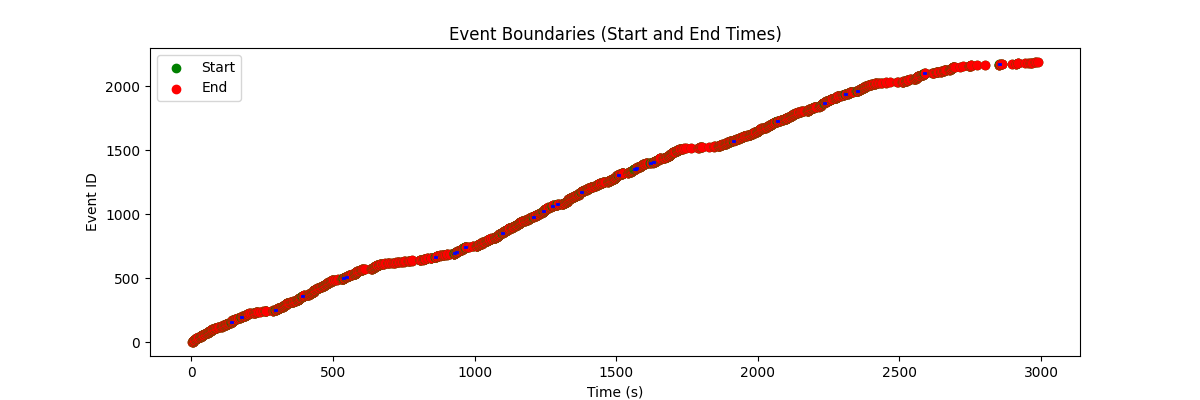

In [29]:
def debug_overlapping_events(detector):
        """
        Plot each event's start and end times on a timeline to see overlaps.
        """
        if not detector.swr_events:
            print("No events detected.")
            return

        fig, ax = plt.subplots(figsize=(12, 4))
        for event in detector.swr_events:
            # Plot a horizontal line representing the event duration
            ax.plot([event['start_time'], event['end_time']], [event['event_id']]*2, 'b-', lw=2)
            # Mark the start (green) and end (red) of each event
            ax.scatter(event['start_time'], event['event_id'], color='green', marker='o', label='Start' if event['event_id']==1 else "")
            ax.scatter(event['end_time'], event['event_id'], color='red', marker='o', label='End' if event['event_id']==1 else "")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Event ID")
        ax.set_title("Event Boundaries (Start and End Times)")
        ax.legend()
        plt.show()

debug_overlapping_events(detector)


Inspecting single events:


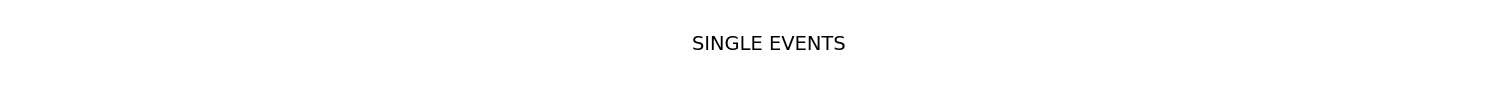

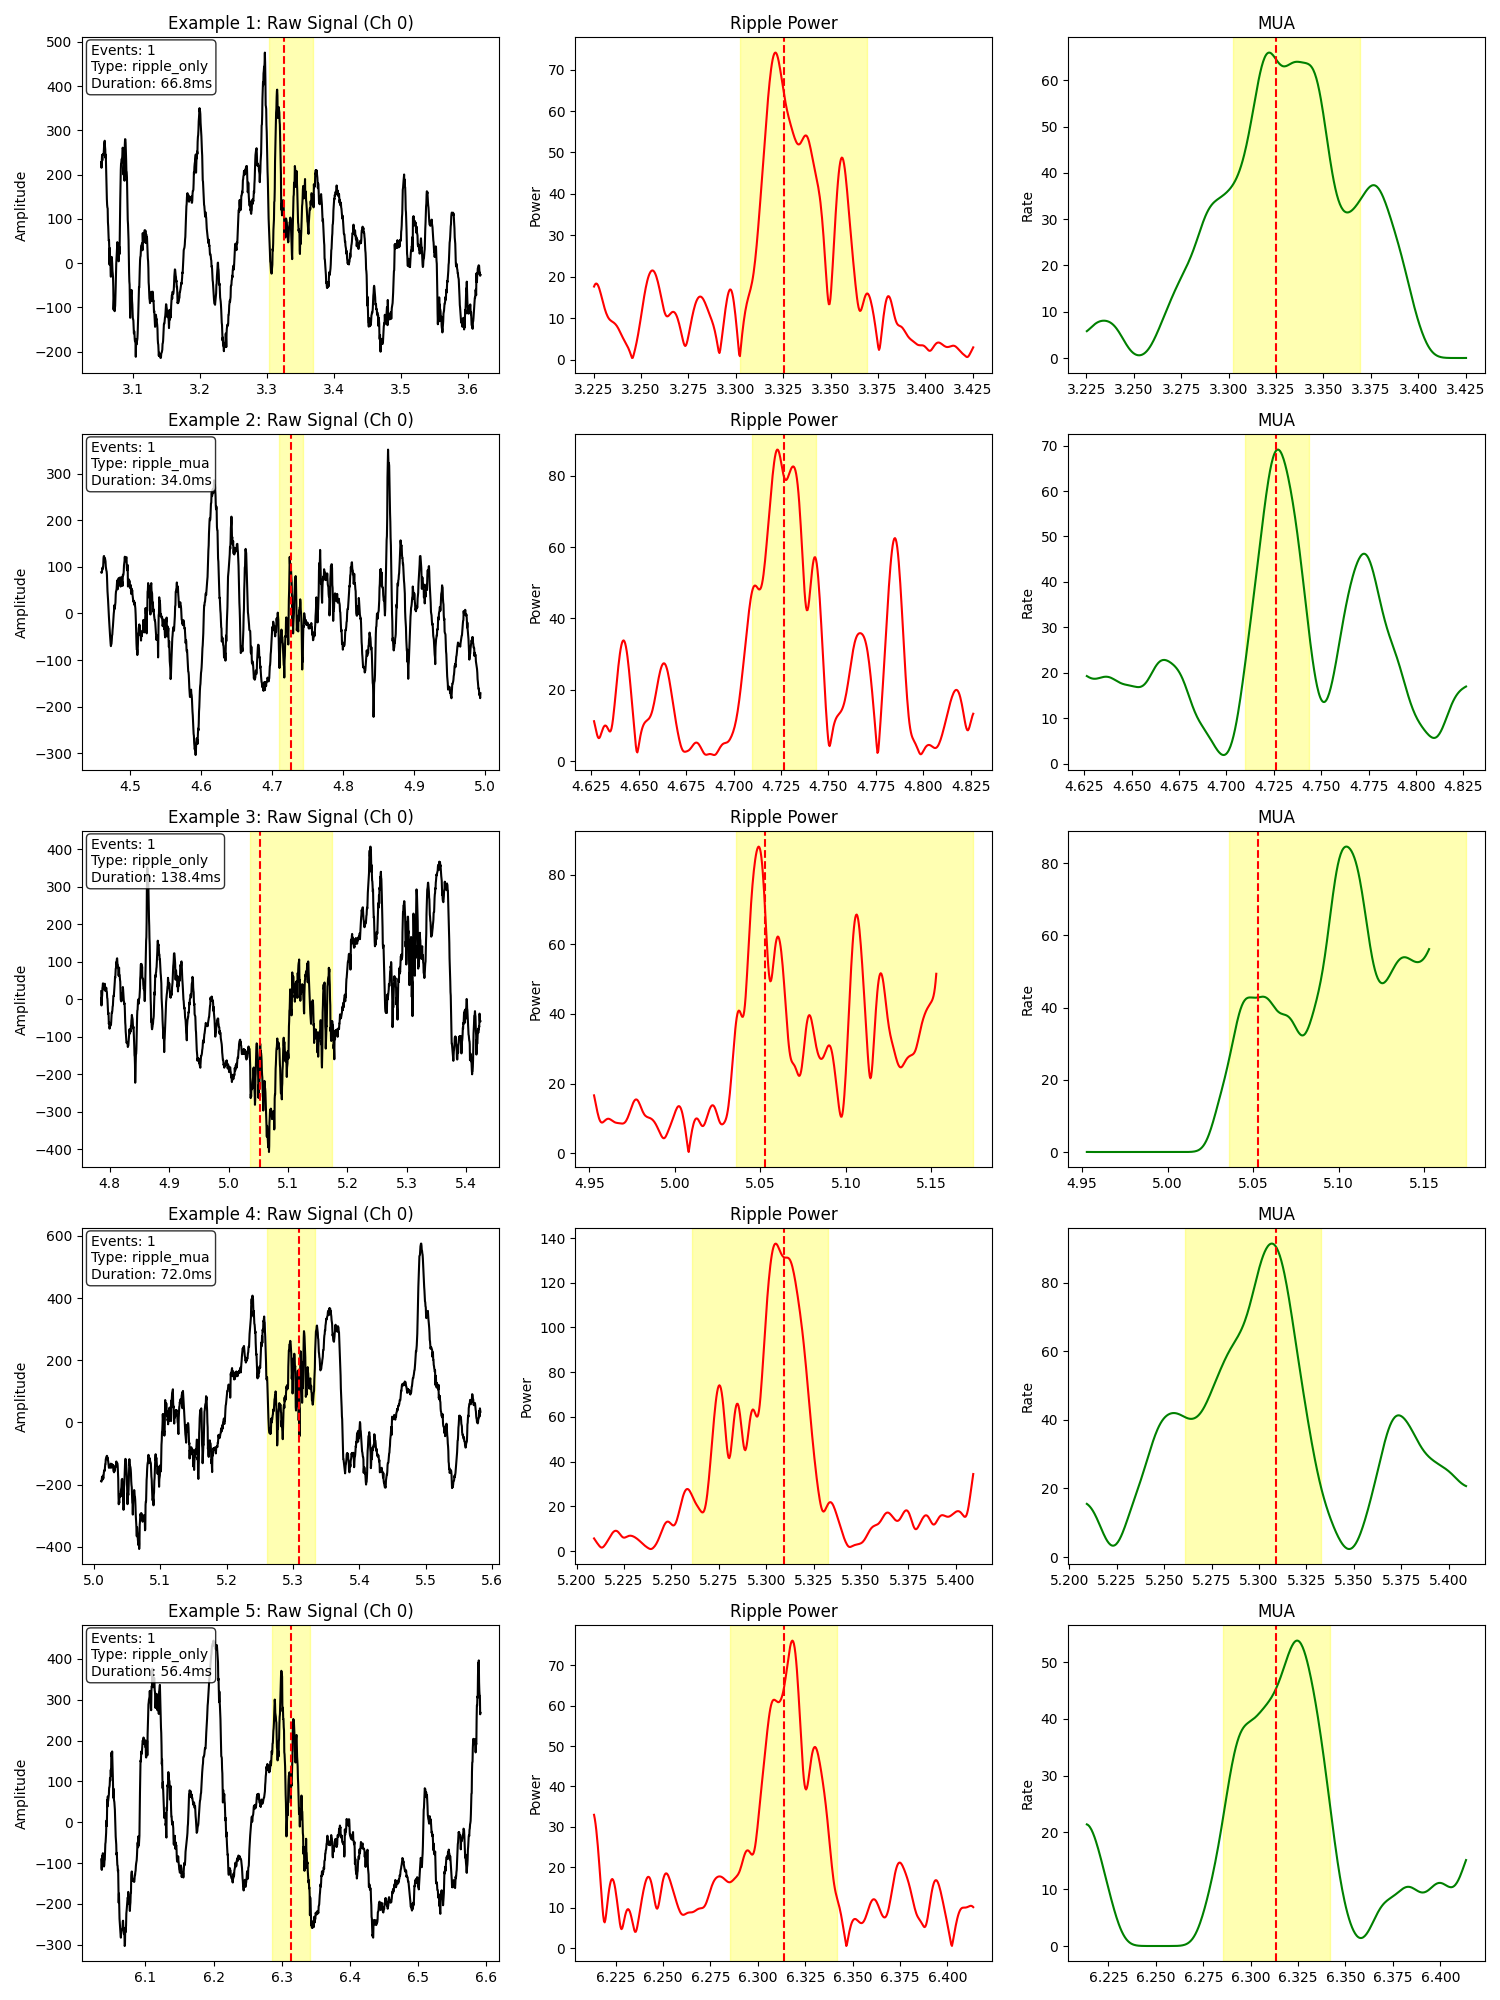


Inspecting double events:


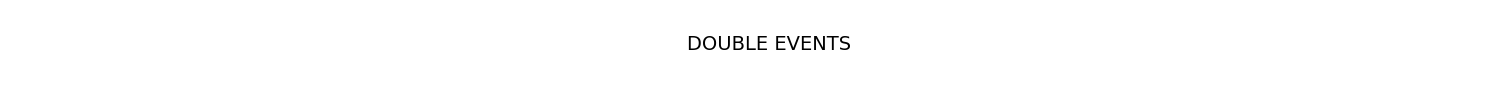

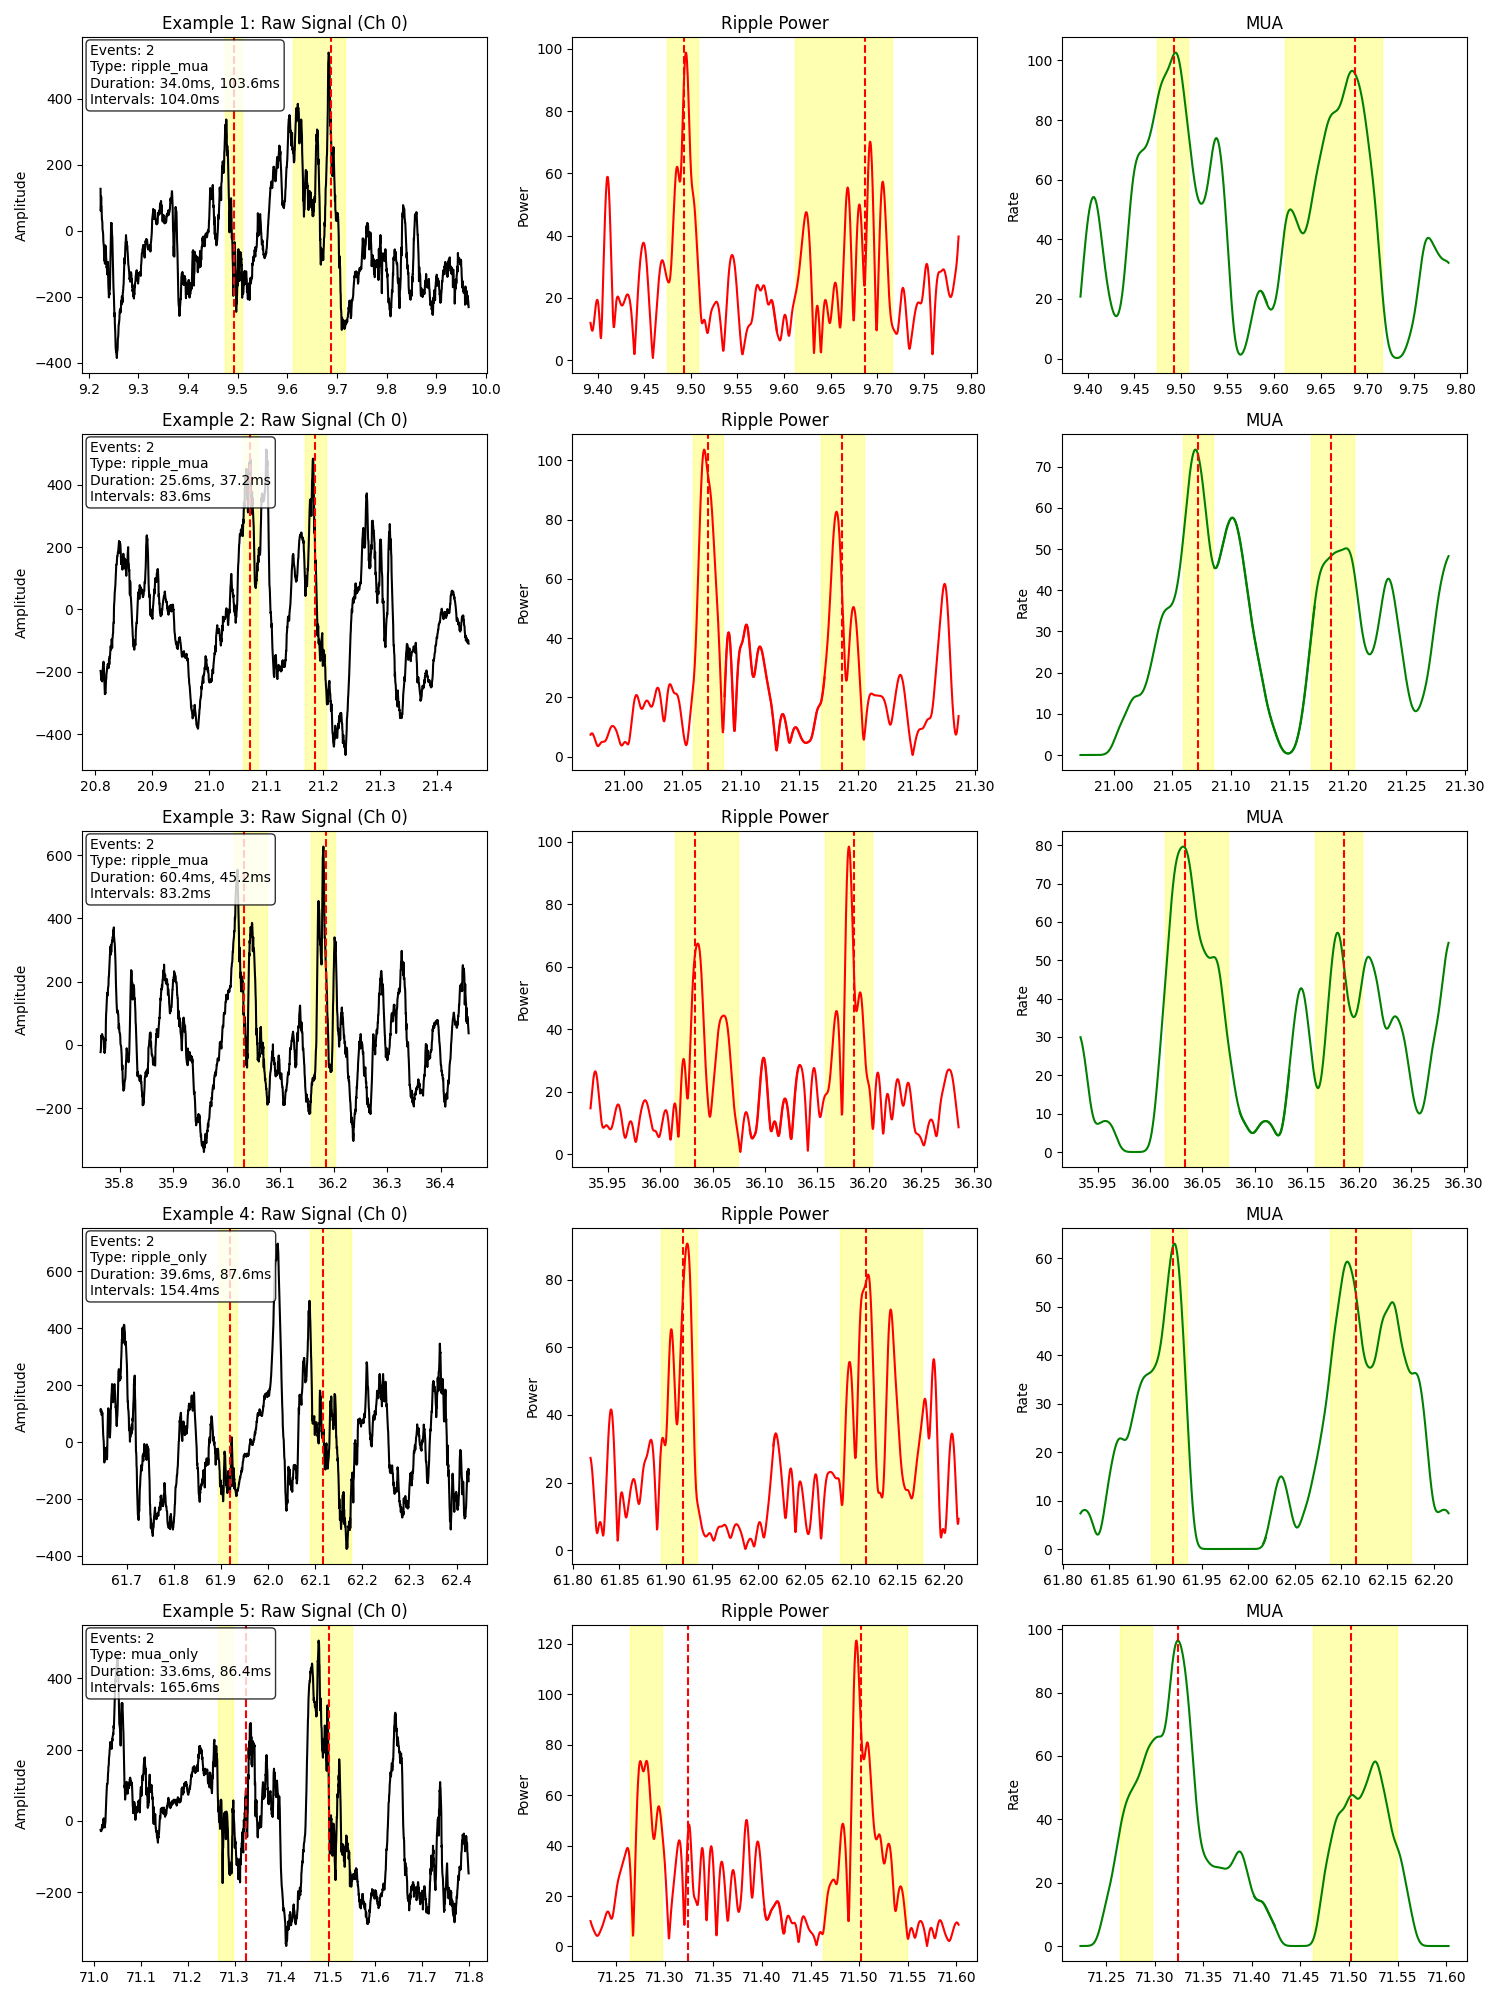


Inspecting triple events:


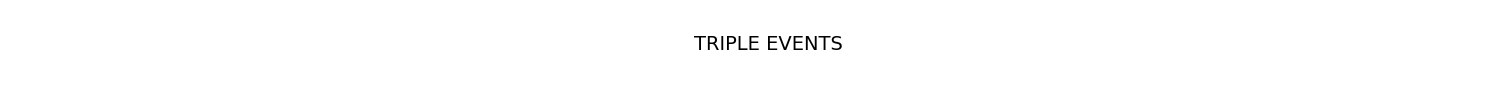

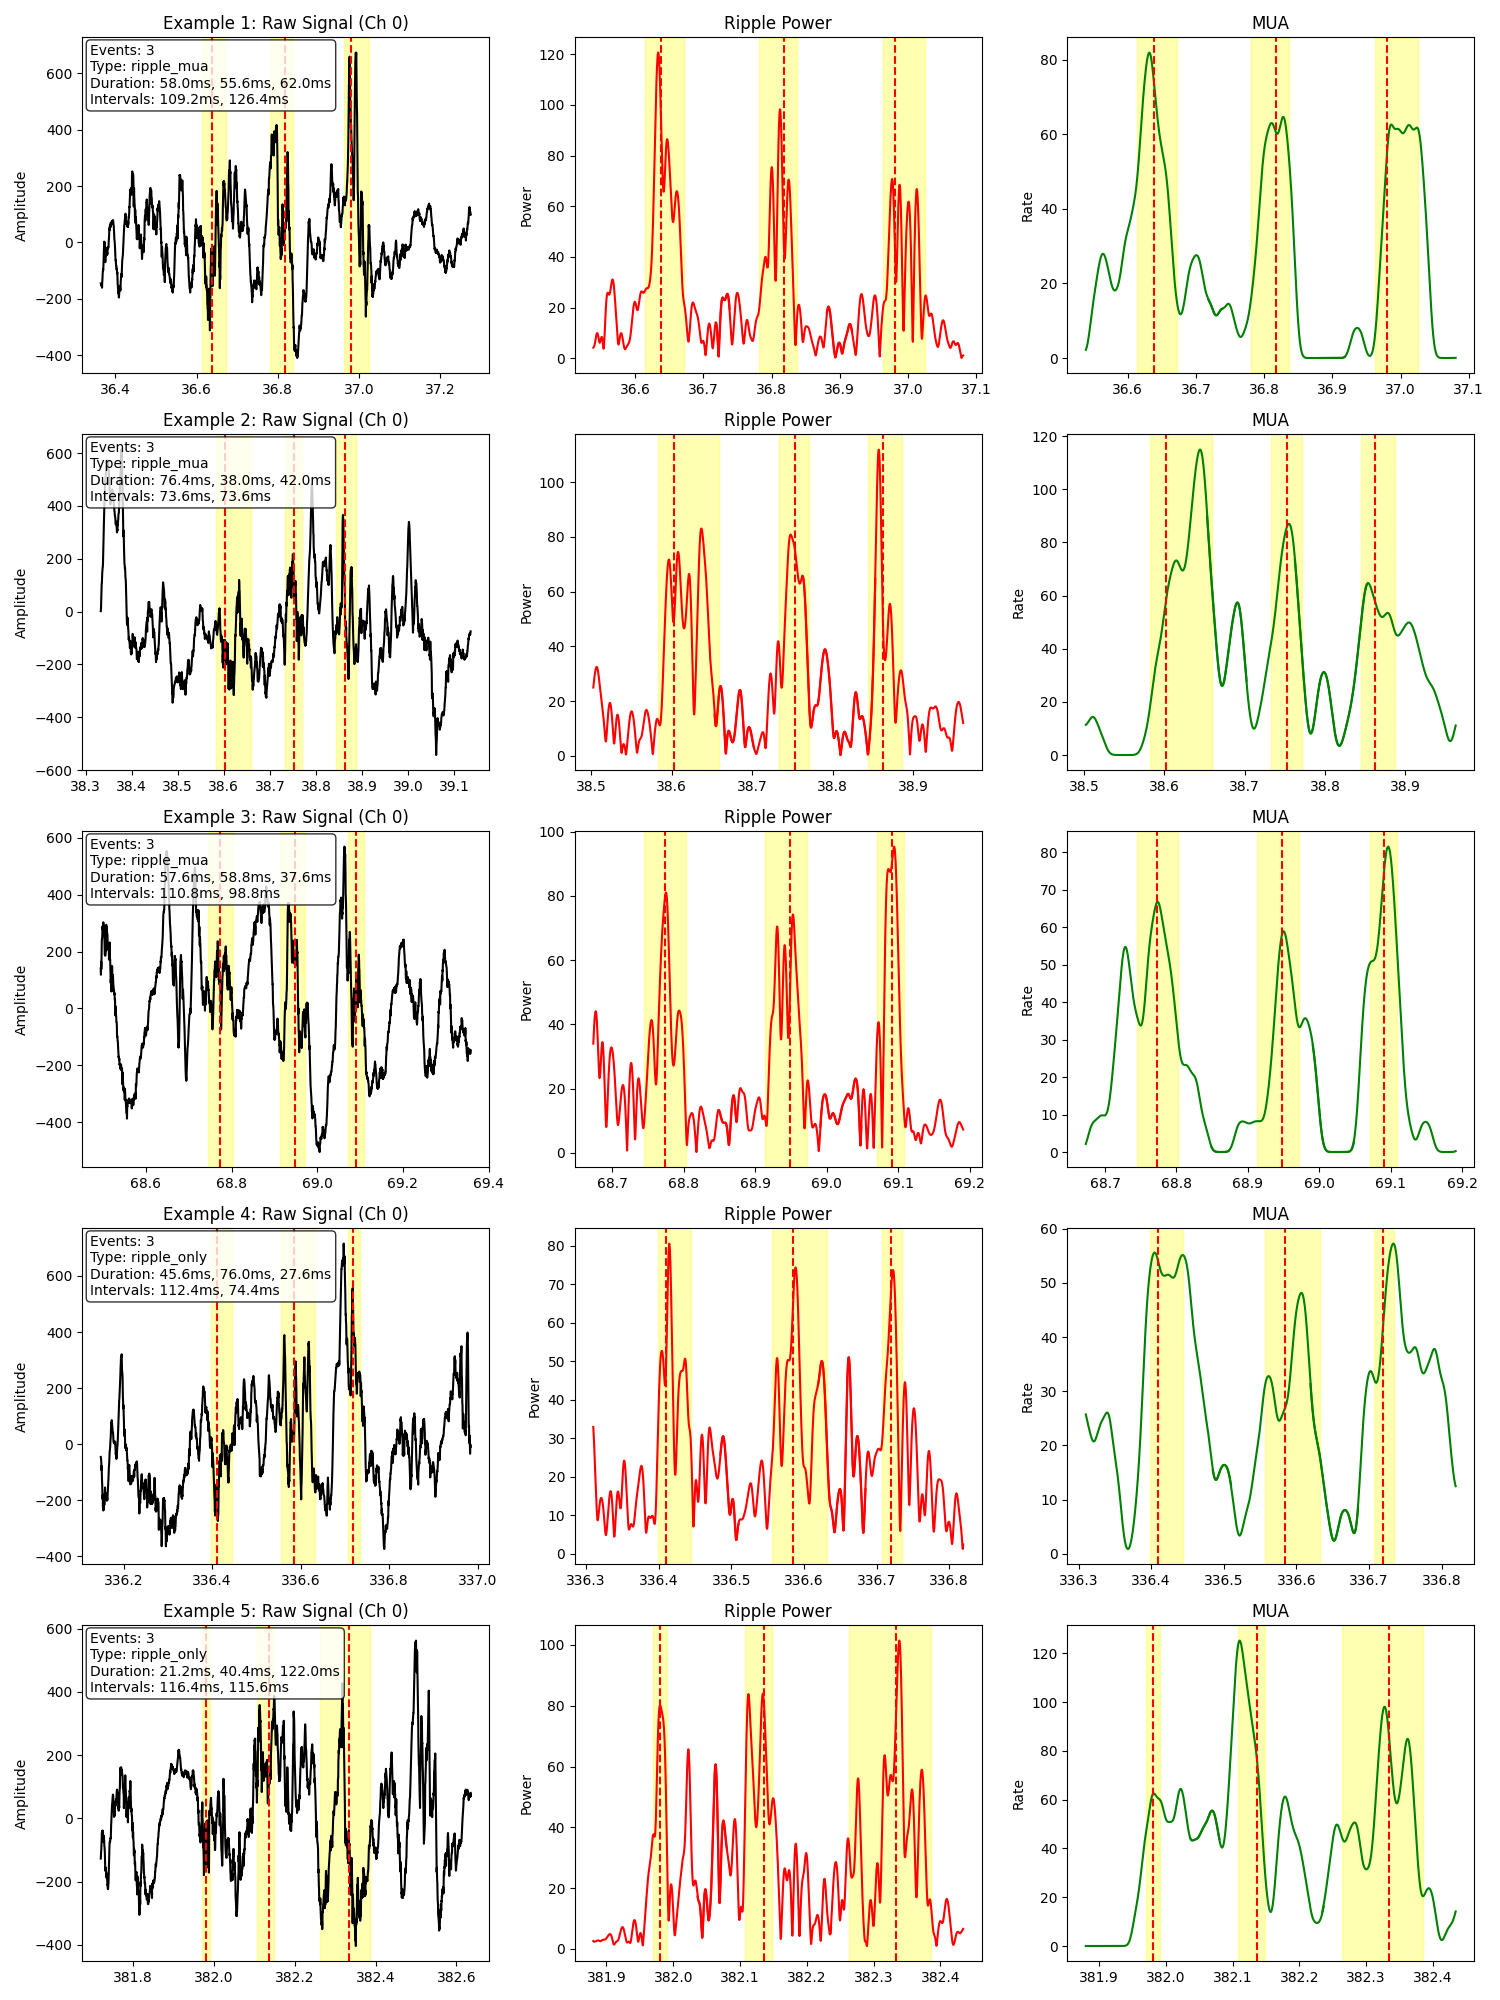


Inspecting multiple events:


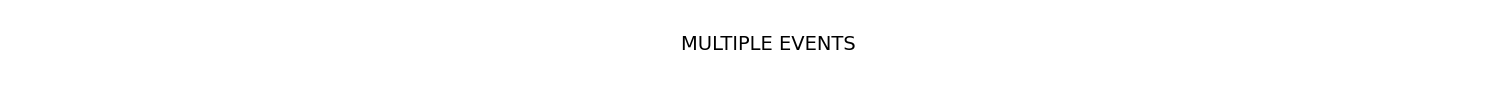

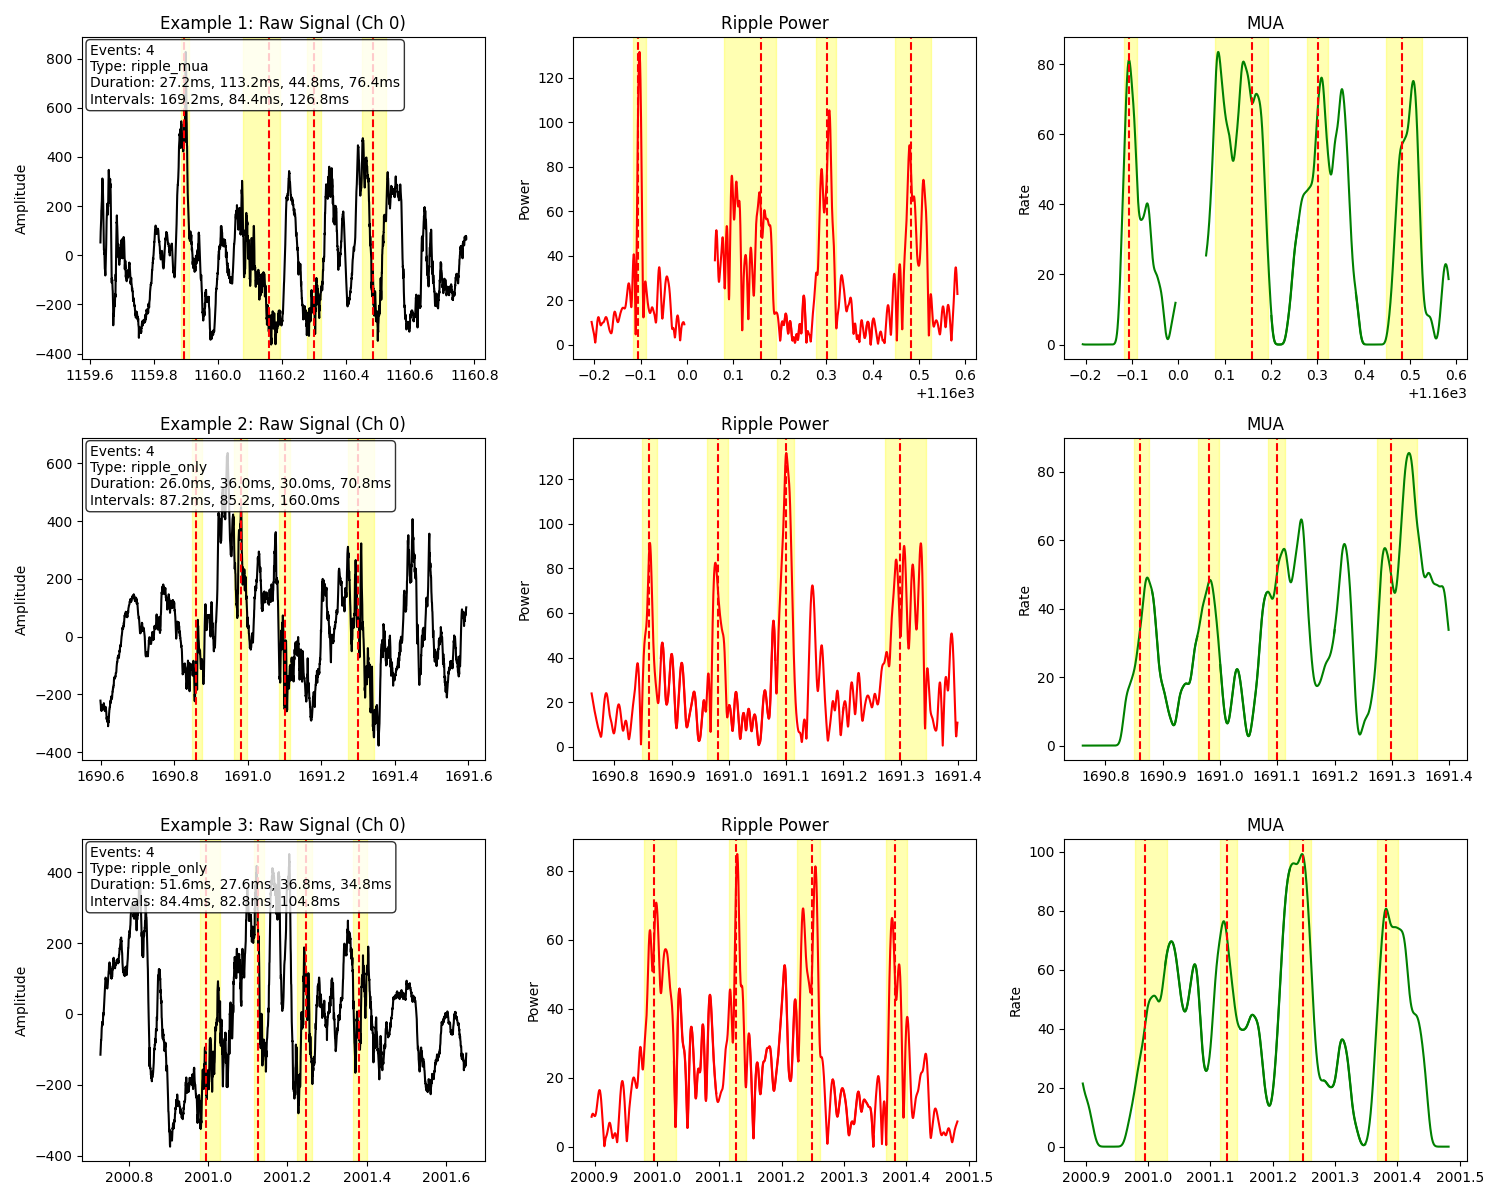

In [30]:
# To inspect a specific group type
# detector.inspect_event_groups(group_type='single', n_examples=3)

# Or to inspect all group types
detector.inspect_all_group_types(n_examples=5)

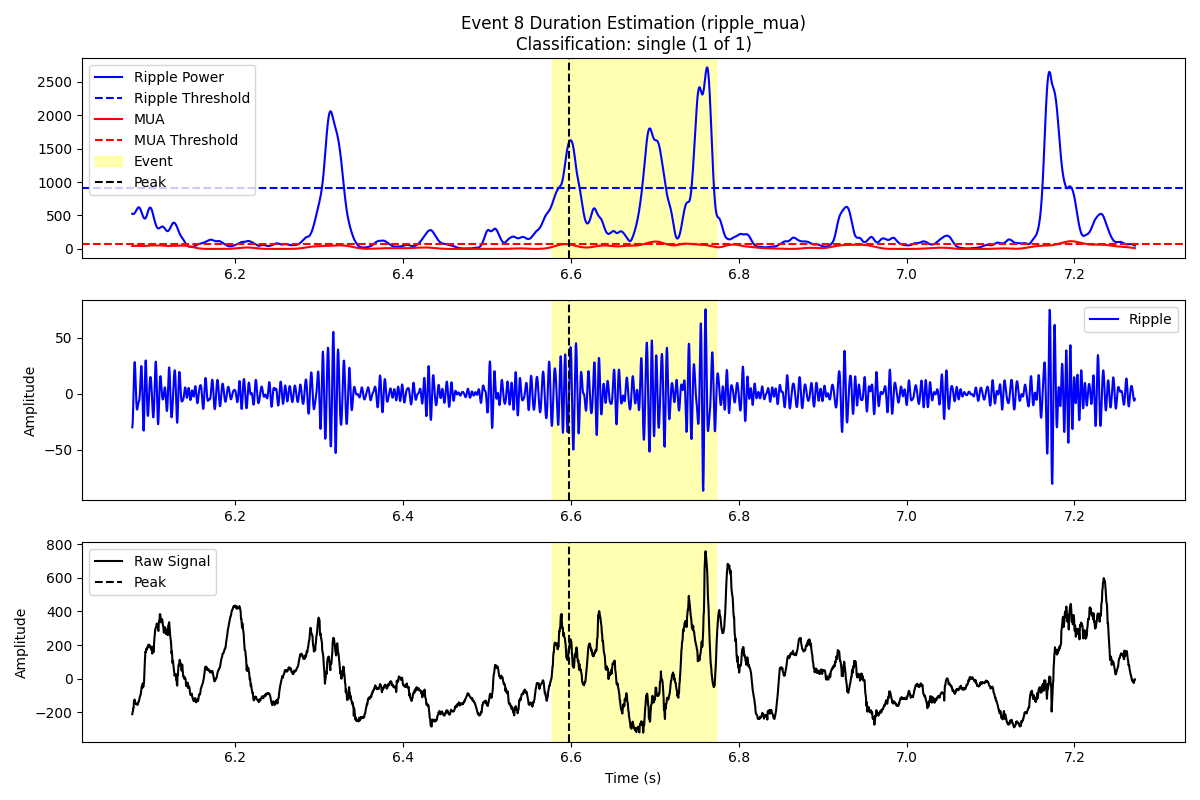


Event 8 Details:
Type: ripple_mua
Duration: 195.2 ms
Start time: 6.577 s
Peak time: 6.598 s
End time: 6.772 s
Number of peaks: 5

Classification:
Group type: single
Position in group: 1 of 1


In [31]:
detector.visualize_duration_estimation(event_id=8)                          

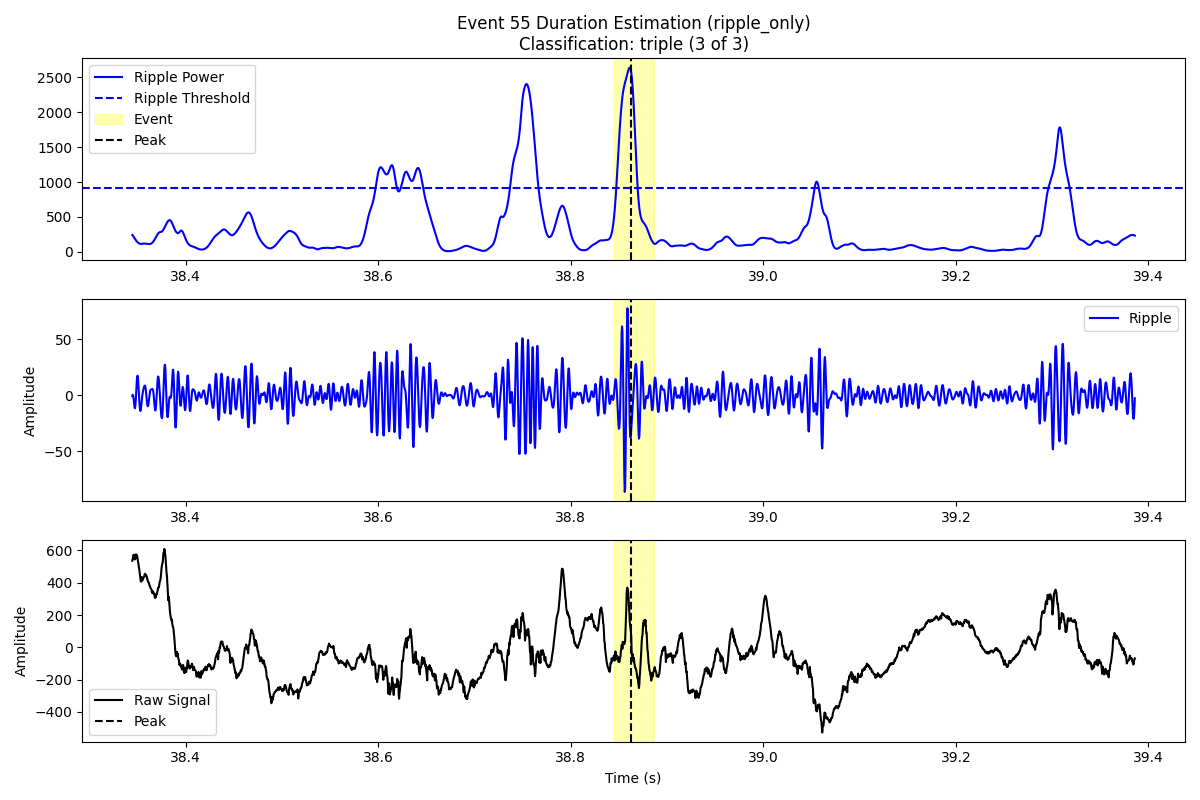


Event 55 Details:
Type: ripple_only
Duration: 42.0 ms
Start time: 38.844 s
Peak time: 38.862 s
End time: 38.886 s
Number of peaks: 1

Classification:
Group type: triple
Position in group: 3 of 3
Inter-event intervals: 73.6ms, 73.6ms


In [32]:
detector.visualize_duration_estimation(group_type='triple', group_event_index=5)


In [33]:
detector.get_events_summary
event = detector.swr_events[0]

# Available information for each event:
print(f"Event ID: {event['event_id']}")
print(f"Channel: {event['channel']}")
print(f"Duration: {event['duration']} s")
print(f"Peak time: {event['peak_time']} s")
print(f"Peak power: {event['peak_power']}")

Event ID: 1
Channel: 0
Duration: 0.0668 s
Peak time: 3.3252 s
Peak power: 3844.7017626762677


In [34]:
# Visualize events
detector.visualize_events()


Navigation Controls:
- Click 'Previous' and 'Next' buttons
- Type event number directly in the input box



Event Statistics:
Total events: 1901
Mean duration: 0.066 s
Mean peak power: 5060.822

Events per channel:
channel
0    1901
Name: count, dtype: int64


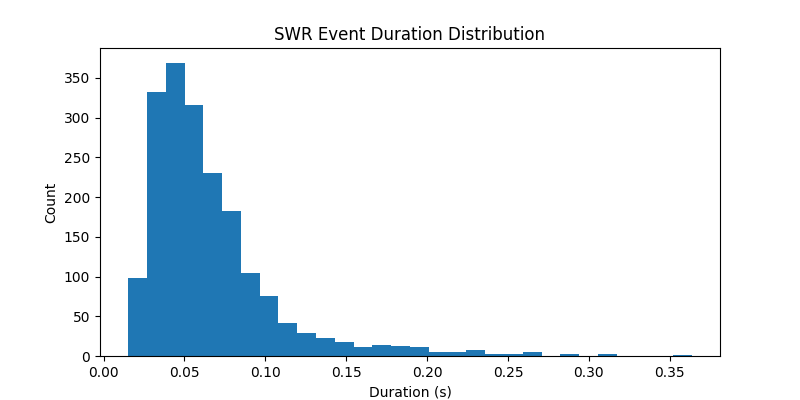

In [35]:
# Get summary DataFrame
df = detector.get_events_summary()

# Basic statistics
print("\nEvent Statistics:")
print(f"Total events: {len(df)}")
print(f"Mean duration: {df['duration'].mean():.3f} s")
print(f"Mean peak power: {df['peak_power'].mean():.3f}")

# Events per channel
channel_counts = df['channel'].value_counts()
print("\nEvents per channel:")
print(channel_counts)

# Duration histogram
plt.figure(figsize=(8, 4))
plt.hist(df['duration'], bins=30)
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.title('SWR Event Duration Distribution')
plt.show()

In [36]:
# Parameters for the SWR detector
# for event in detector.swr_events:
#     print(f"Event ID: {event['event_id']}")
#     print(f"  Start Time: {event['start_time']} sec")
#     print(f"  End Time: {event['end_time']} sec")
#     print(f"  Duration: {event['duration']} sec")
#     print(f"  Peak Time: {event['peak_time']} sec")
#     print(f"  Start Index: {event['start_idx']}")
#     print(f"  End Index: {event['end_idx']}")
#     print(f"  Peak Indices: {event['peak_times']}")  # List of detected peaks within the event
#     print("-" * 30)


# # acces to the peak times   
# peak_times = [event['peak_time'] for event in detector.swr_events]
# print("Peak Times (s):", peak_times)

# Save peak times to a CSV file
df = pd.DataFrame({'event_id': [e['event_id'] for e in detector.swr_events],
                   'peak_time': [e['peak_time'] for e in detector.swr_events]})
print(df.head())

# Save to CSV if needed
df.to_csv("peak_times.csv", index=False)



   event_id  peak_time
0         1     3.3252
1         2     4.7264
2         3     5.0528
3         6     5.3092
4         7     6.3136


**Cortical High Frequency**

In [116]:
# Cortical LFPs
pfc_data, actual_fs = resample_trace(validate_channel_time_format(raw_rec.get_traces(channel_ids=[4,5,6,7,8,9,35,36,37,38])), raw_rec.sampling_frequency, 2500, axis=1)
rtc_data, actual_fs = resample_trace(validate_channel_time_format(raw_rec.get_traces(channel_ids=[26, 27, 34])), raw_rec.sampling_frequency, 2500, axis=1)

In [ ]:
# import numpy as np
# from scipy.signal import butter, filtfilt, gaussian

# def butter_bandpass(lowcut, highcut, fs, order=5):
#     nyq = 0.5 * fs
#     low = lowcut / nyq
#     high = highcut / nyq
#     b, a = butter(order, [low, high], btype='band')
#     return b, a

# def filter_signal(data, lowcut, highcut, fs, order=4):
#     b, a = butter_bandpass(lowcut, highcut, fs, order)
#     filtered_channels = np.zeros_like(data)
#     for i in range(data.shape[0]):
#         filtered_channels[i] = filtfilt(b, a, data[i])
#     return filtered_channels

# def mua_envelop_power(data, fs, lowcut=100, highcut=2000, order=4, smoothing_window=None, smoothing_method='uniform'):
#     """
#     Calculate the power of the high-frequency component of each channel over time.
    
#     Parameters:
#         data (numpy array): Channels x Time points 2D array representing the electrophysiological data.
#         fs (float): Sampling rate in Hz.
#         lowcut (float): Lower cutoff frequency for high-frequency components.
#         highcut (float): Upper cutoff frequency for high-frequency components.
#         order (int): Filter order.
#         smoothing_window (int or None): Window size for smoothing. If None, no smoothing is applied.
#         smoothing_method (str): Smoothing method to use: 'uniform' for moving average, 'gaussian' for Gaussian kernel.
    
#     Returns:
#         numpy array: Power of the filtered signals over time for each channel after optional smoothing.
#     """
#     # Filter the high-frequency components
#     high_freq_filtered = filter_signal(data, lowcut, highcut, fs, order)
    
#     # Calculate the power of the filtered signals
#     power = np.abs(high_freq_filtered)**2
    
#     # Apply smoothing if a window is provided
#     if smoothing_window:
#         smoothed_power = np.zeros_like(power)
#         for i in range(power.shape[0]):
#             if smoothing_method == 'uniform':
#                 kernel = np.ones(smoothing_window) / smoothing_window
#             elif smoothing_method == 'gaussian':
#                 sigma = smoothing_window / 6.0  # Adjust sigma based on window size
#                 kernel = gaussian(smoothing_window, sigma)
#             else:
#                 raise ValueError("Invalid smoothing method specified")
                
#             smoothed_power[i] = np.convolve(power[i], kernel, mode='same')
        
#         return smoothed_power
    
#     return power

In [118]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter1d

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def filter_signal(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    filtered_channels = np.zeros_like(data)
    for i in range(data.shape[0]):
        filtered_channels[i] = filtfilt(b, a, data[i])
    return filtered_channels

def mua_envelop_power(data, fs, lowcut=100, highcut=2000, order=4, smoothing_window=None, smoothing_method='uniform'):
    """
    Calculate the power of the high-frequency component of each channel over time.

    Parameters:
        data (numpy array): Channels x Time points 2D array representing the electrophysiological data.
        fs (float): Sampling rate in Hz.
        lowcut (float): Lower cutoff frequency for high-frequency components.
        highcut (float): Upper cutoff frequency for high-frequency components.
        order (int): Filter order.
        smoothing_window (int or None): Window size for smoothing. If None, no smoothing is applied.
        smoothing_method (str): Smoothing method to use: 'uniform' for moving average, 'gaussian' for Gaussian kernel.

    Returns:
        numpy array: Power of the filtered signals over time for each channel after optional smoothing.
    """
    # Filter the high-frequency components
    high_freq_filtered = filter_signal(data, lowcut, highcut, fs, order)

    # Calculate the power of the filtered signals
    power = np.abs(high_freq_filtered)**2

    # Apply smoothing if a window is provided
    if smoothing_window:
        smoothed_power = np.zeros_like(power)
        for i in range(power.shape[0]):
            if smoothing_method == 'uniform':
                kernel = np.ones(smoothing_window) / smoothing_window
                smoothed_power[i] = np.convolve(power[i], kernel, mode='same')
            elif smoothing_method == 'gaussian':
                sigma = smoothing_window / 6.0  # Adjust sigma based on window size
                smoothed_power[i] = gaussian_filter1d(power[i], sigma)
            else:
                raise ValueError("Invalid smoothing method specified")

        return smoothed_power

    return power


In [ ]:
# Smoothing the power envelop
fs = 30000  # Sampling rate in Hz

# Calculate the power with and without smoothing
# power_without_smoothing = mua_envelop_power(data, fs)
mua_rtc = mua_envelop_power(rtc_data, fs, smoothing_window=100)
mua_pfc = mua_envelop_power(pfc_data, fs, smoothing_window=100)

# print("Power without smoothing:\n", power_without_smoothing)
# print("Power with smoothing:\n", power_with_smoothing)

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

def visualize_recording(raw_data, power_data, fs=30000, window_size_seconds=1):
    samples_per_window = int(fs * window_size_seconds)
    total_windows = raw_data.shape[1] // samples_per_window

    # Create figure with two subplots vertically
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    def plot_time_segment(time_idx):
        # Clear previous plots
        ax1.clear()
        ax2.clear()

        # Calculate start and end indices for the current segment
        start = time_idx * samples_per_window
        end = start + samples_per_window

        # Calculate absolute time for the segment
        absolute_start_time = start / fs
        absolute_end_time = end / fs

        # Time data for the segment (starting from 0)
        time_data = np.linspace(0, window_size_seconds, samples_per_window)

        # Plot raw data segment
        for i in range(raw_data.shape[0]):
            ax1.plot(time_data, raw_data[i, start:end], label=f'Channel {i + 1}', alpha=0.7)

        ax1.set_title(f'Raw Data: {absolute_start_time:.2f} - {absolute_end_time:.2f} s')
        ax1.set_xlabel('Time (seconds)')
        ax1.set_ylabel('Amplitude')
        ax1.grid(True)
        ax1.legend()

        # Plot power data segment
        for i in range(power_data.shape[0]):
            ax2.plot(time_data, power_data[i, start:end], label=f'Channel {i + 1}', alpha=0.7)

        ax2.set_title(f'Power Data: {absolute_start_time:.2f} - {absolute_end_time:.2f} s')
        ax2.set_xlabel('Time (seconds)')
        ax2.set_ylabel('Power')
        ax2.grid(True)
        ax2.legend()

        # Redraw the figure
        fig.tight_layout()
        fig.canvas.draw()

    # Create slider and buttons
    if total_windows > 0:
        slider = widgets.IntSlider(
            value=0, 
            min=0, 
            max=(total_windows - 1), 
            step=1, 
            description='Segment Index:'
        )
        forward_button = widgets.Button(description='→ Next Segment')
        backward_button = widgets.Button(description='← Previous Segment')

        def update_plot(change):
            # Update plot when slider value changes
            plot_time_segment(change['new'])

        def move_forward(_):
            if slider.value < total_windows - 1:
                slider.value += 1

        def move_backward(_):
            if slider.value > 0:
                slider.value -= 1

        # Connect slider to plot update
        slider.observe(update_plot, names='value')

        forward_button.on_click(move_forward)
        backward_button.on_click(move_backward)

        # Create a container for the controls
        controls = widgets.VBox([backward_button, slider, forward_button])

        # Display controls next to the plot
        display(controls)

        # Initial plot
        plot_time_segment(0)
    else:
        print("Not enough data points to create any windows.")

# Example usage (commented out)
# raw_data = np.random.randn(16, 2000)  # Original raw signals
# power_data = np.abs(raw_data) ** 2  # Example power calculation
# visualize_recording(raw_data, power_data)

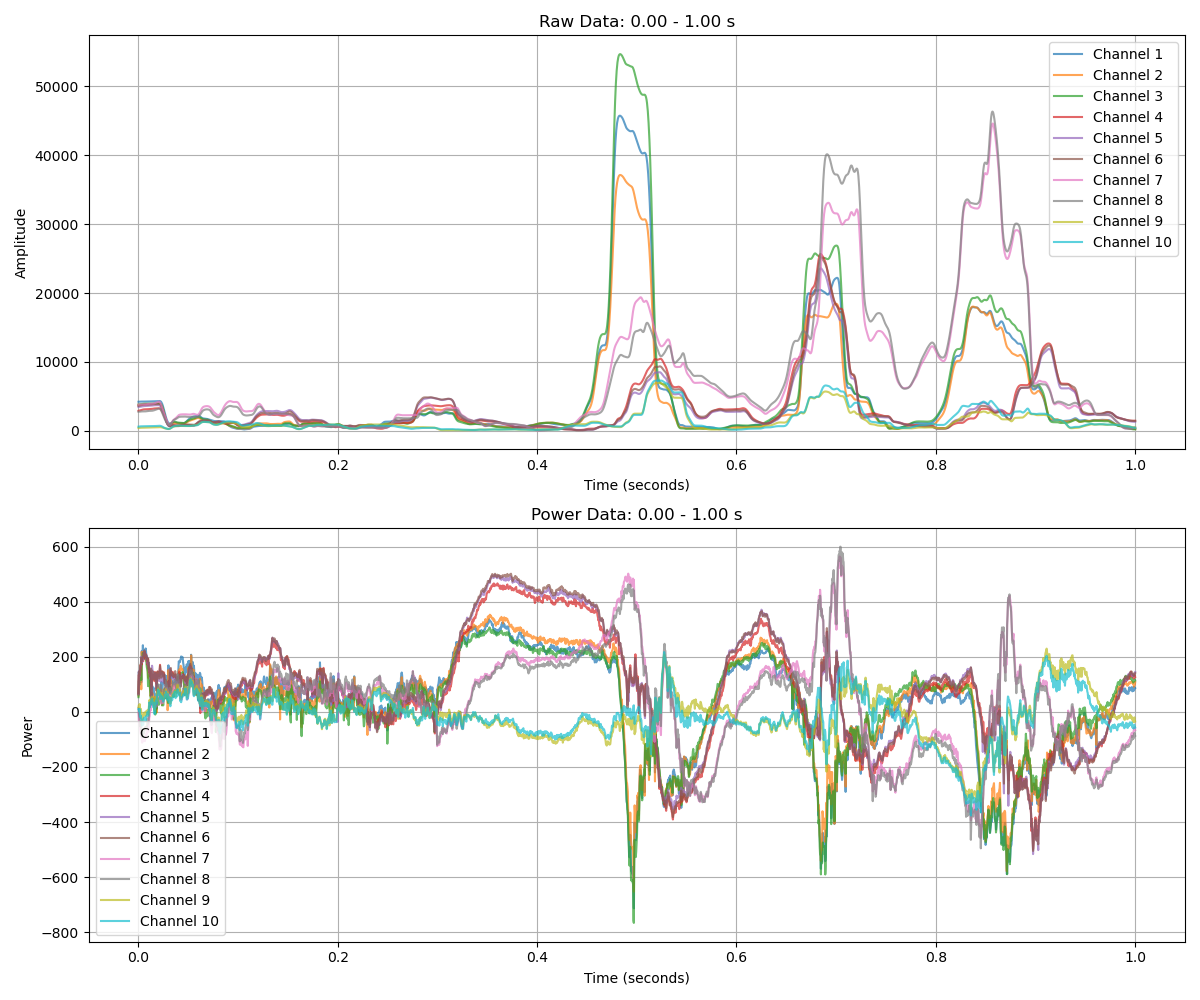

In [124]:
visualize_recording(mua_pfc, pfc_data, fs=actual_fs, window_size_seconds=1)

**Tensor Code**

In [ ]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import parafac
from scipy.io import loadmat
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
from community import community_louvain
import networkx as nx
from tqdm.notebook import tqdm

class TCAAnalysis:
    def __init__(self, data_path):
        """Initialize TCA analysis with data path."""
        self.data = self._load_data(data_path)
        
    def _load_data(self, path):
        """Load .mat file containing calcium imaging data."""
        try:
            mat_data = loadmat(path)
            # Assuming 'dFF_peri_ripple' is the variable name in .mat file
            return mat_data['dFF_peri_ripple']
        except:
            raise ValueError("Could not load data from specified path")

    def preprocess_data(self):
        """Preprocess the calcium imaging data."""
        # Make data positive by subtracting minimum and adding small constant
        self.processed_data = self.data - np.min(self.data) + 0.001
        return self.processed_data

    def perform_stage1_tca(self, R_dim=15, reptime=10):
        """Perform first stage TCA."""
        n_region, T, n_trials = self.processed_data.shape
        error_all = np.zeros(reptime)
        tca_results = []

        # Perform TCA multiple times
        for r in tqdm(range(reptime)):
            np.random.seed(r)
            # Perform PARAFAC decomposition
            weights, factors = parafac(self.processed_data, rank=R_dim, 
                                     init='random', random_state=r)
            
            # Calculate reconstruction error
            reconstructed = tl.kruskal_to_tensor((weights, factors))
            error = np.linalg.norm(self.processed_data - reconstructed)
            
            tca_results.append({
                'weights': weights,
                'factors': factors,
                'error': error,
                'templates': self._compute_templates(factors)
            })
            error_all[r] = error

        self.stage1_results = {
            'tca_results': tca_results,
            'error_all': error_all,
            'best_fit': np.argmin(error_all)
        }
        return self.stage1_results

    def _compute_templates(self, factors):
        """Compute templates from TCA factors."""
        region_factor, time_factor, trial_factor = factors
        templates = np.zeros((region_factor.shape[0], time_factor.shape[0]))
        for r in range(region_factor.shape[1]):
            outer_product = np.outer(region_factor[:, r], time_factor[:, r])
            templates += outer_product
        return templates

    def compute_similarity_matrix(self, patterns, threshold=0.7):
        """Compute similarity matrix between patterns."""
        n_patterns = patterns.shape[2]
        similarity_matrix = np.zeros((n_patterns, n_patterns))
        
        for i in range(n_patterns):
            for j in range(n_patterns):
                correlation = np.corrcoef(patterns[:,:,i].flatten(), 
                                       patterns[:,:,j].flatten())[0,1]
                similarity_matrix[i,j] = correlation if correlation > threshold else 0
                
        return similarity_matrix

    def perform_community_detection(self, similarity_matrix):
        """Perform community detection on similarity matrix."""
        # Create network from similarity matrix
        G = nx.from_numpy_array(similarity_matrix)
        
        # Perform community detection
        communities = community_louvain.best_partition(G)
        
        return communities

    def perform_stage2_tca(self, consistent_patterns, n_components=8, n_repeats=10):
        """Perform second stage TCA with initialization from stage 1."""
        errors = np.zeros(n_repeats)
        tca_results = []

        for r in tqdm(range(n_repeats)):
            np.random.seed(r)
            
            # Initialize factors using consistent patterns
            init = [
                normalize(np.mean(consistent_patterns, axis=2)),  # spatial init
                normalize(np.mean(consistent_patterns, axis=0)),  # temporal init
                np.random.rand(self.processed_data.shape[2], n_components)  # trial init
            ]
            
            # Perform PARAFAC with initialization
            weights, factors = parafac(self.processed_data, rank=n_components, 
                                     init=init, random_state=r)
            
            # Calculate reconstruction error
            reconstructed = tl.kruskal_to_tensor((weights, factors))
            error = np.linalg.norm(self.processed_data - reconstructed)
            
            tca_results.append({
                'weights': weights,
                'factors': factors,
                'error': error,
                'templates': self._compute_templates(factors)
            })
            errors[r] = error

        self.stage2_results = {
            'tca_results': tca_results,
            'error_all': errors,
            'best_fit': np.argmin(errors)
        }
        return self.stage2_results

    def plot_similarity_matrix(self, similarity_matrix):
        """Plot similarity matrix as heatmap."""
        plt.figure(figsize=(10, 8))
        sns.heatmap(similarity_matrix, cmap='gray_r')
        plt.xlabel('Pattern ID')
        plt.ylabel('Pattern ID')
        plt.title('Pattern Similarity Matrix')
        plt.show()

    def plot_factors(self, factors, n_components):
        """Plot TCA factors."""
        region_factor, time_factor, trial_factor = factors
        
        fig, axes = plt.subplots(3, 1, figsize=(15, 10))
        
        # Plot region factors
        sns.heatmap(region_factor, ax=axes[0], cmap='viridis')
        axes[0].set_title('Region Factors')
        
        # Plot time factors
        sns.heatmap(time_factor, ax=axes[1], cmap='viridis')
        axes[1].set_title('Time Factors')
        
        # Plot trial factors
        sns.heatmap(trial_factor, ax=axes[2], cmap='viridis')
        axes[2].set_title('Trial Factors')
        
        plt.tight_layout()
        plt.show()

# Example usage in Jupyter notebook:
"""
# Initialize analysis
tca = TCAAnalysis('peri_ripple_dFF_segments.mat')

# Preprocess data
processed_data = tca.preprocess_data()

# Perform stage 1 TCA
stage1_results = tca.perform_stage1_tca()

# Compute similarity matrix
patterns = stage1_results['tca_results'][stage1_results['best_fit']]['templates']
similarity_matrix = tca.compute_similarity_matrix(patterns)

# Plot similarity matrix
tca.plot_similarity_matrix(similarity_matrix)

# Perform community detection
communities = tca.perform_community_detection(similarity_matrix)

# Perform stage 2 TCA
stage2_results = tca.perform_stage2_tca(patterns)

# Plot final results
best_factors = stage2_results['tca_results'][stage2_results['best_fit']]['factors']
tca.plot_factors(best_factors, n_components=8)
"""

In [ ]:
# Example usage in Jupyter notebook:
# Initialize analysis
tca = TCAAnalysis('peri_ripple_dFF_segments.mat')

# Preprocess data
processed_data = tca.preprocess_data()

# Perform stage 1 TCA
stage1_results = tca.perform_stage1_tca()

# Compute similarity matrix
patterns = stage1_results['tca_results'][stage1_results['best_fit']]['templates']
similarity_matrix = tca.compute_similarity_matrix(patterns)

# Plot similarity matrix
tca.plot_similarity_matrix(similarity_matrix)

# Perform community detection
communities = tca.perform_community_detection(similarity_matrix)

# Perform stage 2 TCA
stage2_results = tca.perform_stage2_tca(patterns)

# Plot final results
best_factors = stage2_results['tca_results'][stage2_results['best_fit']]['factors']
tca.plot_factors(best_factors, n_components=8)